<img src="img/intro.jpg">

<img src="img/movielens.png">

### MovieLens Data sets

Watching movies is one of the most popular pasttimes today. There are so many movies being released for streaming every year, and it is impossible to keep up with all of them. When someone is looking for a new movie to watch, he/she will often turn to movie-related sites, like IMDB or rotten tomatoes, which aggregate ratings, reviews, and other information about movies. One of the most important factors influencing one's decision to watch a movie is the overall rating. However, does the rating reasonably represent the entire population's opinion of the movie? 

To address this question, I will use the enormous MovieLens data sets (http://movielens.org), which is collected by GroupLens Research (https://grouplens.org/datasets/movielens/). This dataset consists of more than 26 million ratings of approximately 45,000 movies, with around 270,000 users. 

Let's start! 
First, let's import the python modules we need.

In [10]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from bs4 import BeautifulSoup
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
%matplotlib inline

In [11]:
GenreList = ['Action','Adventure','Animation','Children','Comedy',
             'Crime','Documentary','Drama','Fantasy','FilmNoir',
             'Horror','Musical','Mystery','Romance','SciFi',
             'Thriller','War','Western','IMAX']

GenreAll = ['Action','Adventure','Animation','Children','Comedy',
            'Crime','Documentary','Drama','Fantasy','FilmNoir',
            'Horror','Musical','Mystery','Romance','SciFi',
            'Thriller','War','Western']

incl_year = ['Action','Adventure','Animation','Children','Comedy',
            'Crime','Documentary','Drama','Fantasy','FilmNoir',
            'Horror','Musical','Mystery','Romance','SciFi',
            'Thriller','War','Western','av_Year']

c = ['aqua',  'coral','darkred','magenta','orange',
     'olive','#800080','blue','#4682B4','mediumseagreen',
     'red','navy', 'green','khaki', 'salmon', 'teal', 
     'yellow', 'lightblue']

c_dic={}
for i in range(len(GenreAll)):
    c_dic[GenreAll[i]]=c[i]

## Load Files

In [12]:
from movie_fun import *

In [13]:
## Read in the MovieLens dataset
Movie = pd.read_csv('movies.csv')
Rating = pd.read_csv('ratings.csv')
Link = pd.read_csv('links.csv')

In [14]:
Rating.head(2)

userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435

In [15]:
Movie.head(2)

movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy

In [16]:
Link.head(2)

movieId  imdbId  tmdbId
0        1  114709   862.0
1        2  113497  8844.0

In [17]:
def preprocessing(Movie):
    Movie = title_cleaning(Movie)

    ## The following cleaning steps take a while to run, 
    ## so I comment them out after running and saving the output.
    ## extract year info. from iMDB website
    #year = extract_imdb(Movie)
    ## let's check the movies with year from IMDB
    #test = pd.DataFrame(Movie[Movie.Year=='']['title'])
    #test['year']=year
    #test.head()
    #test.to_csv('year.csv')
    
    recover_year = pd.read_csv('year.csv')
    recover_year.columns=['number','title','year']
    recover_year = recover_year.set_index('number')
    
    Movie = year_cleaning(Movie,recover_year['year'])
    Movie = genre_cleaning(Movie)
    MovieGenre = genre_dummies(Movie)

    return(Movie,MovieGenre)

Movie,MovieGenre = preprocessing(Movie)

Separate the year from the title using regular expressions...
       movieId                                              title  \
0            1                                   Toy Story (1995)   
1            2                                     Jumanji (1995)   
2            3                            Grumpier Old Men (1995)   
3            4                           Waiting to Exhale (1995)   
4            5                 Father of the Bride Part II (1995)   
5            6                                        Heat (1995)   
6            7                                     Sabrina (1995)   
7            8                                Tom and Huck (1995)   
8            9                                Sudden Death (1995)   
9           10                                   GoldenEye (1995)   
10          11                     American President, The (1995)   
11          12                 Dracula: Dead and Loving It (1995)   
12          13                           

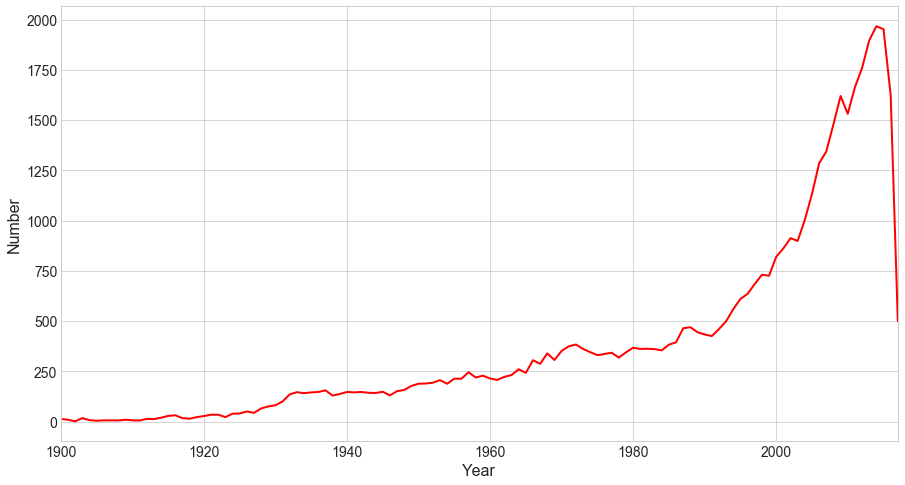

In [18]:
def plot_count(df,column):
    df.groupby(column).count()['title'].plot(figsize=(15,8),xlim=(1900,2017),fontsize=14,linewidth=2.0,c='r')
    plt.ylabel('Number',fontsize=16)
    plt.xlabel(column,fontsize=16)

plot_count(Movie,'Year')

## Take a look at the distribution of movie release years by genre

In [19]:
MovieGenre.columns = MovieGenre.columns.get_level_values(0)

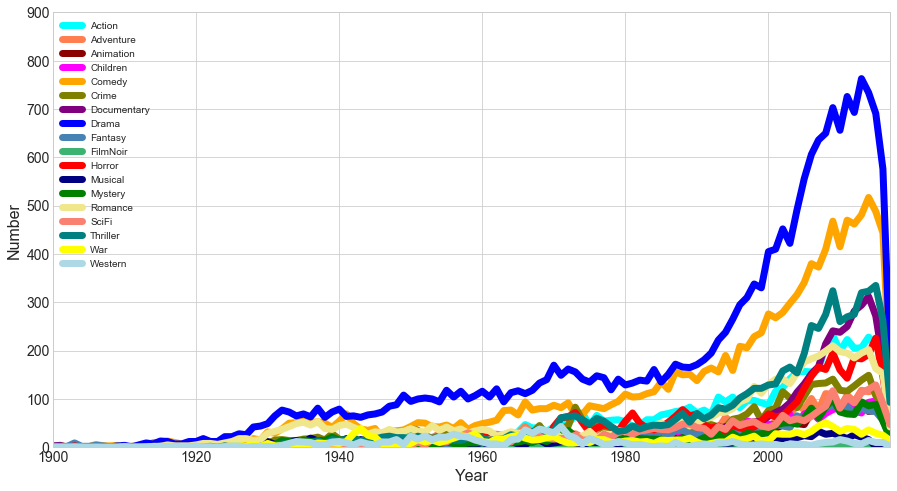

In [20]:
def plot_sum(df,column):
    df.groupby(column).sum()[GenreAll].plot(xlim=(1900,2017),ylim=(0,900),figsize=(15,8),color=c,linewidth=7.0)
    plt.ylabel('Number',fontsize=16)
    plt.xlabel(column,fontsize=16)
plot_sum(MovieGenre,'Year')

Drama and Comedy films clearly vastly outnumber all the other genres! The plot above only demonstrates the relative popularity of different genres over time. Now, I want to see the total number for each genre I am considering.m

## Next, examine the relative popularity of each genre overall

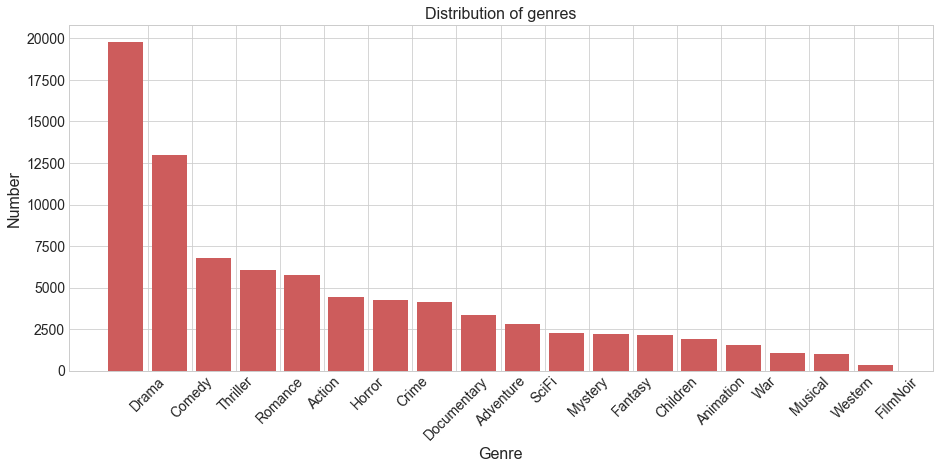

In [21]:
def relative(df):
    result = df[GenreAll].sum()
    x = np.arange(len(result.index))
    f = plt.figure(figsize=(15,6))
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.bar(x, result.sort_values(ascending=False).values ,color='indianred')
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(result.sort_values(ascending=False).index,rotation=45)
    plt.xlabel('Genre',fontsize=16)
    plt.ylabel('Number',fontsize=16)
    plt.title('Distribution of genres',fontsize=16)
    f.show()

relative(MovieGenre)

The above bar-plot shows the total number of movies for each genre. Drama and Comedy are the most dominant genres, which means that many people like watching movies of these genres, and so it is likely that producers try to make these types of films more frequently. Note that the total number of movies in the figure above is greater than the previous movie distribution plot because movies are counted multiple times if they have multiple genres. 

In [22]:
Rating.head(2)

userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435

In [23]:
MovieRating = pd.merge(MovieGenre,Rating,on='movieId')
MovieRating.head(3)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

       Title  Year  Action  Adventure  Animation  Children  Comedy  \
0  Toy Story  1995     0.0        1.0        1.0       1.0     1.0   
1  Toy Story  1995     0.0        1.0        1.0       1.0     1.0   
2  Toy Story  1995     0.0        1.0        1.0       1.0     1.0   

      ...      Musical  Mystery  Romance  SciFi  Thriller  War  Western  \
0     ...          0.0      0.0      0.0    0.0       0.0  0.0      0.0   
1     ...          0.0      0.0      0.0    0.0       0.0  0.0      0.0   
2     ...          0.0      0.0      0.0    0.0       0.0  0.0      0.0   

   userId  rating   timestamp  
0       8     4.0  1013443596  
1       9     4.5  1073837180  
2      12     4.0   943912205  

[3 rows x 26 columns]

The above table shows the combined datasets when I merge the movie table with the users and their ratings. Now, it is possible to track users behavior in their ratings. So, one way I could explore potential bias in a user's ratings is  to assess whether a fan of a certain genre will rate movies of that genre higher/lower than the general public. First we need to define what is a fan of a genre.

In [24]:
final = data_featuring(MovieRating)

Do some feature engineering, like counts of genres reviewed for each user... 


## Going forward, only include users who are in the top 50,000 most active (in terms of number of movie ratings)

In [25]:
top = 50000
final_top = final.sort_values('TotalNumber',ascending=False).head(top)

## How can we define a group of fans for each genre? 

Selecting the fans for each genre is a tough mission. In this project, I define fans for each genre as people who reviewed the specific genre more frequently compared to movies of other genres.
For example, considering a person (person A) reviewed 1,000 movies in the dataset, and person A reviewed 300 SciFi movies out of the 1,000 they reviewed. I would consider person A to be a fan of SciFi (For the average person, SciFi movies only account for 6% of the movies they rated).

I will explain in detail in the charts below.

## <font color='darkred'> <** Fraction of ratings as a function of genre for each user **></font>

--------------------------
\begin{equation}
Fraction = \frac{\textrm{Number}\; \textrm{of}\; \textrm{movies}\; \textrm{for}\; \textrm{each}\; \textrm{genre}}{\textrm{Total}\; \textrm{number}\; \textrm{of}\; \textrm{movies}\; \textrm{rated}}
\end{equation}
--------------------------

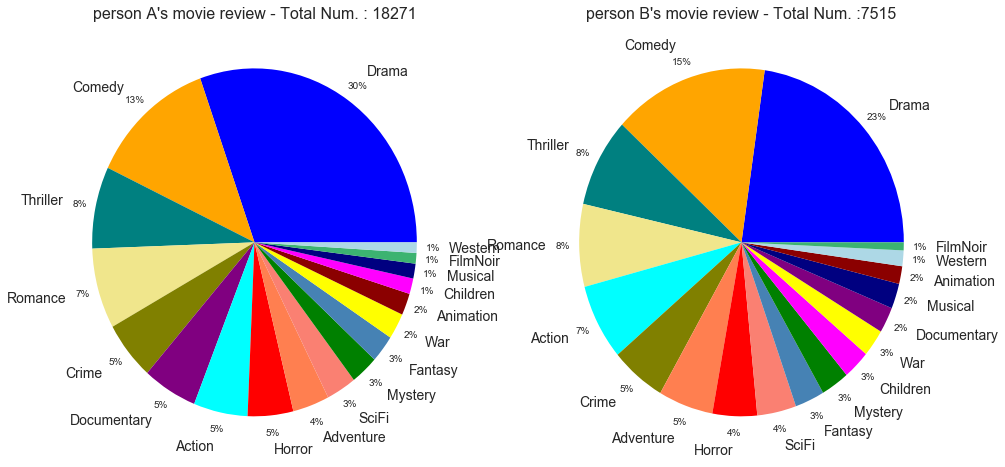

In [26]:
pie_fig(final_top[GenreAll],final_top['TotalNumber'])

The pie chart above is an example of two people's genre distributions for all the movies they rated. The reason why Drama and Comedy are more dominant than other genres is because there are many movies in these genres. The high fraction for drama and comedy does not neccesarily mean that they are fans of Drama or Comedy, but might simply reflect the fact that these genres are so prevalent. The charts above are pretty typical of an average users voting habits in the MovieLens database. 

Now, let's look at a few outliers. The chart below shows the rating distributions for people who appear to be fans of Horror movies.

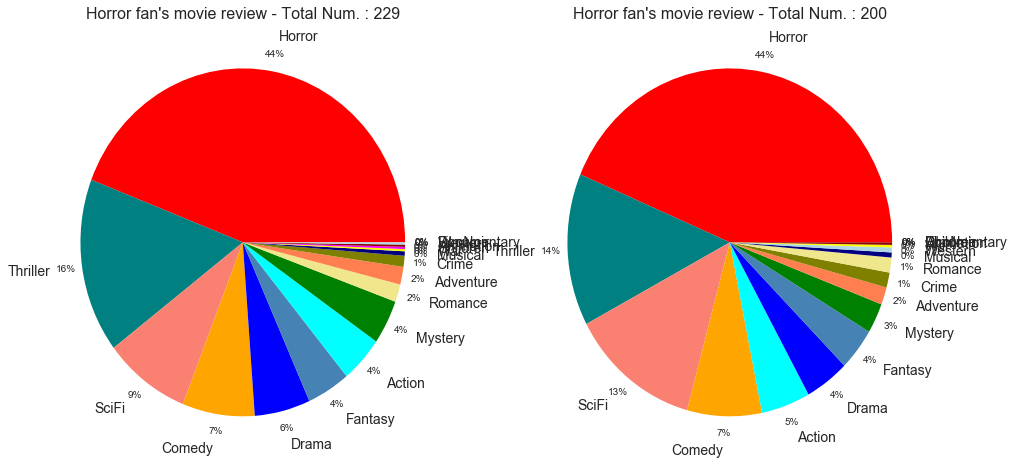

In [27]:
pie_fig_horror(final_top,final_top[GenreAll],final_top['TotalNumber'])

**Note that the UNUSUAL Horror fans rated far fewer movies than typical users in my samples.**
As seen in the chart above, the distribution is very different from the previous plots. In the case of these people, I will consider them to be fans of horror movies. 

I selected fans of each genre following the steps below:

1. Start by looking at the relative fraction of ratings by genre for the overall population. Then, it stands to reason that someone who is a fan of a certain genre, and who watches a disproportionately large fraction of movies in that genre, would rate movies in that genre more frequently than the average person does.

2. Look for outliers who rated movies of that genre at a much higher frequency than the overall population.

The box-plot below shows the typical range of percentages of certain genres that users reviewed.

Text(0.5,1,'Percent of reviews by genre for every user')

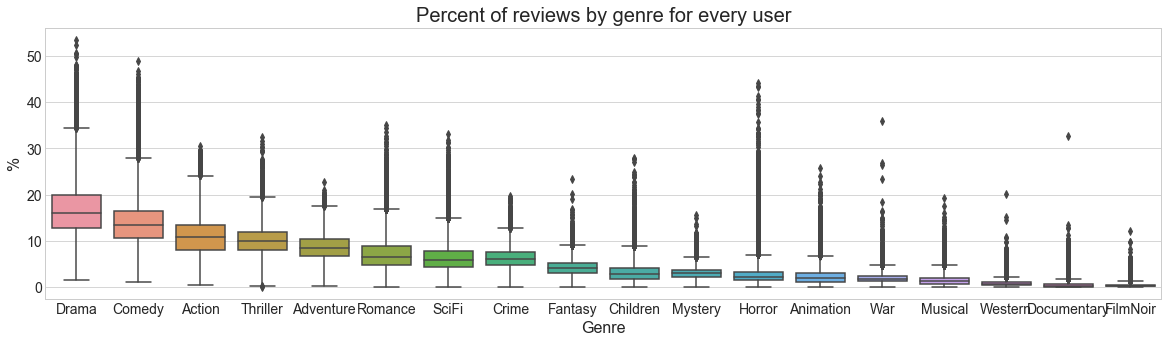

In [28]:
plt.figure(figsize=(20,5))
sns.boxplot(data=final_top[GenreAll]*100,orient='v',
            order=final_top[GenreAll].sum().sort_values(ascending=False).index,
           whis=2)
plt.ylabel('%',fontsize=16)
plt.xlabel('Genre',fontsize=16)
plt.title('Percent of reviews by genre for every user',size=20)

The colored boxes in the box-plot above highlight the 25%-75% range of the distribution for each genre that people reviewed. The upper whiskers corresponds to the top 1% of the distribution. 
Based on this information, I consider a fan to be a person who is identified as an outlier above the upper whiskers for each genre. For example, if someone has rated drama movies at more than 35%, I would define this person as a fan of drama (Look at the box graph for drama). Therefore, I chose 500 people (1% of total sample of 50,000) for each genre as the group of fans for that genre. 

**The following cleaning steps take a while to run, so I comment them out after running and saving the output.**

In [20]:
#top30_find(final_top,MovieRating)

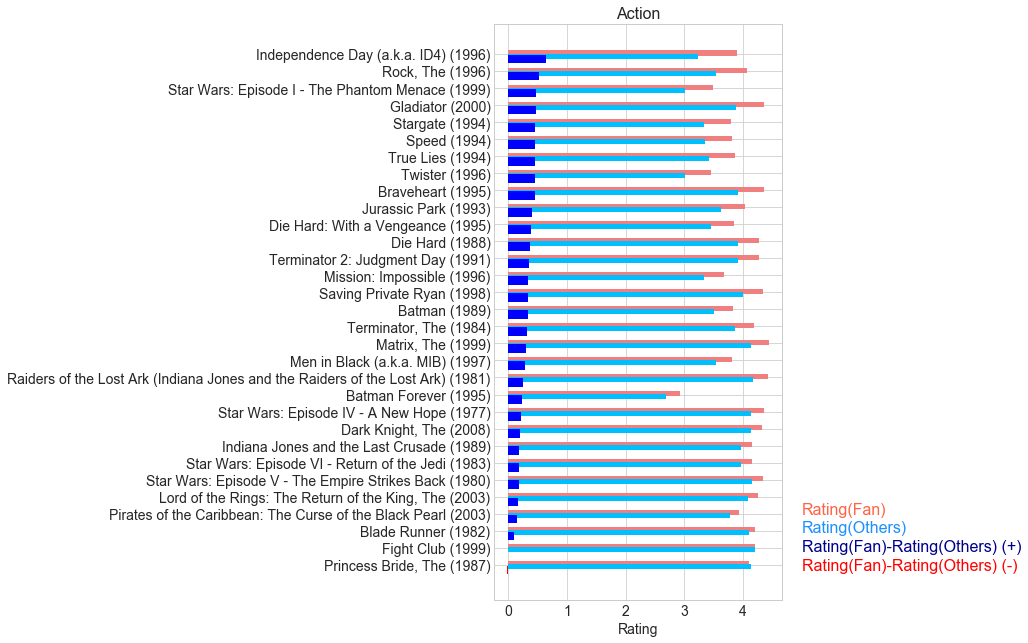

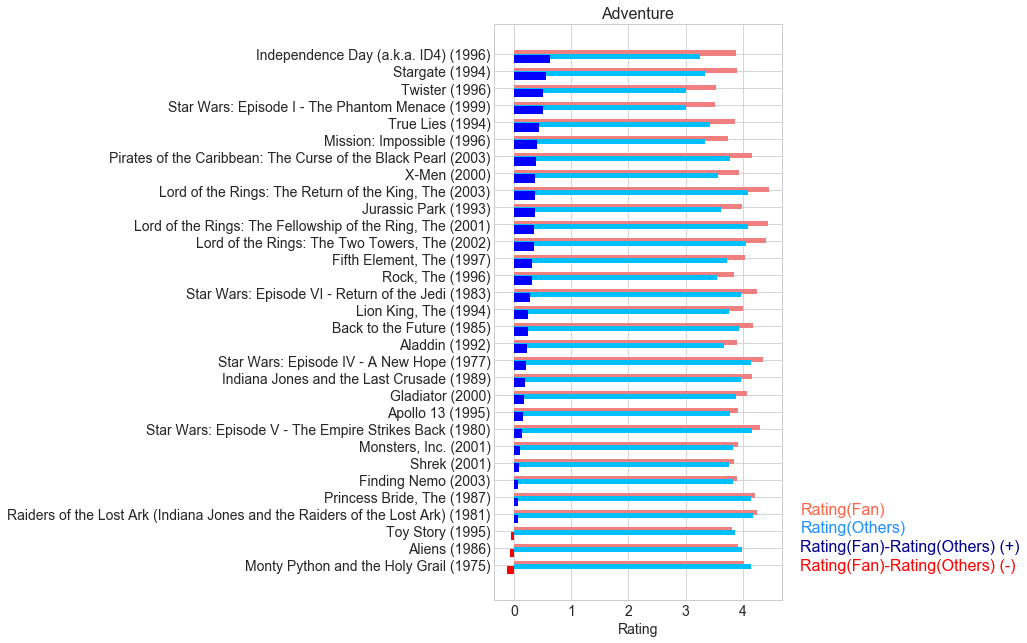

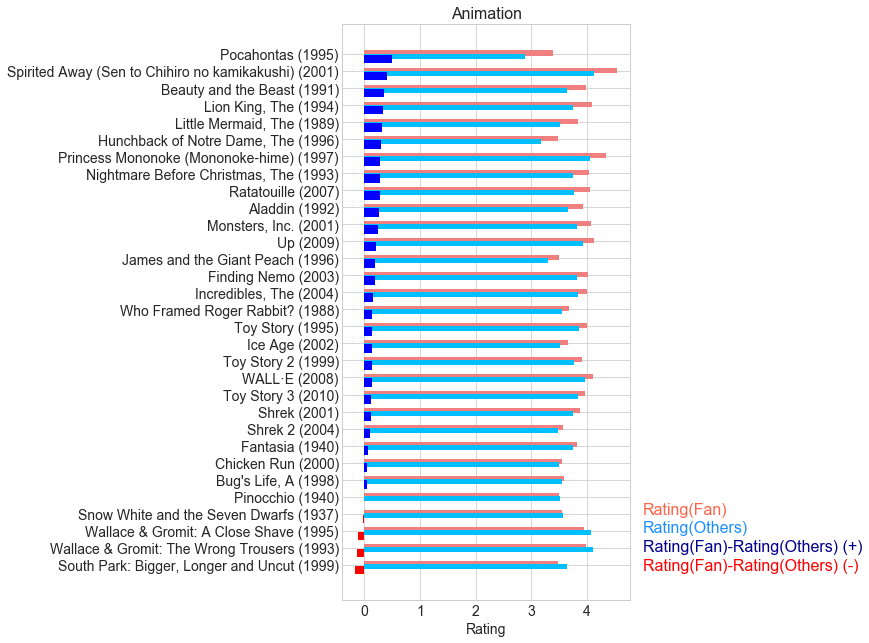

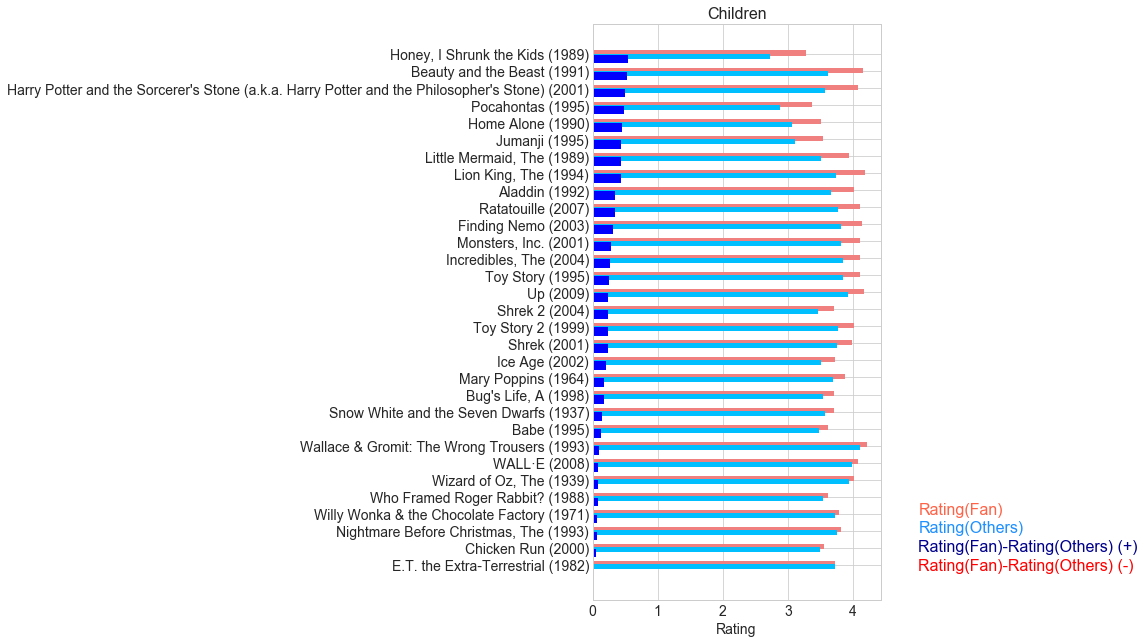

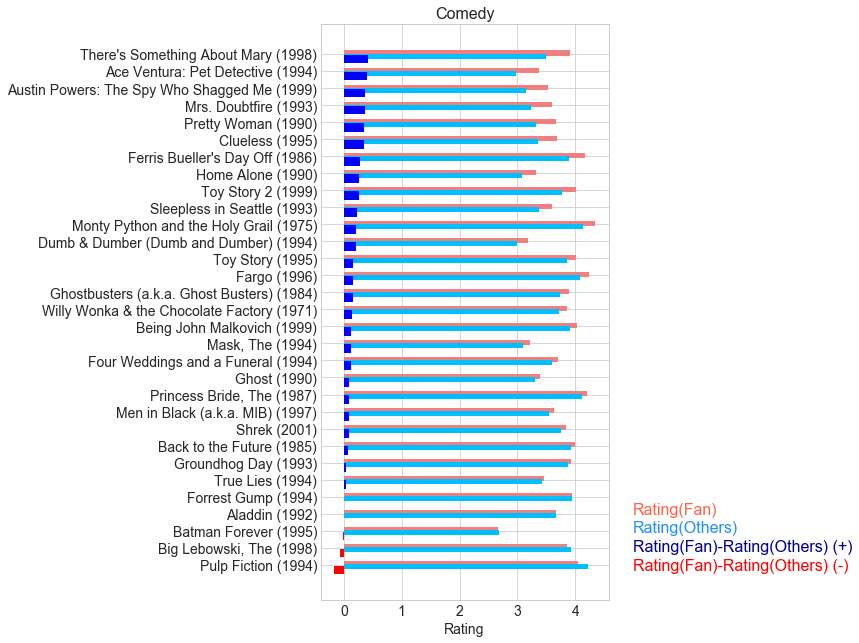

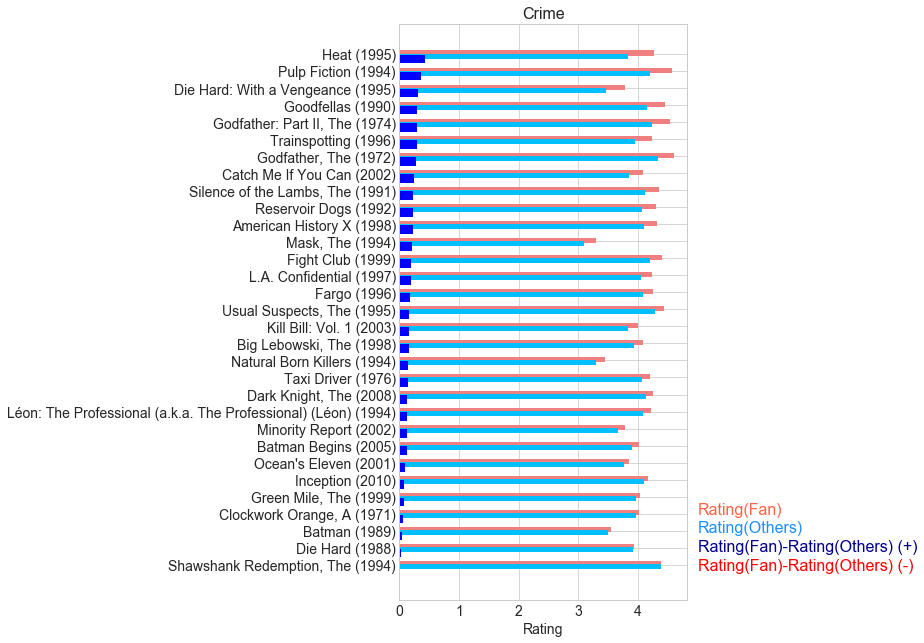

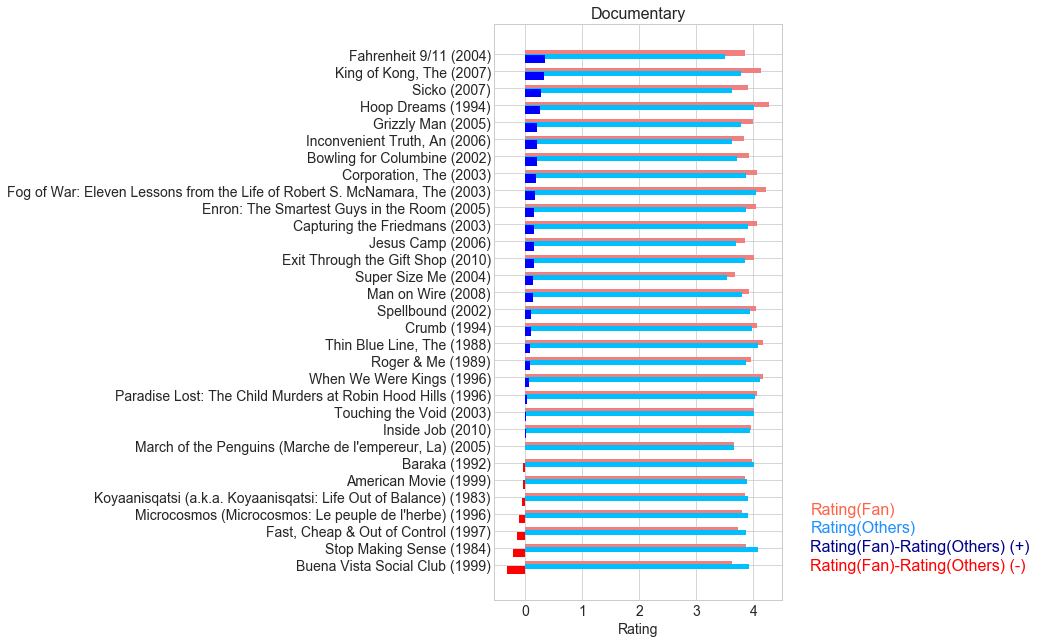

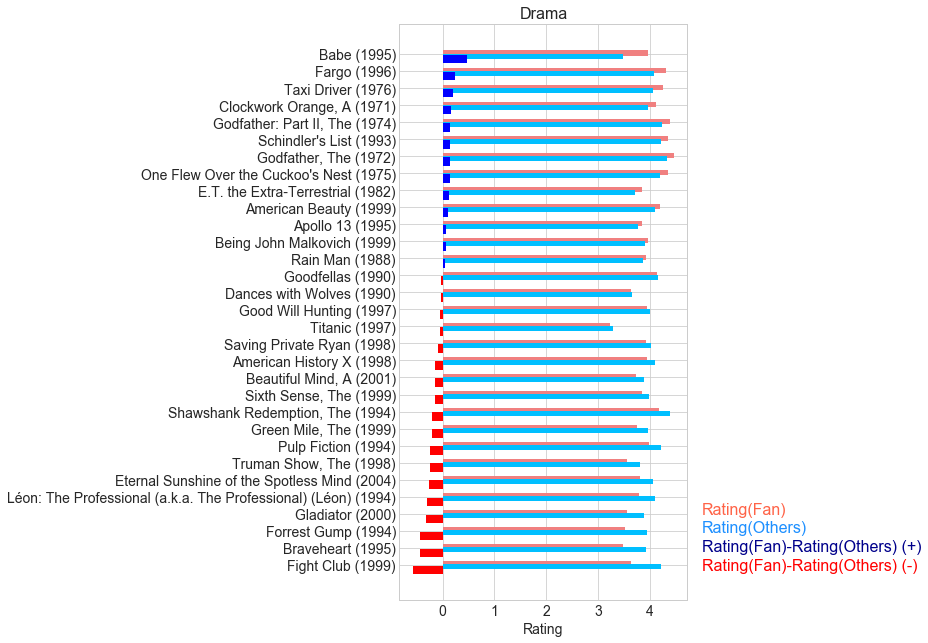

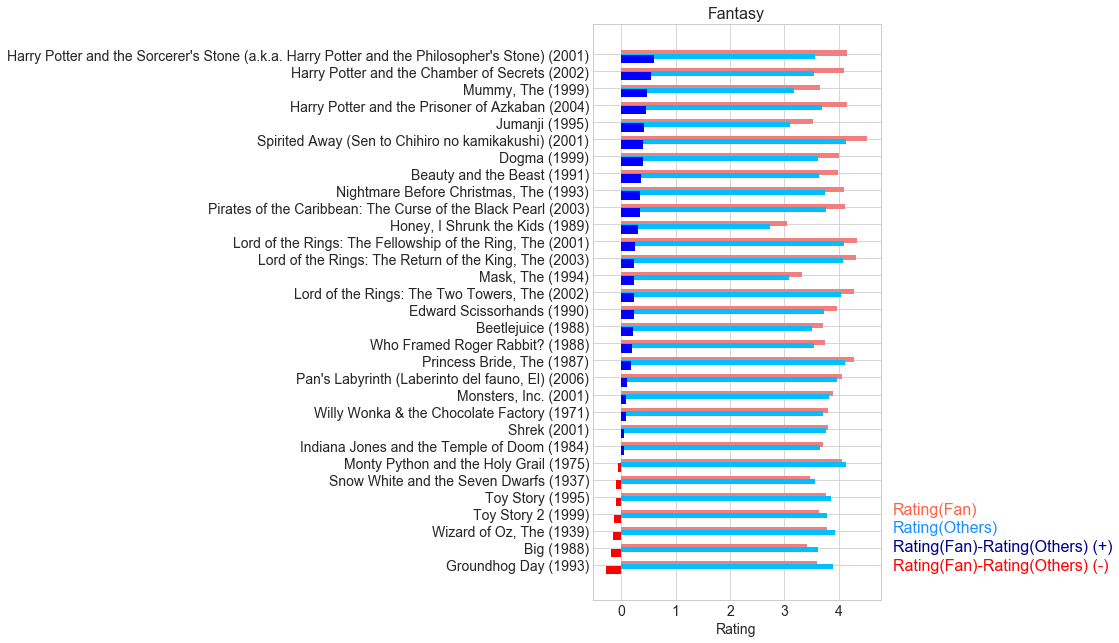

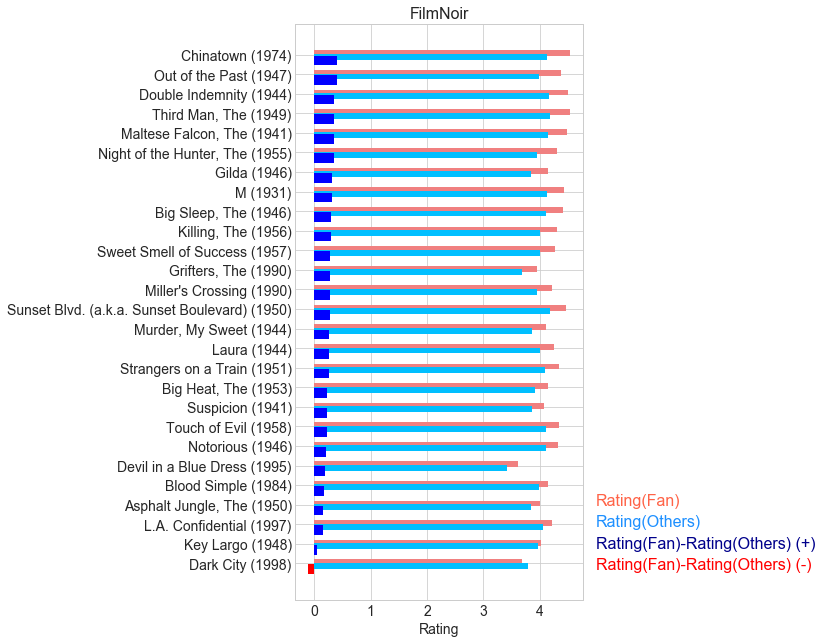

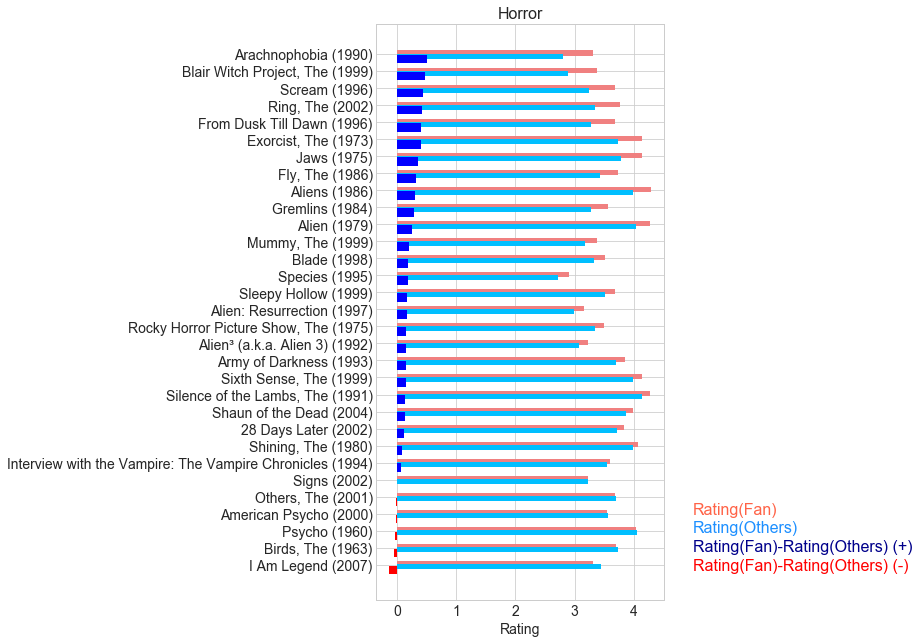

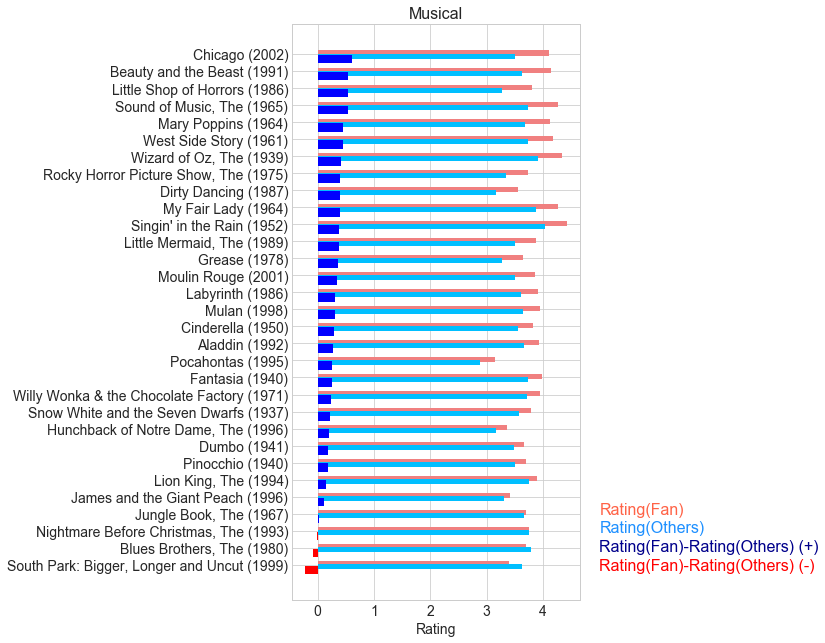

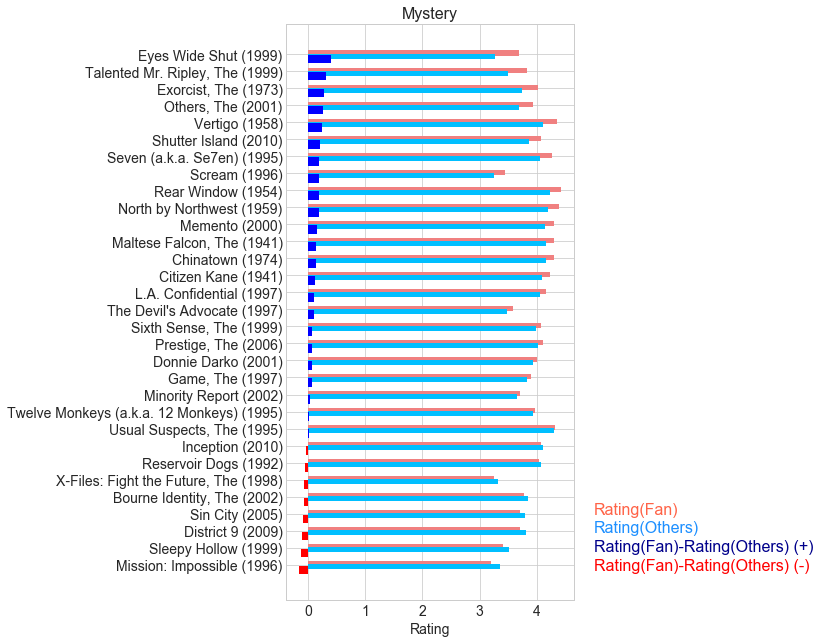

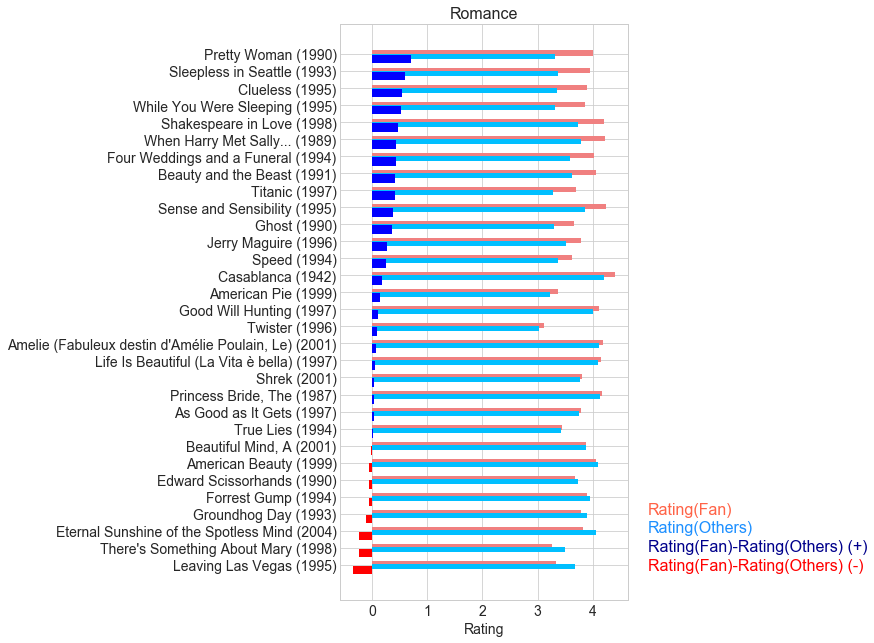

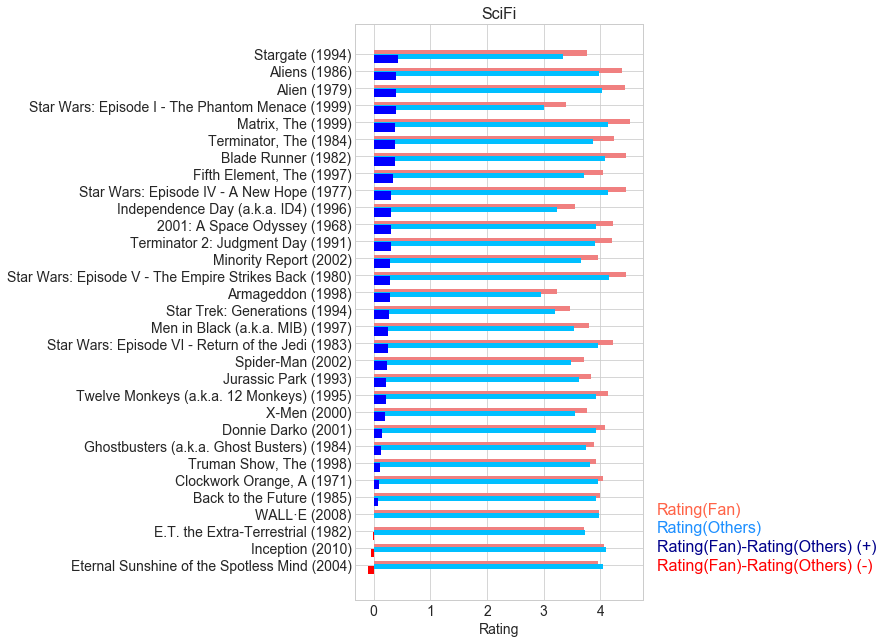

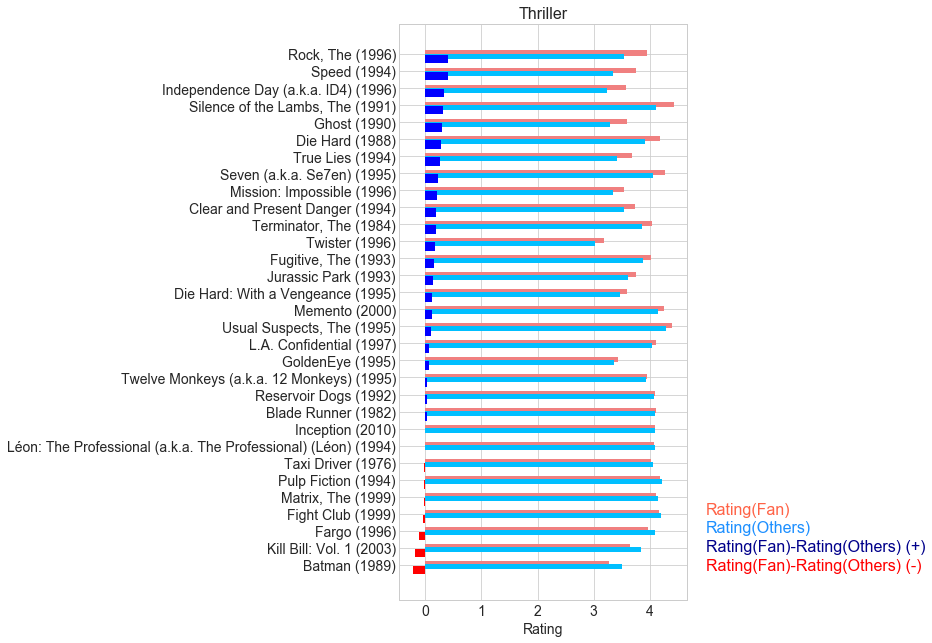

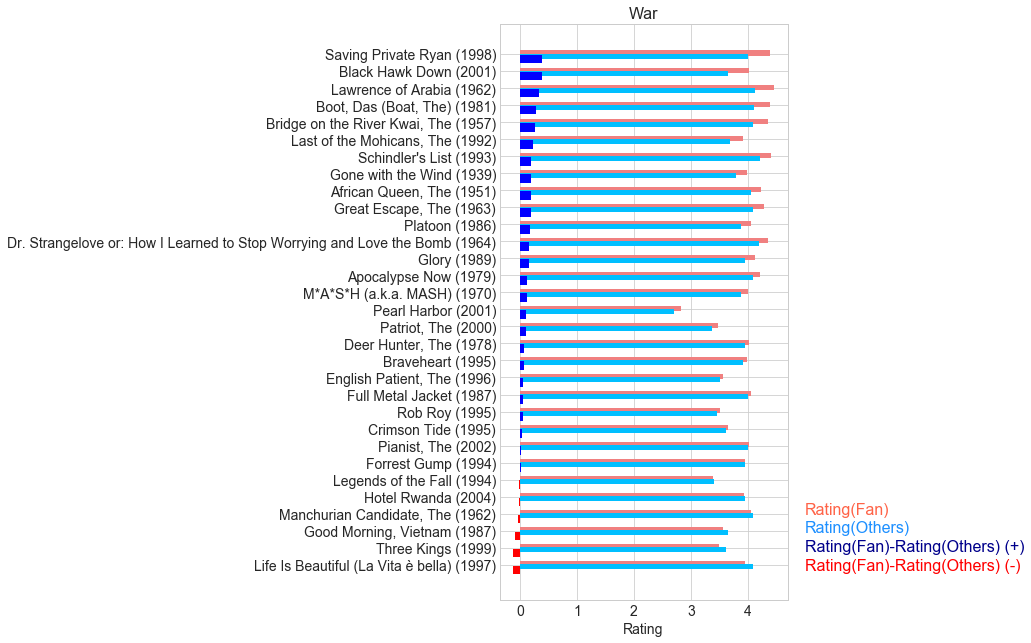

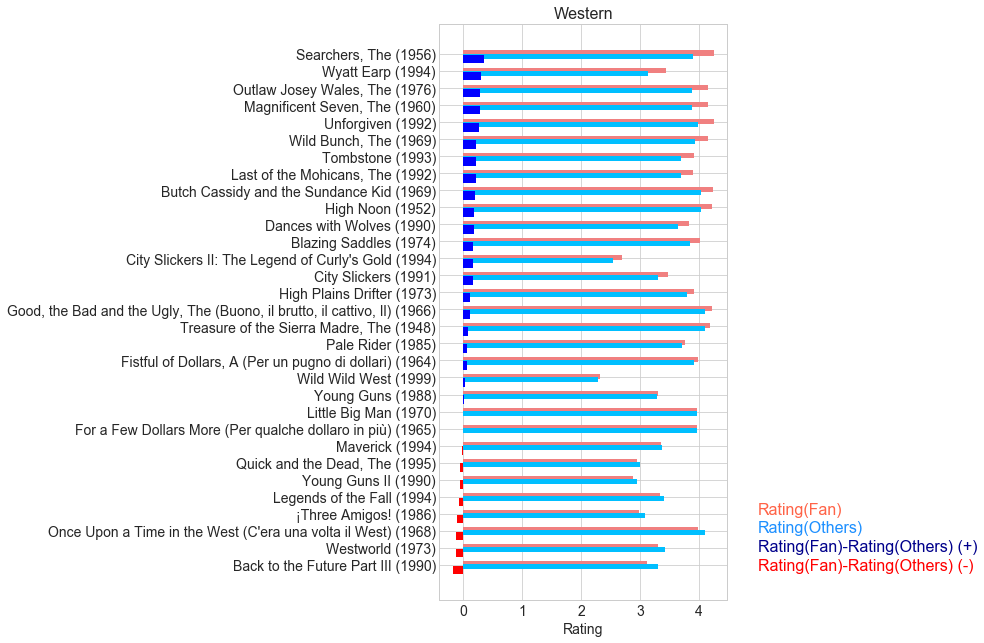

In [21]:
for i in GenreAll:
    name=i
    top30 = pd.read_csv(name+'.csv').T
    top30.columns = top30.columns.get_level_values(0)
    top30_plot(top30,name)
#    plt.savefig(name+'_plot.png')

From the figures above, it is clear that many movies overlap between different genres (**See the figures below**) and it is not always that easy to separate very similar genres from each other. Therefore, the best approach to analyze movie preferences might not be to try to separate each genre from each other genre, but to allow for correlations between genres to be included in the analysis. In the following section, I will explore an alternate technique using **Principal Component Analysis (PCA)** and **K-means clustering**.

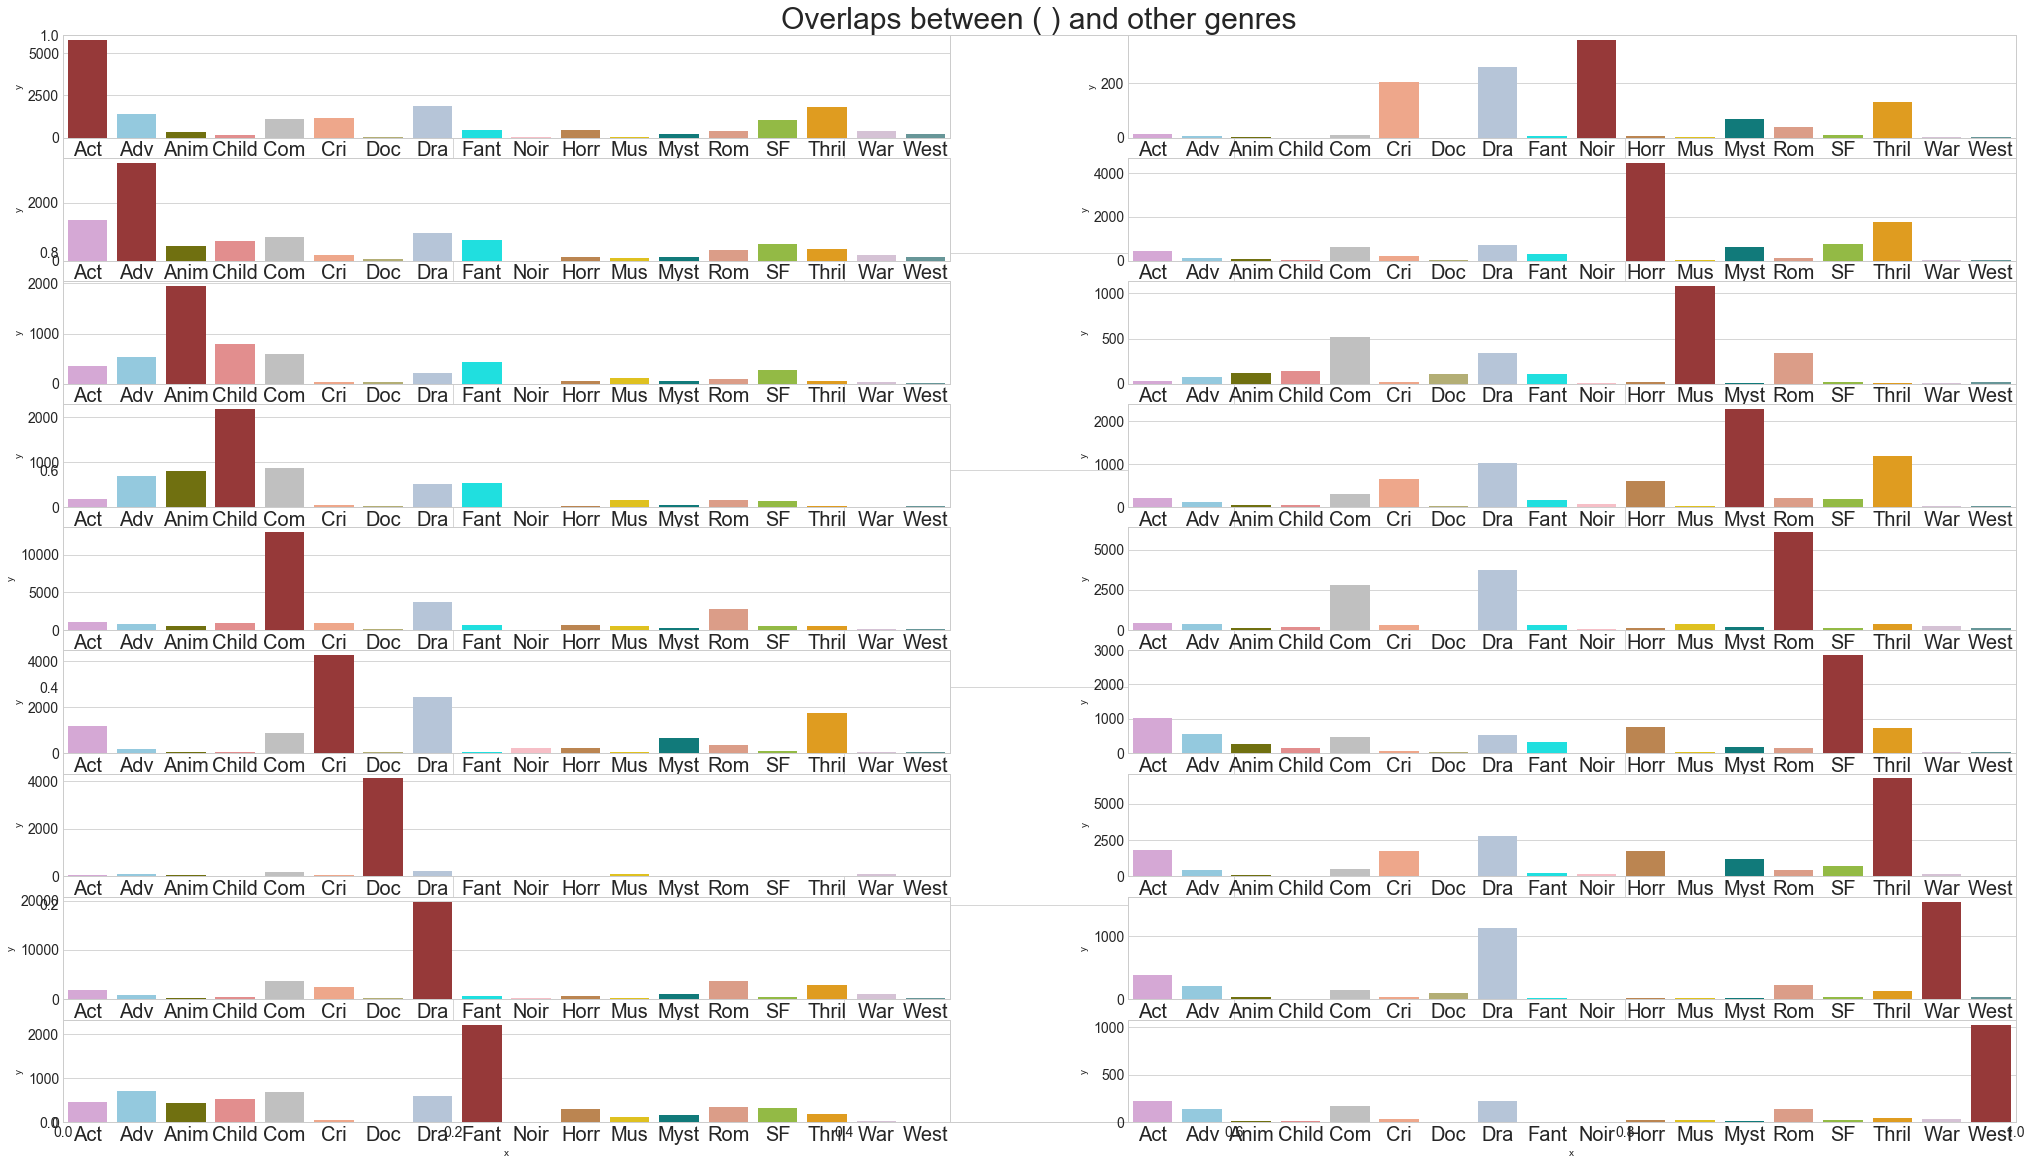

In [29]:
overall_plot(MovieGenre)

## Let's examine any correlations between the ratings of different genres

Text(0.5,1,'Correlation')

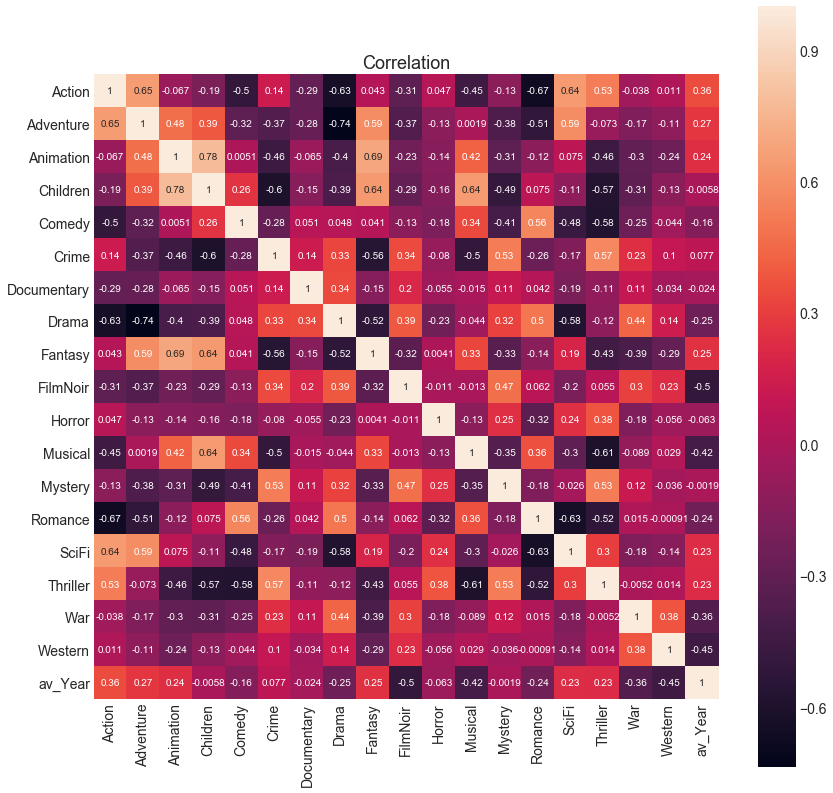

In [30]:
corr = final_top[incl_year].corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, vmax=1, square=True,annot=True)
plt.title('Correlation',fontsize=18)

### The correlation matrix heatmap above reveals some fundamental characteristics of movies and user preferences that are worth explaining, namely:

- **Strong correlations** exist between: 
 - Action & Adventure
 - Action & SciFi
 - Animation & Children
 - Animation & Fantasy
 - Adventure & Fantasy
 - Children & Fantasy
- **Strong anti-correlations** exist between:
 - Action & Drama
 - Action & Romance
 - Adventure & Drama
 - Children & Crime
 - Musical & Thriller
- Correlations and anti-correlations with **av_Year** shows which genres tend to be more common in recent years (Action, Adventure, Fantasy, SciFi, and Thriller) and which genres had their heyday in the past (Film Noir, Musical, War, and Western), respectively.

### Let's examine the genre preferences in a more quantitative statistical way, using Principal Component Analysis (PCA)

I take the matrix of users (rows) and number of reviews by genre (columns) and perform a decomposition of that matrix into the sum of eigenvectors times corresponding eigenvalues. This has the effect of re-casting the matrix into a set of orthogonal axes, and when I sort those eigenmodes from the largest (absolute value) eigenvalue to smallest, the first couple of eigenmodes each correspond to the axes along which we find the greatest variance in our data. 

The result, plotted blow for the top two eigenmodes, shows how each of them naturally corresponds to some of the most fundamental divides between user preferences in genres (where we see weights of some genres having similar or opposing signs)

Do preprocessing for PCA plot... 


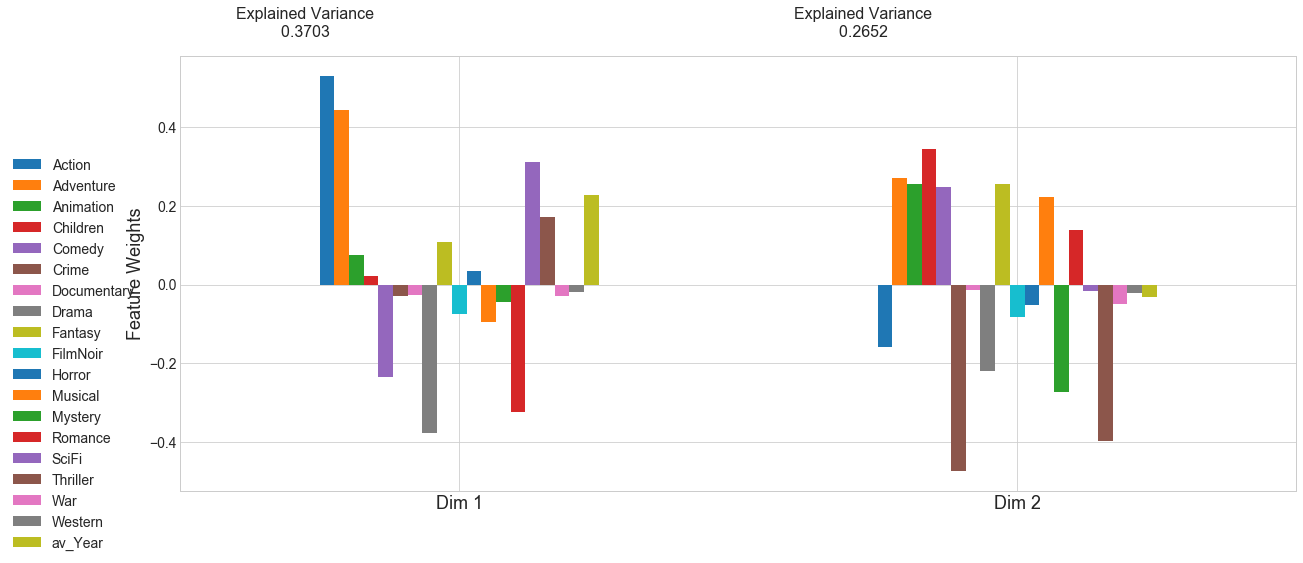

In [31]:
pca_plot(final_top[incl_year],2)

<img src="img/pca_poster.jpg">

The **upper-left** of the figure above corresponds to strong weights for Action, Adventure, Fantasy, and SciFi, while the **lower-left** features the strongest weights for Drama and Romance. This dichotomy represents the most significant single divide in the user movie preferences, and it's surely one of the most obvious broad divides between types of films. 

The **upper-right** is dominated by Children, Musical, Animation, and Romance while the **lower-right** is Thriller, Crime, Action, and Mystery. This second dimension apparently separates light-hearted films aimed at children from more gritty, often violent movies geared towards adults.

Apply PCA... 


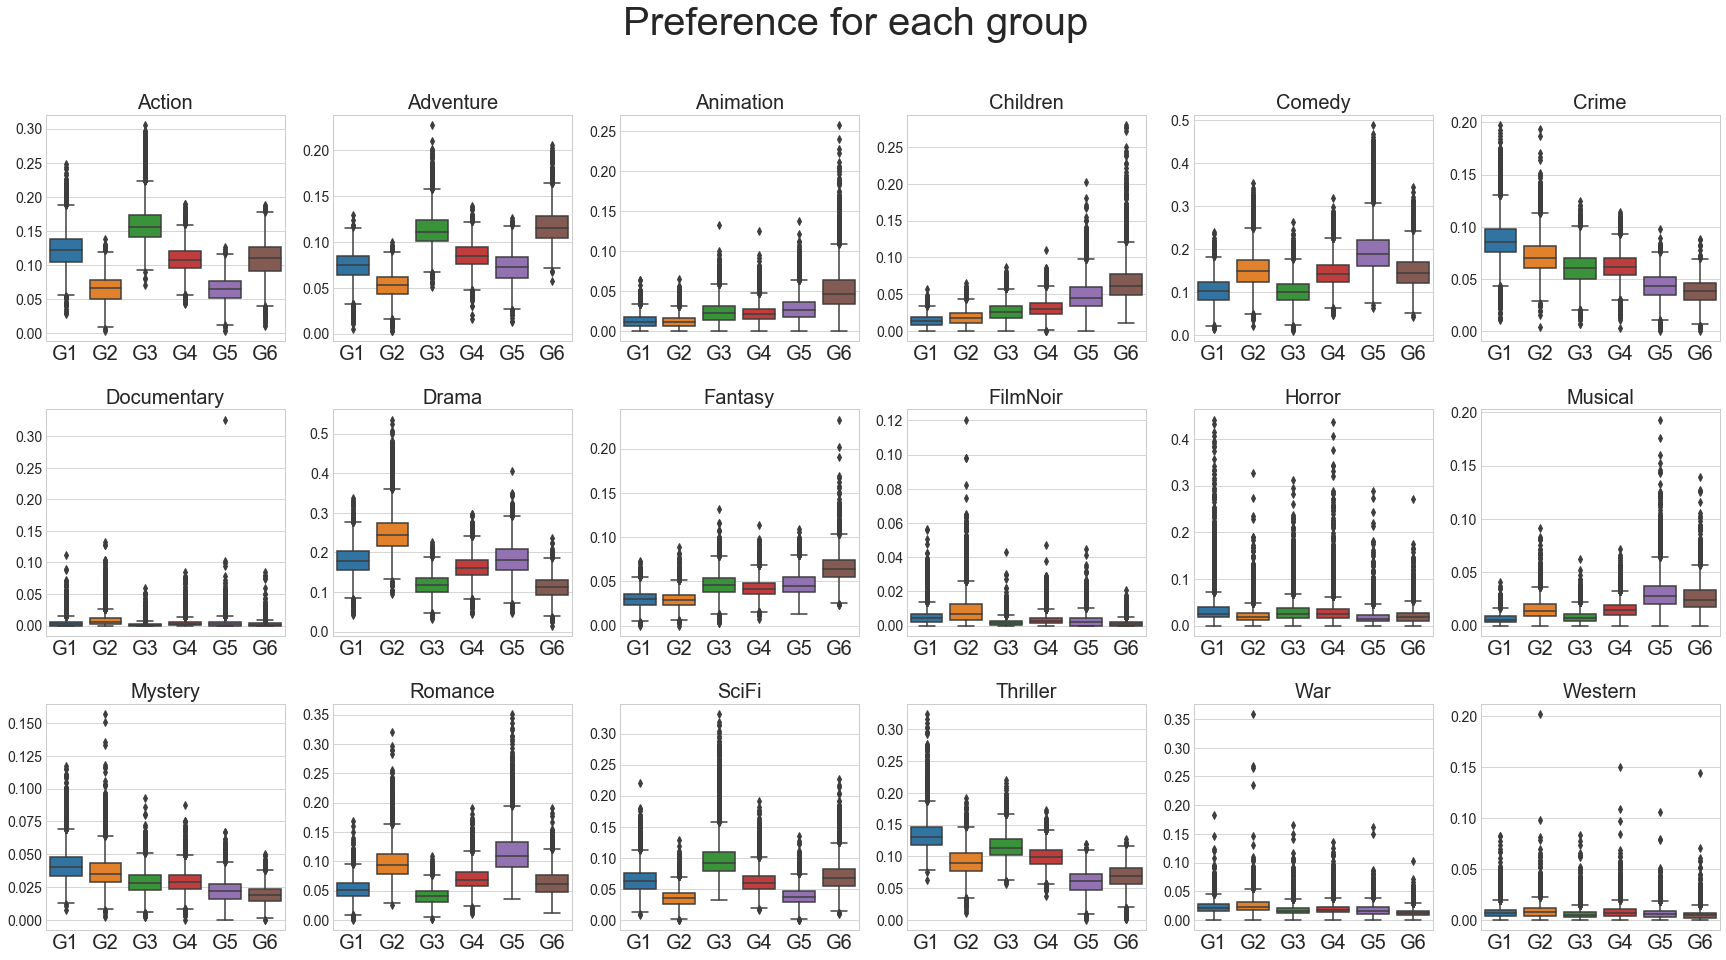

In [32]:
reduced_data = pca_function(final_top[incl_year],2)
#check_kmean(reduced_data,8)
kmeans = KMeans(n_clusters=6,random_state=2300).fit(reduced_data)
final_top['group'] = kmeans.labels_
reduced_data['group'] = kmeans.labels_
new = final_top.groupby('group').median()
new.to_csv('dist.csv')

fig = plt.figure(figsize=(30,15))
fig.suptitle("Preference for each group", fontsize=40)
for i in range(len(GenreAll)):
    ax = fig.add_subplot(len(GenreAll)/6,6,i+1)
    sns.boxplot(data=final_top,x='group',y=GenreAll[i])
    ax.set_xticklabels(['G1','G2','G3','G4','G5','G6'], rotation=0, fontsize=20)
    plt.ylabel('',fontsize=10)
    plt.xlabel('',fontsize=10)
    plt.title(GenreAll[i],fontsize=20)
plt.subplots_adjust(hspace=0.3,wspace=0.2)
#fig.tight_layout()

- <font color='darkblue'> Group 1 <strong>(Action Police)</strong>: Crime, Thriller, Mystery </font>

- <font color='darkorange'> Group 2 <strong>(Gritty Crime Drama)</strong>: Documentary, Drama, FilmNoir </font>

- <font color='green'> Group 3 <strong>(Blockbuster Action)</strong>: Action, Adventure, SciFi </font>  

- <font color='red'> Group 4 <strong>(General)</strong>: ... </font>

- <font color='purple'> Group 5 <strong>(Rom-Com)</strong>: Comedy, Drama, Romance, Musical </font>

- <font color='brown'> Group 6 <strong>(Light Hearted Family)</strong>: Adventure, Animation, Children, Fantasy </font>

**The following cleaning steps take a while to run, so I comment them out after running and saving the output.**

In [164]:
MovieRatingShort = MovieRating[['title','userId','rating']]
group_final = pd.DataFrame(columns=['title','group','Number','mean'])
movie_name = MovieGenre.title.values
n=0
for j in range(len(movie_name)):
    submovie = MovieRatingShort[MovieRatingShort['title']==movie_name[j]]
    for k in range(6):
        user_index =pd.DataFrame(final_top[final_top['group']==k].index)
        user_submovie = pd.merge(submovie,user_index,on='userId')
        count = len(user_submovie)
        mean = user_submovie.rating.mean()
        group_final.loc[n]=[movie_name[j],k,count,mean]
        n+=1
    print(str(j)+' : '+movie_name[j])
group_final.to_csv('result_pca1.csv')

0 : Toy Story (1995)
1 : Jumanji (1995)
2 : Grumpier Old Men (1995)
3 : Waiting to Exhale (1995)
4 : Father of the Bride Part II (1995)
5 : Heat (1995)
6 : Sabrina (1995)
7 : Tom and Huck (1995)
8 : Sudden Death (1995)
9 : GoldenEye (1995)
10 : American President, The (1995)
11 : Dracula: Dead and Loving It (1995)
12 : Balto (1995)
13 : Nixon (1995)
14 : Cutthroat Island (1995)
15 : Casino (1995)
16 : Sense and Sensibility (1995)
17 : Four Rooms (1995)
18 : Ace Ventura: When Nature Calls (1995)
19 : Money Train (1995)
20 : Get Shorty (1995)
21 : Copycat (1995)
22 : Assassins (1995)
23 : Powder (1995)
24 : Leaving Las Vegas (1995)
25 : Othello (1995)
26 : Now and Then (1995)
27 : Persuasion (1995)
28 : City of Lost Children, The (Cité des enfants perdus, La) (1995)
29 : Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
30 : Dangerous Minds (1995)
31 : Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
32 : Wings of Courage (1995)
33 : Babe (1995)
34 : Carrington (1995)
35 : Dead Man Walking (

267 : Love Affair (1994)
268 : Losing Isaiah (1995)
269 : Madness of King George, The (1994)
270 : Mary Shelley's Frankenstein (Frankenstein) (1994)
271 : Man of the House (1995)
272 : Mixed Nuts (1994)
273 : Milk Money (1994)
274 : Miracle on 34th Street (1994)
275 : Miami Rhapsody (1995)
276 : My Family (1995)
277 : Murder in the First (1995)
278 : Nobody's Fool (1994)
279 : Nell (1994)
280 : New Jersey Drive (1995)
281 : New York Cop (Nyû Yôku no koppu) (1993)
282 : Beyond Bedlam (1993)
283 : Nemesis 2: Nebula (1995)
284 : Nina Takes a Lover (1994)
285 : Natural Born Killers (1994)
286 : Only You (1994)
287 : Once Were Warriors (1994)
288 : Poison Ivy II (1996)
289 : Outbreak (1995)
290 : Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
291 : Perez Family, The (1995)
292 : Pyromaniac's Love Story, A (1995)
293 : Pulp Fiction (1994)
294 : Panther (1995)
295 : Pushing Hands (Tui shou) (1992)
296 : Priest (1994)
297 : Quiz Show (1994)
298 : Picture Bride (Bijo photo) (199

527 : Secret Garden, The (1993)
528 : Serial Mom (1994)
529 : Shadow, The (1994)
530 : Shadowlands (1993)
531 : Short Cuts (1993)
532 : Simple Twist of Fate, A (1994)
533 : Sirens (1994)
534 : Six Degrees of Separation (1993)
535 : Sleepless in Seattle (1993)
536 : Sliver (1993)
537 : Blade Runner (1982)
538 : Son in Law (1993)
539 : So I Married an Axe Murderer (1993)
540 : Striking Distance (1993)
541 : Harem (1985)
542 : Super Mario Bros. (1993)
543 : Surviving the Game (1994)
544 : Terminal Velocity (1994)
545 : Thirty-Two Short Films About Glenn Gould (1993)
546 : Threesome (1994)
547 : Nightmare Before Christmas, The (1993)
548 : Three Musketeers, The (1993)
549 : Tombstone (1993)
550 : Trial by Jury (1994)
551 : True Romance (1993)
552 : War Room, The (1993)
553 : Pagemaster, The (1994)
554 : Paris, France (1993)
555 : Beans of Egypt, Maine, The (1994)
556 : Killer (Bulletproof Heart) (1994)
557 : Welcome to the Dollhouse (1995)
558 : Germinal (1993)
559 : Chasers (1994)
560 : C

776 : I, the Worst of All (Yo, la peor de todas) (1990)
777 : Unforgettable Summer, An (Un été inoubliable) (1994)
778 : Last Klezmer: Leopold Kozlowski, His Life and Music, The (1994)
779 : Hungarian Fairy Tale, A (Hol volt, hol nem volt) (1987)
780 : My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993)
781 : Midnight Dancers (Sibak) (1994)
782 : Somebody to Love (1994)
783 : Very Natural Thing, A (1974)
784 : Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)
785 : Daylight (1996)
786 : Frighteners, The (1996)
787 : Lone Star (1996)
788 : Harriet the Spy (1996)
789 : Phenomenon (1996)
790 : Walking and Talking (1996)
791 : She's the One (1996)
792 : Time to Kill, A (1996)
793 : American Buffalo (1996)
794 : Rendezvous in Paris (Rendez-vous de Paris, Les) (1995)
795 : Alaska (1996)
796 : Fled (1996)
797 : Kazaam (1996)
798 : Magic Hunter (Büvös vadász) (1994)
799 : Larger Than Life (1996)
800 : Boy Called Hate, A (1995)
801 : Powe

1025 : Surviving Picasso (1996)
1026 : Love Is All There Is (1996)
1027 : Beautiful Thing (1996)
1028 : Long Kiss Goodnight, The (1996)
1029 : Ghost and the Darkness, The (1996)
1030 : Looking for Richard (1996)
1031 : Trees Lounge (1996)
1032 : Proprietor, The (1996)
1033 : Normal Life (1996)
1034 : Get on the Bus (1996)
1035 : Shadow Conspiracy (1997)
1036 : Jude (1996)
1037 : Everyone Says I Love You (1996)
1038 : Bitter Sugar (Azúcar amarga) (1996)
1039 : William Shakespeare's Romeo + Juliet (1996)
1040 : Swingers (1996)
1041 : Sleepers (1996)
1042 : Sunchaser, The (1996)
1043 : Johns (1996)
1044 : Aladdin and the King of Thieves (1996)
1045 : Five Angles on Murder (1950)
1046 : Shall We Dance (1937)
1047 : Damsel in Distress, A (1937)
1048 : Crossfire (1947)
1049 : Murder, My Sweet (1944)
1050 : Macao (1952)
1051 : For the Moment (1994)
1052 : Willy Wonka & the Chocolate Factory (1971)
1053 : Sexual Life of the Belgians, The (Vie sexuelle des Belges 1950-1978, La) (1994)
1054 : In

1262 : Some Kind of Wonderful (1987)
1263 : Indiana Jones and the Last Crusade (1989)
1264 : Being There (1979)
1265 : Gandhi (1982)
1266 : Unbearable Lightness of Being, The (1988)
1267 : Room with a View, A (1986)
1268 : Real Genius (1985)
1269 : Pink Floyd: The Wall (1982)
1270 : Killing Fields, The (1984)
1271 : My Life as a Dog (Mitt liv som hund) (1985)
1272 : Forbidden Planet (1956)
1273 : Field of Dreams (1989)
1274 : Man Who Would Be King, The (1975)
1275 : Butch Cassidy and the Sundance Kid (1969)
1276 : Paris, Texas (1984)
1277 : Until the End of the World (Bis ans Ende der Welt) (1991)
1278 : When Harry Met Sally... (1989)
1279 : I Shot a Man in Vegas (1995)
1280 : Parallel Sons (1995)
1281 : Hype! (1996)
1282 : Santa with Muscles (1996)
1283 : Female Perversions (1996)
1284 : Mad Dog Time (1996)
1285 : Breathing Room (1996)
1286 : Paris Was a Woman (1995)
1287 : Anna (1996)
1288 : I'm Not Rappaport (1996)
1289 : Blue Juice (1995)
1290 : Kids of Survival (1996)
1291 : Alien

1510 : Wedding Bell Blues (1996)
1511 : Batman & Robin (1997)
1512 : Dream With the Fishes (1997)
1513 : For Roseanna (Roseanna's Grave) (1997)
1514 : Head Above Water (1996)
1515 : Hercules (1997)
1516 : The Last Time I Committed Suicide (1997)
1517 : MURDER and murder (1996)
1518 : My Best Friend's Wedding (1997)
1519 : Tetsuo II: Body Hammer (1992)
1520 : When the Cat's Away (Chacun cherche son chat) (1996)
1521 : Contempt (Mépris, Le) (1963)
1522 : Face/Off (1997)
1523 : Fall (1997)
1524 : Gabbeh (1996)
1525 : Mondo (1996)
1526 : Innocent Sleep, The (1996)
1527 : For Ever Mozart (1996)
1528 : Men in Black (a.k.a. MIB) (1997)
1529 : Out to Sea (1997)
1530 : Wild America (1997)
1531 : Simple Wish, A (1997)
1532 : Contact (1997)
1533 : Love Serenade (1996)
1534 : G.I. Jane (1997)
1535 : Conan the Barbarian (1982)
1536 : George of the Jungle (1997)
1537 : Cop Land (1997)
1538 : Event Horizon (1997)
1539 : Spawn (1997)
1540 : Air Bud (1997)
1541 : Picture Perfect (1997)
1542 : In the Co

1778 : Character (Karakter) (1997)
1779 : Junk Mail (Budbringeren) (1997)
1780 : Species II (1998)
1781 : Major League: Back to the Minors (1998)
1782 : Sour Grapes (1998)
1783 : Wild Man Blues (1997)
1784 : Big Hit, The (1998)
1785 : Tarzan and the Lost City (1998)
1786 : Black Dog (1998)
1787 : Dancer, Texas Pop. 81 (1998)
1788 : Friend of the Deceased, A (Priyatel pokonika) (1997)
1789 : Go Now (1995)
1790 : Misérables, Les (1998)
1791 : Still Breathing (1997)
1792 : Clockwatchers (1997)
1793 : Deep Impact (1998)
1794 : Little Men (1998)
1795 : Woo (1998)
1796 : Hanging Garden, The (1997)
1797 : Lawn Dogs (1997)
1798 : Quest for Camelot (1998)
1799 : Godzilla (1998)
1800 : Bulworth (1998)
1801 : Fear and Loathing in Las Vegas (1998)
1802 : Opposite of Sex, The (1998)
1803 : I Got the Hook Up (1998)
1804 : Almost Heroes (1998)
1805 : Hope Floats (1998)
1806 : Insomnia (1997)
1807 : Little Boy Blue (1997)
1808 : Ugly, The (1997)
1809 : Perfect Murder, A (1998)
1810 : Beyond Silence (J

2017 : Splash (1984)
2018 : Squanto: A Warrior's Tale (1994)
2019 : Steamboat Willie (1928)
2020 : Tall Tale (1995)
2021 : Tex (1982)
2022 : Tron (1982)
2023 : Swing Kids (1993)
2024 : Halloween H20: 20 Years Later (Halloween 7: The Revenge of Laurie Strode) (1998)
2025 : L.A. Story (1991)
2026 : Jerk, The (1979)
2027 : Dead Men Don't Wear Plaid (1982)
2028 : Man with Two Brains, The (1983)
2029 : Grand Canyon (1991)
2030 : Graveyard Shift (Stephen King's Graveyard Shift) (1990)
2031 : Outsiders, The (1983)
2032 : Indiana Jones and the Temple of Doom (1984)
2033 : Lord of the Rings, The (1978)
2034 : 1984 (Nineteen Eighty-Four) (1984)
2035 : Dead Zone, The (1983)
2036 : Maximum Overdrive (1986)
2037 : Needful Things (1993)
2038 : Cujo (1983)
2039 : Children of the Corn (1984)
2040 : All Dogs Go to Heaven (1989)
2041 : Addams Family, The (1991)
2042 : Ever After: A Cinderella Story (1998)
2043 : Snake Eyes (1998)
2044 : First Love, Last Rites (1997)
2045 : Safe Men (1998)
2046 : Saltmen

2271 : Bug's Life, A (1998)
2272 : Celebrity (1998)
2273 : Central Station (Central do Brasil) (1998)
2274 : Savior (1998)
2275 : Waking Ned Devine (a.k.a. Waking Ned) (1998)
2276 : Celebration, The (Festen) (1998)
2277 : Pink Flamingos (1972)
2278 : Glen or Glenda (1953)
2279 : Godzilla (Gojira) (1954)
2280 : Godzilla 1985: The Legend Is Reborn (Gojira) (Godzilla) (Return of Godzilla, The) (1984)
2281 : King Kong vs. Godzilla (Kingukongu tai Gojira) (1962)
2282 : King Kong (1933)
2283 : King Kong (1976)
2284 : King Kong Lives (1986)
2285 : Desperately Seeking Susan (1985)
2286 : Emerald Forest, The (1985)
2287 : Fletch (1985)
2288 : Fletch Lives (1989)
2289 : Red Sonja (1985)
2290 : Gung Ho (1986)
2291 : Money Pit, The (1986)
2292 : View to a Kill, A (1985)
2293 : Lifeforce (1985)
2294 : Police Academy (1984)
2295 : Police Academy 2: Their First Assignment (1985)
2296 : Police Academy 3: Back in Training (1986)
2297 : Police Academy 4: Citizens on Patrol (1987)
2298 : Police Academy 5

2520 : Let it Come Down: The Life of Paul Bowles (1998)
2521 : Entrapment (1999)
2522 : Idle Hands (1999)
2523 : Get Real (1998)
2524 : Heaven (1998)
2525 : King of Masks, The (Bian Lian) (1996)
2526 : Three Seasons (1999)
2527 : Winslow Boy, The (1999)
2528 : Mildred Pierce (1945)
2529 : Night of the Comet (1984)
2530 : Chopping Mall (a.k.a. Killbots) (1986)
2531 : My Science Project (1985)
2532 : Dick Tracy (1990)
2533 : Mummy, The (1999)
2534 : Castle, The (1997)
2535 : Mascara (1999)
2536 : This Is My Father (1998)
2537 : Xiu Xiu: The Sent-Down Girl (Tian yu) (1998)
2538 : William Shakespeare's A Midsummer Night's Dream (1999)
2539 : Trippin' (1999)
2540 : After Life (Wandafuru raifu) (1998)
2541 : Black Mask (Hak hap) (1996)
2542 : Edge of Seventeen (1998)
2543 : Endurance (1999)
2544 : Star Wars: Episode I - The Phantom Menace (1999)
2545 : Love Letter, The (1999)
2546 : Besieged (a.k.a. L' Assedio) (1998)
2547 : Frogs for Snakes (1998)
2548 : Saragossa Manuscript, The (Rekopis z

2755 : Stigmata (1999)
2756 : Stir of Echoes (1999)
2757 : Best Laid Plans (1999)
2758 : Black Cat, White Cat (Crna macka, beli macor) (1998)
2759 : Minus Man, The (1999)
2760 : Whiteboyz (1999)
2761 : Adventures of Milo and Otis, The (Koneko monogatari) (1986)
2762 : Only Angels Have Wings (1939)
2763 : Othello (Tragedy of Othello: The Moor of Venice, The) (1952)
2764 : Queens Logic (1991)
2765 : Public Access (1993)
2766 : Saturn 3 (1980)
2767 : Soldier's Story, A (1984)
2768 : Alice, Sweet Alice (a.k.a. Communion) (a.k.a. Holy Terror) (1976)
2769 : Don't Look in the Basement! (1973)
2770 : Nightmares (1983)
2771 : I Saw What You Did (1965)
2772 : Yellow Submarine (1968)
2773 : American Beauty (1999)
2774 : Stop Making Sense (1984)
2775 : Blue Streak (1999)
2776 : For Love of the Game (1999)
2777 : Caligula (1979)
2778 : Hard Day's Night, A (1964)
2779 : Splendor (1999)
2780 : Sugar Town (1999)
2781 : Buddy Holly Story, The (1978)
2782 : Fright Night (1985)
2783 : Fright Night Part I

3005 : Kagemusha (1980)
3006 : 47 Samurai (Chûshingura) (Loyal 47 Ronin, The) (1962)
3007 : McCabe & Mrs. Miller (1971)
3008 : Maurice (1987)
3009 : Grapes of Wrath, The (1940)
3010 : My Man Godfrey (1957)
3011 : Shop Around the Corner, The (1940)
3012 : Natural, The (1984)
3013 : Shampoo (1975)
3014 : River Runs Through It, A (1992)
3015 : Fatal Attraction (1987)
3016 : Jagged Edge (1985)
3017 : Stanley & Iris (1990)
3018 : Midnight Run (1988)
3019 : Awakenings (1990)
3020 : Come See the Paradise (1990)
3021 : Backdraft (1991)
3022 : Fisher King, The (1991)
3023 : River, The (1984)
3024 : Country (1984)
3025 : Places in the Heart (1984)
3026 : 'night Mother (1986)
3027 : End of Days (1999)
3028 : Toy Story 2 (1999)
3029 : Flawless (1999)
3030 : Miss Julie (1999)
3031 : Ride with the Devil (1999)
3032 : Tumbleweeds (1999)
3033 : Bay of Blood (a.k.a. Twitch of the Death Nerve) (Reazione a catena) (1971)
3034 : Distinguished Gentleman, The (1992)
3035 : Hitch-Hiker, The (1953)
3036 : San

3257 : And God Created Woman (1988)
3258 : Blood Feast (1963)
3259 : Charlie, the Lonesome Cougar (1967)
3260 : Color Me Blood Red (1965)
3261 : Never Cry Wolf (1983)
3262 : The Night Visitor (1971)
3263 : Perils of Pauline, The (1947)
3264 : Raisin in the Sun, A (1961)
3265 : Two Thousand Maniacs! (1964)
3266 : Brown's Requiem (1998)
3267 : Closer You Get, The (2000)
3268 : Mission to Mars (2000)
3269 : Ninth Gate, The (1999)
3270 : Condo Painting (2000)
3271 : East-West (Est-ouest) (1999)
3272 : Defending Your Life (1991)
3273 : Breaking Away (1979)
3274 : Hoosiers (a.k.a. Best Shot) (1986)
3275 : Bull Durham (1988)
3276 : Dog Day Afternoon (1975)
3277 : American Graffiti (1973)
3278 : Asphalt Jungle, The (1950)
3279 : Searchers, The (1956)
3280 : Devil's Brigade, The (1968)
3281 : Big Country, The (1958)
3282 : Any Number Can Win (Mélodie en sous-sol ) (1963)
3283 : Betrayed (1988)
3284 : Bound for Glory (1976)
3285 : Bridge at Remagen, The (1969)
3286 : Buck and the Preacher (1972)

3506 : Screwed (2000)
3507 : Whipped (2000)
3508 : Hamlet (2000)
3509 : Anchors Aweigh (1945)
3510 : Blue Hawaii (1961)
3511 : Castaway Cowboy, The (1974)
3512 : G.I. Blues (1960)
3513 : Gay Deceivers, The (1969)
3514 : Gypsy (1962)
3515 : King Creole (1958)
3516 : On the Town (1949)
3517 : One Little Indian (1973)
3518 : Pee-wee's Big Adventure (1985)
3519 : Regret to Inform (1998)
3520 : Roustabout (1964)
3521 : Saludos Amigos (1943)
3522 : The Slipper and the Rose: The Story of Cinderella (1976)
3523 : Things Change (1988)
3524 : Honeymoon in Vegas (1992)
3525 : Dinosaur (2000)
3526 : Loser (2000)
3527 : Road Trip (2000)
3528 : Small Time Crooks (2000)
3529 : Hollywood Knights, The (1980)
3530 : Myth of Fingerprints, The (1997)
3531 : Possession (1981)
3532 : Twelve Chairs, The (1970)
3533 : Mission: Impossible II (2000)
3534 : Shanghai Noon (2000)
3535 : Better Living Through Circuitry (1999)
3536 : 8 ½ Women (a.k.a. 8 1/2 Women) (a.k.a. Eight and a Half Women) (1999)
3537 : Carniv

3745 : Kelly's Heroes (1970)
3746 : Phantasm II (1988)
3747 : Phantasm III: Lord of the Dead (1994)
3748 : Phantasm IV: Oblivion (1998)
3749 : Pumpkinhead (1988)
3750 : Air America (1990)
3751 : Sleepaway Camp (1983)
3752 : Steel Magnolias (1989)
3753 : And God Created Woman (Et Dieu... créa la femme) (1956)
3754 : Easy Money (1983)
3755 : Ilsa, She Wolf of the SS (1974)
3756 : Silent Fall (1994)
3757 : The Spiral Staircase (1945)
3758 : Whatever Happened to Aunt Alice? (1969)
3759 : I'm the One That I Want (2000)
3760 : Tao of Steve, The (2000)
3761 : Tic Code, The (1998)
3762 : Aimée & Jaguar (1999)
3763 : Affair of Love, An (Liaison pornographique, Une) (1999)
3764 : Autumn Heart, The (1999)
3765 : Bless the Child (2000)
3766 : Cecil B. DeMented (2000)
3767 : Eyes of Tammy Faye, The (2000)
3768 : Opportunists, The (2000)
3769 : Replacements, The (2000)
3770 : About Adam (2000)
3771 : Cell, The (2000)
3772 : Godzilla 2000 (Gojira ni-sen mireniamu) (1999)
3773 : Original Kings of Come

3992 : Beverly Hills Cop (1984)
3993 : Big Easy, The (1987)
3994 : Big Shots (1987)
3995 : Big Town, The (1987)
3996 : Born in East L.A. (1987)
3997 : Brave Little Toaster, The (1987)
3998 : Can't Buy Me Love (1987)
3999 : Cherry 2000 (1987)
4000 : Cop (1988)
4001 : Critical Condition (1987)
4002 : Cry Freedom (1987)
4003 : Curse, The (a.k.a. The Farm) (1987)
4004 : Dead of Winter (1987)
4005 : Dead, The (1987)
4006 : Death Before Dishonor (1987)
4007 : Disorderlies (1987)
4008 : Dogs in Space (1987)
4009 : Eddie Murphy Raw (1987)
4010 : Empire of the Sun (1987)
4011 : Ernest Goes to Camp (1987)
4012 : Evil Dead, The (1981)
4013 : Extreme Prejudice (1987)
4014 : Family Viewing (1987)
4015 : Five Corners (1987)
4016 : Flowers in the Attic (1987)
4017 : Fourth Protocol, The (1987)
4018 : Gardens of Stone (1987)
4019 : Julia and Julia (Giulia e Giulia) (1987)
4020 : Glass Menagerie, The (1987)
4021 : Good Morning, Babylon (1987)
4022 : Hiding Out (1987)
4023 : Hollywood Shuffle (1987)
402

4246 : Animal, The (2001)
4247 : What's the Worst That Could Happen? (2001)
4248 : Big Eden (2000)
4249 : Evolution (2001)
4250 : Swordfish (2001)
4251 : Anniversary Party, The (2001)
4252 : Bride of the Wind (2001)
4253 : Divided We Fall (Musíme si pomáhat) (2000)
4254 : Whatever Happened to Harold Smith? (1999)
4255 : Catch-22 (1970)
4256 : Forgotten Silver (1996)
4257 : Point Break (1991)
4258 : Shag (1989)
4259 : Uncommon Valor (1983)
4260 : Unlawful Entry (1992)
4261 : Youngblood (1986)
4262 : Gentlemen Prefer Blondes (1953)
4263 : How to Marry a Millionaire (1953)
4264 : Macabre (1958)
4265 : Seven Year Itch, The (1955)
4266 : There's No Business Like Show Business (1954)
4267 : Tootsie (1982)
4268 : Boys Next Door, The (1986)
4269 : Too Late the Hero (1970)
4270 : Trio, The (Trio, Das) (1998)
4271 : Pavilion of Women (2000)
4272 : Atlantis: The Lost Empire (2001)
4273 : Lara Croft: Tomb Raider (2001)
4274 : Dr. Dolittle 2 (2001)
4275 : Fast and the Furious, The (2001)
4276 : A.I

4484 : Chances Are (1989)
4485 : Cookie (1989)
4486 : Cyborg (1989)
4487 : Dad (1989)
4488 : Dead Bang (1989)
4489 : Disorganized Crime (1989)
4490 : Dream a Little Dream (1989)
4491 : Dream Team, The (1989)
4492 : Dry White Season, A (1989)
4493 : Earth Girls Are Easy (1988)
4494 : Eddie and the Cruisers II: Eddie Lives! (1989)
4495 : Eddie and the Cruisers (1983)
4496 : Enemies: A Love Story (1989)
4497 : Erik the Viking (1989)
4498 : Experts, The (1989)
4499 : Family Business (1989)
4500 : Farewell to the King (1989)
4501 : Fat Man and Little Boy (1989)
4502 : The Girl in a Swing (1988)
4503 : Gleaming the Cube (1989)
4504 : Going Overboard (1989)
4505 : Great Balls of Fire! (1989)
4506 : Gross Anatomy (a.k.a. A Cut Above) (1989)
4507 : Happy Together (1989)
4508 : Harlem Nights (1989)
4509 : Her Alibi (1989)
4510 : Homer & Eddie (1989)
4511 : How to Get Ahead in Advertising (1989)
4512 : Immediate Family (1989)
4513 : In Country (1989)
4514 : Innocent Man, An (1989)
4515 : Jacknife

4742 : Cruising (1980)
4743 : D.O.A. (1980)
4744 : Death Ship (1980)
4745 : Last Metro, The (Dernier métro, Le) (1980)
4746 : Divine Madness! (1980)
4747 : Dogs of War, The (1980)
4748 : Learning Curve, The (1999)
4749 : Bandits (2001)
4750 : Corky Romano (2001)
4751 : Iron Monkey (Siu nin Wong Fei-hung ji: Tit Ma Lau) (1993)
4752 : Fat Girl (À ma soeur!) (2001)
4753 : Mulholland Drive (2001)
4754 : My First Mister (2001)
4755 : Spriggan (Supurigan) (1998)
4756 : Things Behind the Sun (2001)
4757 : Bones (2001)
4758 : Brannigan (1975)
4759 : Clambake (1967)
4760 : Dirty Harry (1971)
4761 : Destiny in Space (1994)
4762 : Fiddler on the Roof (1971)
4763 : Hail Columbia! (1982)
4764 : Kansas (1988)
4765 : Making the Grade (1984)
4766 : Mission to Mir (1997)
4767 : Not Without My Daughter (1991)
4768 : Female Trouble (1975)
4769 : Titanica (1992)
4770 : From Hell (2001)
4771 : Last Castle, The (2001)
4772 : Riding in Cars with Boys (2001)
4773 : Bangkok Dangerous (2000)
4774 : Burnt Money 

4989 : Caged Heat (1974)
4990 : Carmen Jones (1954)
4991 : Five Heartbeats, The (1991)
4992 : Get Out Your Handkerchiefs (Préparez vos mouchoirs) (1978)
4993 : Going Places (Valseuses, Les) (1974)
4994 : Honky Tonk Freeway (1981)
4995 : Hunchback of Notre Dame, The (Notre Dame de Paris) (1956)
4996 : The Man from Acapulco (1973)
4997 : Big Fat Liar (2002)
4998 : Collateral Damage (2002)
4999 : Rollerball (2002)
5000 : Scotland, Pa. (2001)
5001 : Baby's Day Out (1994)
5002 : Bright Eyes (1934)
5003 : Dimples (1936)
5004 : Heidi (1937)
5005 : Man Who Loved Women, The (1983)
5006 : Richard Pryor Here and Now (1983)
5007 : Rookie of the Year (1993)
5008 : Sandlot, The (1993)
5009 : Cows (Vacas) (1991)
5010 : Don't Look Now (1973)
5011 : Crossroads (2002)
5012 : Hart's War (2002)
5013 : John Q (2002)
5014 : Return to Never Land (2002)
5015 : Super Troopers (2001)
5016 : Good Son, The (1993)
5017 : Last Orders (2001)
5018 : After the Fox (Caccia alla volpe) (1966)
5019 : Bad and the Beautifu

5219 : Chelsea Walls (2001)
5220 : Enigma (2001)
5221 : Girls Can't Swim (Filles ne savent pas nager, Les) (2000)
5222 : Joshua (2002)
5223 : Nine Queens (Nueve reinas) (2000)
5224 : Spooky House (2000)
5225 : Triumph of Love, The (2001)
5226 : World Traveler (2001)
5227 : Jason X (2002)
5228 : Life or Something Like It (2002)
5229 : Dogtown and Z-Boyz (2001)
5230 : Frank McKlusky, C.I. (2002)
5231 : In Praise of Love (Éloge de l'amour) (2001)
5232 : Rain (2001)
5233 : Salton Sea, The (2002)
5234 : Some Body (2001)
5235 : Vulgar (2000)
5236 : Aviator, The (1985)
5237 : Bob le Flambeur (1955)
5238 : Cadillac Man (1990)
5239 : Coca-Cola Kid, The (1985)
5240 : Cuba (1979)
5241 : Delirious (1991)
5242 : Full Moon in Blue Water (1988)
5243 : Husbands and Wives (1992)
5244 : Joe (1970)
5245 : Lenny (1974)
5246 : Nomads (1986)
5247 : Temp, The (1993)
5248 : Thief of Hearts (1984)
5249 : Triumph of the Spirit (1989)
5250 : Wild Orchid (1990)
5251 : Deuces Wild (2002)
5252 : Hollywood Ending (2

5455 : Return of the Vampire, The (1944)
5456 : Revenge of Frankenstein, The (1958)
5457 : Stakeout (1987)
5458 : Wild in the Country (1961)
5459 : Wolfen (1981)
5460 : FearDotCom (a.k.a. Fear.com) (a.k.a. Fear Dot Com) (2002)
5461 : Slap Her... She's French (a.k.a. She Gets What She Wants) (2002)
5462 : Love and a Bullet (2002)
5463 : Mad Love (Juana la Loca) (2001)
5464 : À nous la liberté (Freedom for Us) (1931)
5465 : True Colors (1991)
5466 : Snipes (2001)
5467 : City by the Sea (2002)
5468 : Swimfan (2002)
5469 : Dogwalker, The (2002)
5470 : Heartbreak Hospital (2002)
5471 : Incubus, The (1981)
5472 : Johnny Dangerously (1984)
5473 : Last House on the Left, The (1972)
5474 : Thesis (Tesis) (1996)
5475 : Pinochet Case, The (Cas Pinochet, Le) (2001)
5476 : Barbershop (2002)
5477 : Stealing Harvard (2002)
5478 : Transporter, The (2002)
5479 : Alias Betty (Betty Fisher et autres histoires) (2001)
5480 : Children of the Century, The (Enfants du siècle, Les) (1999)
5481 : Igby Goes Dow

5686 : Ghost Ship (2002)
5687 : Jackass: The Movie (2002)
5688 : Paid in Full (2002)
5689 : Truth About Charlie, The (2002)
5690 : All or Nothing (2002)
5691 : All the Queen's Men (2001)
5692 : Food of Love (Manjar de Amor) (2002)
5693 : Frida (2002)
5694 : Roger Dodger (2002)
5695 : Time Changer (2002)
5696 : Good Work (Beau travail) (1999)
5697 : Big Knife, The (1955)
5698 : Casino Royale (1967)
5699 : Company of Wolves, The (1984)
5700 : Escanaba in da Moonlight (2001)
5701 : Exodus (1960)
5702 : How to Murder Your Wife (1965)
5703 : Russians Are Coming, the Russians Are Coming, The (1966)
5704 : World of Henry Orient, The (1964)
5705 : I Spy (2002)
5706 : Santa Clause 2, The (2002)
5707 : Besotted (2001)
5708 : Blackboards (Takhté Siah) (2000)
5709 : Love In the Time of Money (2002)
5710 : Weight of Water, The (2000)
5711 : Femme Fatale (2002)
5712 : 8 Mile (2002)
5713 : Etoiles: Dancers of the Paris Opera Ballet (Tout Près des étoiles) (2001)
5714 : Far from Heaven (2002)
5715 : G

5918 : City of God (Cidade de Deus) (2002)
5919 : Divine Intervention (Yadon ilaheyya) (2002)
5920 : Kira's Reason: A Love Story (En Kærlighedshistorie) (2001)
5921 : Above Suspicion (1995)
5922 : Alice Adams (1935)
5923 : American Friend, The (Amerikanische Freund, Der) (1977)
5924 : American Me (1992)
5925 : Band of Outsiders (Bande à part) (1964)
5926 : Breaking Up (1997)
5927 : CB4 - The Movie (1993)
5928 : Deathmaker, The (Totmacher, Der) (1995)
5929 : Dogfight (1991)
5930 : Easy Come, Easy Go (1967)
5931 : Fun in Acapulco (1963)
5932 : Girls! Girls! Girls! (1962)
5933 : Imitation of Life (1959)
5934 : Little Romance, A (1979)
5935 : Mystery Date (1991)
5936 : Paradise, Hawaiian Style (1966)
5937 : Pépé le Moko (1937)
5938 : Secret Admirer (1985)
5939 : Summer Lovers (1982)
5940 : Tune in Tomorrow... (1990)
5941 : Woman in Red, The (1984)
5942 : Darkness Falls (2003)
5943 : Amen. (2002)
5944 : Blind Spot: Hitler's Secretary (Im toten Winkel - Hitlers Sekretärin) (2002)
5945 : In t

6147 : Sweet Charity (1969)
6148 : Talent for the Game (1991)
6149 : Women in Love (1969)
6150 : Japon (a.k.a. Japan) (Japón) (2002)
6151 : Boat Trip (2003)
6152 : Dreamcatcher (2003)
6153 : Piglet's Big Movie (2003)
6154 : View from the Top (2003)
6155 : Down and Out with the Dolls (2001)
6156 : Awful Truth, The (1937)
6157 : Bible, The (a.k.a. Bible... In the Beginning, The) (1966)
6158 : House with Laughing Windows, The (Casa dalle finestre che ridono, La) (1976)
6159 : I Am Curious (Yellow) (Jag är nyfiken - en film i gult) (1967)
6160 : Dames du Bois de Boulogne, Les (Ladies of the Bois de Boulogne, The) (Ladies of the Park) (1945)
6161 : My Friend Flicka (1943)
6162 : Robe, The (1953)
6163 : Wind (1992)
6164 : Unknown Pleasures (Ren xiao yao) (2002)
6165 : Basic (2003)
6166 : Core, The (2003)
6167 : Head of State (2003)
6168 : What a Girl Wants (2003)
6169 : Assassination Tango (2002)
6170 : Raising Victor Vargas (2002)
6171 : Stevie (2002)
6172 : Akira Kurosawa's Dreams (Dreams)

6383 : Tycoon (Oligarkh) (2002)
6384 : Alex and Emma (2003)
6385 : On_Line (a.k.a. On Line) (2002)
6386 : Experiment in Terror (1962)
6387 : Ecstasy (Éxtasis) (1996)
6388 : Is Paris Burning? (Paris brûle-t-il?) (1966)
6389 : Murphy's War (1971)
6390 : Orphans of the Storm (1921)
6391 : Satanic Rites of Dracula, The (1974)
6392 : Strange Planet (1999)
6393 : 28 Days Later (2002)
6394 : Charlie's Angels: Full Throttle (2003)
6395 : Gasoline (Benzina) (2001)
6396 : Ed and His Dead Mother (1993)
6397 : Fulltime Killer (Chuen jik sat sau) (2001)
6398 : Just a Little Harmless Sex (1999)
6399 : Bank, The (2001)
6400 : Ali: Fear Eats the Soul (Angst essen Seele auf) (1974)
6401 : Bodies, Rest & Motion (1993)
6402 : Jesus (1979)
6403 : Long Ships, The (1963)
6404 : Made for Each Other (1939)
6405 : Ring of Terror (1962)
6406 : You Only Live Once (1937)
6407 : Anastasia (1956)
6408 : Babe, The (1992)
6409 : Flight of the Intruder (1991)
6410 : Fun with Dick and Jane (1977)
6411 : Knights of the 

6614 : Once Upon a Time in China III (Wong Fei-hung tsi sam: Siwong tsangba) (1993)
6615 : Paper Moon (1973)
6616 : Sgt. Pepper's Lonely Hearts Club Band (1978)
6617 : Song for Martin, A (Sång för Martin, En) (2001)
6618 : Targets (1968)
6619 : Ugly American, The (1963)
6620 : Bostonians, The (1984)
6621 : Convoy (1978)
6622 : Day of the Dead (1985)
6623 : Hello, Dolly! (1969)
6624 : I'm Going Home (Je rentre à la maison) (2001)
6625 : Memoirs of an Invisible Man (1992)
6626 : Rose, The (1979)
6627 : See No Evil (1971)
6628 : Super Sucker (2002)
6629 : Indiscretion of an American Wife (a.k.a. Terminal Station) (Stazione Termini) (1953)
6630 : At War with the Army (1950)
6631 : Bingo (1991)
6632 : God told Me To (1976)
6633 : I, Madman (1989)
6634 : Jungle Book (1942)
6635 : Once Bitten (1985)
6636 : Shrimp on the Barbie, The (1990)
6637 : Squirm (1976)
6638 : Adventures of Huckleberry Finn, The (1960)
6639 : Brood, The (1979)
6640 : Prince and the Pauper, The (1937)
6641 : Anything Els

6852 : Devil's Playground (2002)
6853 : Dance with a Stranger (1985)
6854 : Journeys with George (2002)
6855 : Darkman (1990)
6856 : Dead of Night (1945)
6857 : Death Machine (1995)
6858 : Dernier Combat, Le (Last Battle, The) (1983)
6859 : Desk Set (1957)
6860 : Europa (Zentropa) (1991)
6861 : Watermelon Woman, The (1996)
6862 : Final Analysis (1992)
6863 : Freshman, The (1990)
6864 : Funny Games (1997)
6865 : Tales from the Crypt (1972)
6866 : New Jack City (1991)
6867 : Slacker (1991)
6868 : WarGames (1983)
6869 : Mr. Hobbs Takes a Vacation (1962)
6870 : Ordet (Word, The) (1955)
6871 : Forbidden Games (Jeux interdits) (1952)
6872 : Jane Eyre (1944)
6873 : Tale of Two Cities, A (1935)
6874 : Passion of Joan of Arc, The (Passion de Jeanne d'Arc, La) (1928)
6875 : Ben-Hur: A Tale of the Christ (1925)
6876 : Cabinet of Dr. Caligari, The (Cabinet des Dr. Caligari., Das) (1920)
6877 : Broken Blossoms or The Yellow Man and the Girl (1919)
6878 : Gorky Park (1983)
6879 : The Great Train Rob

7088 : Melvin Goes to Dinner (2003)
7089 : Court-Martial of Billy Mitchell, The (1955)
7090 : Crime Spree (2003)
7091 : Beyond Re-Animator (2003)
7092 : Final Cut (1998)
7093 : Hells Angels on Wheels (1967)
7094 : Wind and the Lion, The (1975)
7095 : Mon Oncle (My Uncle) (1958)
7096 : Where the Boys Are (1960)
7097 : Dr. Jekyll and Mr. Hyde (1941)
7098 : M. Hulot’s Holiday (Mr. Hulot's Holiday) (Vacances de Monsieur Hulot, Les) (1953)
7099 : My Darling Clementine (1946)
7100 : People Will Talk (1951)
7101 : I Was a Male War Bride (1949)
7102 : Divorce American Style (1967)
7103 : Kiss Them for Me (1957)
7104 : To Have and Have Not (1944)
7105 : High Sierra (1941)
7106 : Dark Passage (1947)
7107 : Ox-Bow Incident, The (1943)
7108 : They Drive by Night (1940)
7109 : Micki + Maude (1984)
7110 : Platinum Blonde (1931)
7111 : Reefer Madness (a.k.a. Tell Your Children) (1938)
7112 : D.O.A. (1950)
7113 : Boy with Green Hair, The (1948)
7114 : Pumping Iron (1977)
7115 : No Good Deed (a.k.a. Th

7323 : Envy (2004)
7324 : Godsend (2004)
7325 : Laws of Attraction (2004)
7326 : Mean Girls (2004)
7327 : Mickey (2003)
7328 : New York Minute (2004)
7329 : Van Helsing (2004)
7330 : Mudge Boy, The (2003)
7331 : Valentin (Valentín) (2002)
7332 : Breakin' All the Rules (2004)
7333 : Troy (2004)
7334 : Carandiru (2003)
7335 : Coffee and Cigarettes (2003)
7336 : Strayed (égarés, Les) (2003)
7337 : Dance Me Outside (1994)
7338 : Boys in the Band, The (1970)
7339 : Raid (2003)
7340 : Eye See You (D-Tox) (2002)
7341 : Swimming to Cambodia (1987)
7342 : Watch on the Rhine (1943)
7343 : Under Fire (1983)
7344 : Enemy Mine (1985)
7345 : Enter the Dragon (1973)
7346 : Foreign Land (Terra Estrangeira) (1996)
7347 : Gimme Shelter (1970)
7348 : Good Morning (Ohayô) (1959)
7349 : Happy Together (a.k.a. Buenos Aires Affair) (Chun gwong cha sit) (1997)
7350 : Henry & June (1990)
7351 : Berkeley in the '60s (1990)
7352 : Nasty Girl, The (schreckliche Mädchen, Das) (1990)
7353 : At First Sight (Entre No

7556 : Drunken Angel (Yoidore tenshi) (1948)
7557 : Desperate Living (1977)
7558 : Devil's Rain, The (1975)
7559 : Valachi Papers,The (1972)
7560 : Rolling Thunder (1977)
7561 : Stray Dog (Nora inu) (1949)
7562 : Hidden Fortress, The (Kakushi-toride no san-akunin) (1958)
7563 : High and Low (Tengoku to jigoku) (1963)
7564 : After the Rehearsal (Efter repetitionen) (1984)
7565 : People Under the Stairs, The (1991)
7566 : My New Gun (1992)
7567 : Dark Days (2000)
7568 : Night in Casablanca, A (1946)
7569 : Zelig (1983)
7570 : Face to Face (Ansikte mot ansikte) (1976)
7571 : Shame (Skammen) (1968)
7572 : Silence, The (Tystnaden) (1963)
7573 : Winter Light (Nattvardsgästerna) (1963)
7574 : Through a Glass Darkly (Såsom i en spegel) (1961)
7575 : The Magician (1958)
7576 : Smiles of a Summer Night (Sommarnattens leende) (1955)
7577 : Summer with Monika (Sommaren med Monika) (1953)
7578 : Killers, The (1946)
7579 : Night of the Iguana, The (1964)
7580 : Freud: The Secret Passion (1962)
7581 

7778 : City of Joy (1992)
7779 : Doctor, The (1991)
7780 : Dresser, The (1983)
7781 : Father Hood (1993)
7782 : For Me and My Gal (1942)
7783 : Hello Again (1987)
7784 : Hope Springs (2003)
7785 : Love Finds Andy Hardy (1938)
7786 : Lover Come Back (1961)
7787 : Police Academy: Mission to Moscow (1994)
7788 : Ring of Bright Water (1969)
7789 : Big Wednesday (1978)
7790 : Fool for Love (1985)
7791 : Give My Regards to Broad Street (1984)
7792 : Hi-Line, The (1999)
7793 : Last of Sheila, The (1973)
7794 : Playboys, The (1992)
7795 : Star! (1968)
7796 : We're Not Married! (1952)
7797 : Wish You Were Here (1987)
7798 : Adventures of Sherlock Holmes, The (1939)
7799 : Book of Love (1990)
7800 : Helen of Troy (1956)
7801 : Hound of the Baskervilles, The (1939)
7802 : Hour of the Wolf (Vargtimmen) (1968)
7803 : Molly Maguires, The (1970)
7804 : Suddenly (1954)
7805 : Urban Ghost Story (1998)
7806 : Possessed (1947)
7807 : Dying of Laughter (Muertos de Risa) (1999)
7808 : Kings Row (1942)
7809

8015 : Comfort of Strangers, The (1990)
8016 : Dancing in September (2000)
8017 : Destination Tokyo (1943)
8018 : Dr. Jekyll and Ms. Hyde (1995)
8019 : Dream Lover (1993)
8020 : Fausto 5.0 (2001)
8021 : For Queen and Country (1988)
8022 : Funny About Love (1990)
8023 : Greatest, The (1977)
8024 : Grief (1993)
8025 : Hometown Legend (2002)
8026 : How I Got Into College (1989)
8027 : Map of the Human Heart (1993)
8028 : Mr. Blandings Builds His Dream House (1948)
8029 : My Favorite Wife (1940)
8030 : New Adventures of Pippi Longstocking, The (1988)
8031 : Night and Day (1946)
8032 : No Name on the Bullet (1959)
8033 : Plainsman, The (1937)
8034 : Slaughter of the Innocents (1993)
8035 : Snake Pit, The (1948)
8036 : Spoilers, The (1942)
8037 : Super, The (1991)
8038 : Tai-Pan (1986)
8039 : Two of a Kind (1983)
8040 : Warriors (Guerreros) (2002)
8041 : Leopard, The (Gattopardo, Il) (1963)
8042 : Goodbye, Columbus (1969)
8043 : President's Analyst, The (1967)
8044 : Day of the Locust, The (

8247 : Five Obstructions, The (Fem benspænd, De) (2003)
8248 : Born Rich (2003)
8249 : It's Alive (1974)
8250 : Decline of the American Empire, The (Déclin de l'empire américain, Le) (1986)
8251 : Bebe's Kids (1992)
8252 : All I Want for Christmas (1991)
8253 : Life and Nothing But (Vie et rien d'autre, La) (1989)
8254 : Friday Night Lights (2004)
8255 : Tarnation (2003)
8256 : Final Cut, The (2004)
8257 : Hair Show (2004)
8258 : Riding the Bullet (2004)
8259 : Spin (2003)
8260 : Being Julia (2004)
8261 : Dust Factory, The (2004)
8262 : Thérèse: The Story of Saint Thérèse of Lisieux (2004)
8263 : Surviving Christmas (2004)
8264 : Grudge, The (2004)
8265 : Alfie (2004)
8266 : Sideways (2004)
8267 : The Machinist (2004)
8268 : Vera Drake (2004)
8269 : Falling Angels (2003)
8270 : Stella Street (2004)
8271 : Lightning in a Bottle (2004)
8272 : Undertow (2004)
8273 : Enduring Love (2004)
8274 : Saw (2004)
8275 : Ray (2004)
8276 : Birth (2004)
8277 : Voices of Iraq (2004)
8278 : Incredibles

8482 : Dark Mirror, The (1946)
8483 : Deception (1946)
8484 : Great Expectations (1946)
8485 : Humoresque (1946)
8486 : Shoeshine (Sciuscià) (1946)
8487 : Stranger, The (1946)
8488 : Mourning Becomes Electra (1947)
8489 : Nightmare Alley (1947)
8490 : Odd Man Out (1947)
8491 : Road to Rio (1947)
8492 : Two Mrs. Carrolls, The (1947)
8493 : 3 Godfathers (1948)
8494 : B.F.'s Daughter (1948)
8495 : Babe Ruth Story, The (1948) 
8496 : Easter Parade (1948)
8497 : Fort Apache (1948)
8498 : Lady from Shanghai, The (1947)
8499 : Letter from an Unknown Woman (1948)
8500 : Louisiana Story (1948)
8501 : Naked City, The (1948)
8502 : Pirate, The (1948)
8503 : They Live by Night (1949)
8504 : Three Musketeers, The (1948)
8505 : Unfaithfully Yours (1948)
8506 : Yellow Sky (1948)
8507 : Barkleys of Broadway, The (1949)
8508 : In the Good Old Summertime (1949)
8509 : Letter to Three Wives, A (1949)
8510 : Orpheus (Orphée) (1950)
8511 : Secret Garden, The (1949)
8512 : Story of Seabiscuit, The (1949)
85

8696 : Brewster McCloud (1970)
8697 : Violent City (Family, The) (Città violenta) (1970)
8698 : Dirty Dingus Magee (1970)
8699 : Dodes'ka-den (Clickety-Clack) (1970)
8700 : Gamera vs. Jiger (1970)
8701 : Claire's Knee (Genou de Claire, Le) (1970)
8702 : Hi, Mom! (1970)
8703 : House of Dark Shadows (1970)
8704 : Swedish Love Story, A (Kärlekshistoria, En) (1970)
8705 : Landlord, The (1970)
8706 : On a Clear Day You Can See Forever (1970)
8707 : Performance (1970)
8708 : Rejs (1970)
8709 : Long Live Death (Viva la muerte) (1971)
8710 : White Sun of the Desert, The (Beloe solntse pustyni) (1970)
8711 : Zabriskie Point (1970)
8712 : Beguiled, The (1971)
8713 : The Devils (1971)
8714 : Duel (1971)
8715 : Evil Roy Slade (1972)
8716 : Go-Between, The (1970)
8717 : Johnny Got His Gun (1971)
8718 : Lawman (1971)
8719 : Let's Scare Jessica to Death (1971)
8720 : They Call Me Trinity (1971)
8721 : Mon Oncle Antoine (1971)
8722 : New Leaf, A (1971)
8723 : Nicholas and Alexandra (1971)
8724 : Von R

8908 : Barbarian Queen (1985)
8909 : Beer (1985)
8910 : Bliss (1985)
8911 : Creator (1985)
8912 : Death of a Salesman (1985)
8913 : Demons (Dèmoni) (1985)
8914 : Ewoks: The Battle for Endor (1985)
8915 : Heaven Help Us (1985)
8916 : Mr. Vampire (Geung si sin sang) (1985)
8917 : Police Story (Ging chaat goo si) (1985)
8918 : Mishima: A Life in Four Chapters (1985)
8919 : Nine Deaths of the Ninja (1985)
8920 : Pelle Svanslös i Amerikatt (1985)
8921 : Quiet Earth, The (1985)
8922 : Spies Like Us (1985)
8923 : Stuff, The (1985)
8924 : Target (1985)
8925 : Unknown Soldier, The (Tuntematon sotilas) (1985)
8926 : Vision Quest (1985)
8927 : White Nights (1985)
8928 : 'Round Midnight (1986)
8929 : Asterix in Britain (Astérix chez les Bretons) (1986)
8930 : Best of Times, The (1986)
8931 : Club Paradise (1986)
8932 : Dead End Drive-In (1986)
8933 : Flodder (1986)
8934 : Ginger and Fred (Ginger e Fred) (1986)
8935 : Nobody's Fool (1986)
8936 : Sacrifice, The (Offret - Sacraficatio) (1986)
8937 : 

9126 : God of Cookery (Sik san) (1996)
9127 : Jack Frost (1997)
9128 : Hunters, The (Jägarna) (1996)
9129 : Drifting Clouds (Kauas pilvet karkaavat) (1996)
9130 : Late Shift, The (1996)
9131 : Pretty Village, Pretty Flame (Lepa sela lepo gore) (1996)
9132 : My Man (Mon homme) (1996)
9133 : No Way Back (1995)
9134 : No Way Home (1996)
9135 : Pusher (1996)
9136 : Robinson Crusoe (Daniel Defoe's Robinson Crusoe) (1997)
9137 : Freakin' Beautiful World (Sairaan kaunis maailma) (1997)
9138 : Sgt. Kabukiman N.Y.P.D. (1991)
9139 : Earth (Tierra) (1996)
9140 : Emma (1996)
9141 : American Perfekt (1997)
9142 : Bikini Summer III - South Beach Heat (1997)
9143 : Boxer, The (1997)
9144 : Brave, The (1997)
9145 : Cremaster 5 (1997)
9146 : Executive Target (1997)
9147 : Face (1997)
9148 : Snow White: A Tale of Terror (1997)
9149 : Gummo (1997)
9150 : Commander Hamilton (Hamilton) (1998)
9151 : Chicago Cab (1997)
9152 : Kiss or Kill (1997)
9153 : Destiny (Al-massir) (1997)
9154 : Mean Guns (1997)
9155

9337 : Avenging Angelo (2002)
9338 : Southern Comfort (2001)
9339 : Berlin Is in Germany (2001)
9340 : Blueberry (2004)
9341 : Electric Dragon 80.000 V (2001)
9342 : Nugget, The (2002)
9343 : Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)
9344 : Shackleton's Antarctic Adventure (2001)
9345 : Barber, The (2002)
9346 : Dirty Deeds (2002)
9347 : Miranda (2002)
9348 : My Little Eye (2002)
9349 : Kung Phooey! (2003)
9350 : Stranded (2001)
9351 : Millennium Mambo (2001)
9352 : Martin & Orloff (2002)
9353 : American Psycho II: All American Girl (2002)
9354 : Double Vision (Shuang tong) (2002)
9355 : Soft Shell Man (Un crabe dans la tête) (2001)
9356 : Samurai (Samourais) (2002)
9357 : Ali G Indahouse (2002)
9358 : Anazapta (Black Plague) (2002)
9359 : Dead or Alive 2: Tôbôsha (2000)
9360 : Cube 2: Hypercube (2002)
9361 : Milwaukee, Minnesota (2003)
9

9545 : Football Factory, The (2004)
9546 : Tae Guk Gi: The Brotherhood of War (Taegukgi hwinalrimyeo) (2004)
9547 : Something the Lord Made (2004)
9548 : Metallica: Some Kind of Monster (2004)
9549 : Going the Distance (2004)
9550 : Redemption: The Stan Tookie Williams Story (2004)
9551 : Schultze Gets the Blues (2003)
9552 : Born into Brothels (2004)
9553 : DiG! (2004)
9554 : Girl from Monday, The (2005)
9555 : Riding Giants (2004)
9556 : Dear Pillow (2004)
9557 : Word Wars (2004)
9558 : Cruel Intentions 3 (2004)
9559 : When Will I Be Loved (2004)
9560 : Hell's Gate 11:11 (2004)
9561 : Quiet as a Mouse (Muxmäuschenstill) (2004)
9562 : What the #$*! Do We Know!? (a.k.a. What the Bleep Do We Know!?) (2004)
9563 : Eye 2, The (Gin gwai 2) (2004)
9564 : Scanner Darkly, A (2006)
9565 : Casshern (2004)
9566 : Windstruck (Nae yeojachingureul sogae habnida) (2004)
9567 : Howard Zinn: You Can't Be Neutral on a Moving Train (2004)
9568 : Outfoxed: Rupert Murdoch's War on Journalism (2004)
9569 :

9762 : Inside Deep Throat (2005)
9763 : Uncle Nino (2003)
9764 : Bride & Prejudice (2004)
9765 : Constantine (2005)
9766 : Son of the Mask (2005)
9767 : Because of Winn-Dixie (2005)
9768 : Turtles Can Fly (Lakposhtha hâm parvaz mikonand) (2004)
9769 : Beautiful Boxer (2003)
9770 : Pauly Shore Is Dead (2003)
9771 : Bunny Lake Is Missing (1965)
9772 : Jeremy (1973)
9773 : The Boyfriend School (1990)
9774 : Until September (1984)
9775 : Night and the City (1950)
9776 : Frozen Land (Paha maa) (2005)
9777 : Big Girls Don't Cry (Große Mädchen weinen nicht) (2002)
9778 : White Banners (1938)
9779 : Night Watch (Nochnoy dozor) (2004)
9780 : Dot the I (2003)
9781 : Sister Helen (2002) 
9782 : Bright Leaves (2003)
9783 : Topper Returns (1941)
9784 : Sons of the Desert (1933)
9785 : Morocco (1930)
9786 : Surplus: Terrorized Into Being Consumers (2003)
9787 : Man of the House (2005)
9788 : Samson and Delilah (1949)
9789 : Kung Fu Hustle (Gong fu) (2004)
9790 : Shark Skin Man and Peach Hip Girl (Sa

9980 : Age of Consent (1969)
9981 : Oedipus Rex (Edipo re) (1967)
9982 : Ringu 0: Bâsudei (2000)
9983 : Brothers (Brødre) (2004)
9984 : Parenti serpenti (1992)
9985 : Major Barbara (1941)
9986 : Steppenwolf (1974)
9987 : Hawaii (1966)
9988 : Pretty Maids All in a Row (1971)
9989 : Loners (Samotári) (2000)
9990 : Red Desert (Deserto rosso, Il) (1964)
9991 : Satan's Brew (Satansbraten) (1976)
9992 : Maidens in Uniform (Mädchen in Uniform) (1931)
9993 : Diary of a Lost Girl (Tagebuch einer Verlorenen) (1929)
9994 : Sexmission (Seksmisja) (1984)
9995 : 44 Minutes: The North Hollywood Shoot-Out (2003)
9996 : Macbeth (1948)
9997 : Garage Olimpo (1999)
9998 : Vincent (1982)
9999 : Waterloo Bridge (1940)
10000 : Hotel Terminus: The Life and Times of Klaus Barbie (Hôtel Terminus) (1988)
10001 : Sorrow and the Pity, The (Le chagrin et la pitié) (1969)
10002 : Premiers désirs (1984)
10003 : With Six You Get Eggroll (1968)
10004 : Move Over, Darling (1963)
10005 : Love Me or Leave Me (1955)
10006 

10203 : Satan's Little Helper (2004)
10204 : Edukators, The (Die Fetten Jahre sind vorbei) (2004)
10205 : Somebody Up There Likes Me (1956)
10206 : Unmarried Woman, An (1978)
10207 : Racket, The (1951)
10208 : Member of the Wedding, The (1952)
10209 : Coronado (2003)
10210 : Retrogade (2004)
10211 : Trekkies 2 (2004)
10212 : Man with the Screaming Brain (2005)
10213 : Ulzana's Raid (1972)
10214 : Rabbit Test (1978)
10215 : New Land, The (Nybyggarna) (1972)
10216 : Adventures of Mark Twain, The (1944)
10217 : Bordertown (1935)
10218 : Cop and ½ (1993)
10219 : Equinox (1992)
10220 : Father's Little Dividend (1951)
10221 : For Pete's Sake (1974)
10222 : Twenty Bucks (1993)
10223 : Silent Witness (Do Not Disturb) (1999)
10224 : Deceived (1991)
10225 : Room Service (1938)
10226 : Desert Saints (2002)
10227 : Caterina in the Big City (Caterina va in città) (2003)
10228 : My Friends (Amici miei) (1975)
10229 : At the Circus (1939)
10230 : Outfit, The (1973)
10231 : Modigliani (2004)
10232 : B

10437 : Blue Hill Avenue (2001)
10438 : Chapter Two (1979)
10439 : 16 Years of Alcohol (2003)
10440 : Exorcism of Emily Rose, The (2005)
10441 : Flightplan (2005)
10442 : Corpse Bride (2005)
10443 : Green Street Hooligans (a.k.a. Hooligans) (2005)
10444 : History of Violence, A (2005)
10445 : Oliver Twist (2005)
10446 : Greatest Game Ever Played, The (2005)
10447 : Capote (2005)
10448 : Story of Vernon and Irene Castle, The (1939)
10449 : Anderson Tapes, The (1971)
10450 : Born to Fight (Kerd ma lui) (2004)
10451 : Final Fantasy VII: Advent Children (2004)
10452 : Côte d'Azur (Crustacés et coquillages) (2005)
10453 : Roll Bounce (2005)
10454 : Daltry Calhoun (2005)
10455 : Into the Blue (2005)
10456 : Prize Winner of Defiance Ohio, The (2005)
10457 : MirrorMask (2005)
10458 : Kwik Stop (2001)
10459 : Innocence (2004)
10460 : 4 (2005)
10461 : Book of Love (2004)
10462 : American Yakuza (1993)
10463 : Flowers of St. Francis (Francesco, giullare di Dio) (1950)
10464 : Madhouse (2004)
1046

10657 : Memoirs of a Geisha (2005)
10658 : Family Stone, The (2005)
10659 : Promise, The (Wu ji) (2005)
10660 : Kiss of Death (1947)
10661 : Where Were You When the Lights Went Out? (1968)
10662 : Balseros (Cuban Rafters) (2002)
10663 : Havoc (2005)
10664 : Samurai Rebellion (Jôi-uchi: Hairyô tsuma shimatsu) (1967)
10665 : Dog Nail Clipper (Koirankynnenleikkaaja) (2004)
10666 : Mother India (1957)
10667 : Cowards Bend the Knee (a.k.a. The Blue Hands) (2003)
10668 : Generation, A (Pokolenie) (1955)
10669 : Ivan the Terrible, Part Two (Ivan Groznyy II: Boyarsky zagovor) (1958)
10670 : Shaft, The (a.k.a. Down) (2001)
10671 : Loveless, The (Breakdown) (1981)
10672 : Room for Romeo Brass, A (1999)
10673 : Dona Flor and Her Two Husbands (Dona Flor e Seus Dois Maridos) (1976)
10674 : Matador, The (2005)
10675 : Look Both Ways (2005)
10676 : Wal-Mart: The High Cost of Low Price (2005)
10677 : 7 Seconds (2005)
10678 : 8 Million Ways to Die (1986)
10679 : Beyond the Forest (1949)
10680 : Phffft 

10877 : 16 Blocks (2006)
10878 : Agata and the Storm (Agata e la tempesta) (2004)
10879 : Bongwater (1997)
10880 : Trauma (1993)
10881 : Election (Hak se wui) (2005)
10882 : Half Light (2006)
10883 : Twist of Faith (2004)
10884 : Failure to Launch (2006)
10885 : Ultimate Avengers (2006)
10886 : Ice Age 2: The Meltdown (2006)
10887 : All Quiet on the Western Front (1979)
10888 : Big White, The (2005)
10889 : Stromboli (1950)
10890 : Cyrano de Bergerac (1950)
10891 : Shinobi: Heart Under Blade (2005)
10892 : Every Man for Himself (Slow Motion) (Sauve qui peut (la vie)) (1980)
10893 : Chronos (1985)
10894 : Five Children and It (2004)
10895 : Free Zone (2005)
10896 : Naked Spur, The (1953)
10897 : Prince & Me II: The Royal Wedding, The (2006)
10898 : Ask the Dust (2006)
10899 : V for Vendetta (2006)
10900 : She's the Man (2006)
10901 : Thank You for Smoking (2006)
10902 : Find Me Guilty (2006)
10903 : Inside Man (2006)
10904 : Tsotsi (2005)
10905 : Aquamarine (2006)
10906 : Illustrated Ma

11096 : Drawing Restraint 9 (2005)
11097 : Crossing the Bridge: The Sound of Istanbul (2005)
11098 : I Am a Sex Addict (2005)
11099 : Lower City (Cidade Baixa) (2005)
11100 : Forever Mine (1999)
11101 : War Within, The (2005)
11102 : Ax, The (couperet, Le) (2005)
11103 : Adam & Steve (2005)
11104 : Beyond the Rocks (1922)
11105 : Bob the Butler (2005)
11106 : Jack Frost 2: Revenge of the Mutant Killer Snowman (2000)
11107 : Stoned (2005)
11108 : Marked Woman (1937)
11109 : Running (1979)
11110 : Blessed Event (1932)
11111 : Jet Li's Fearless (Huo Yuan Jia) (2006)
11112 : Susan Lenox (Her Fall and Rise) (1931)
11113 : Adjuster, The (1991)
11114 : Fast and the Furious: Tokyo Drift, The (Fast and the Furious 3, The) (2006)
11115 : Garfield: A Tail of Two Kitties (2006)
11116 : Metal: A Headbanger's Journey (2005)
11117 : Summer in Berlin (Sommer vorm Balkon) (2005)
11118 : Public Eye, The (1992)
11119 : Bribe, The (1949)
11120 : Without Love (1945)
11121 : Waist Deep (2006)
11122 : Sherif

11328 : Snoopy Come Home (1972)
11329 : Soldier's Sweetheart, A (1998)
11330 : Science of Sleep, The (La science des rêves) (2006)
11331 : City for Conquest (1940)
11332 : Initial D (Tau man ji D) (2005)
11333 : Wicked (1998)
11334 : Long Voyage Home, The (1940)
11335 : Not as a Stranger (1955)
11336 : Black Dahlia, The (2006)
11337 : Woods, The (2006)
11338 : Everyone's Hero (2006)
11339 : Gridiron Gang (2006)
11340 : Seventh Continent, The (Der siebente Kontinent) (1989)
11341 : Aaltra (2004)
11342 : Wonder Man (1945)
11343 : Lisbon Story (1994)
11344 : Streamers (1983)
11345 : Land of Plenty (Angst and Alienation in America) (2004)
11346 : Lemming (2005)
11347 : Taxidermia (2006)
11348 : Flight from Death: The Quest for Immortality (2003)
11349 : Yuva (2004)
11350 : Mondo Topless (1966)
11351 : Bridge, The (2006)
11352 : Vixen! (1968)
11353 : Empire Falls (2005)
11354 : Piccadilly (1929)
11355 : Private Life of Henry VIII, The (1933)
11356 : Apocalypto (2006)
11357 : Household Saint

11551 : Good German, The (2006)
11552 : Sweet Land (2005)
11553 : Letters from Iwo Jima (2006)
11554 : Presenting Lily Mars (1943)
11555 : Black Christmas (2006)
11556 : Happily N'Ever After (2007)
11557 : Home of the Brave (2007)
11558 : Code Name: The Cleaner (2007)
11559 : Stomp the Yard (2007)
11560 : Miss Potter (2006)
11561 : Arthur and the Invisibles (2007)
11562 : Tell Me Something (Telmisseomding) (1999)
11563 : Loving Annabelle (2006)
11564 : American Pie Presents The Naked Mile (American Pie 5: The Naked Mile) (2006)
11565 : Rolling Family (Familia rodante) (2004)
11566 : Young Girls of Rochefort, The (Demoiselles de Rochefort, Les) (1967)
11567 : Alice in the Cities (Alice in den Stadten) (1974)
11568 : David and Bathsheba (1951)
11569 : Old Joy (2006)
11570 : Legend of the Black Scorpion (a.k.a. The Banquet) (Ye yan) (2006)
11571 : Venus (2006)
11572 : My Bollywood Bride (2006)
11573 : Rosario Tijeras (2005)
11574 : American Madness (1932)
11575 : The Return of Don Camillo

11775 : Dark Horse (Voksne mennesker) (2005)
11776 : Damnation (Karhozat) (1987)
11777 : His Kind of Woman (1951)
11778 : Turn of Faith (2002)
11779 : Darwin Awards, The (2006)
11780 : Tarnished Angels, The (1958)
11781 : Lookout, The (2007)
11782 : Blades of Glory (2007)
11783 : Armwrestler From Solitude, The (Armbryterskan från Ensamheten) (2004)
11784 : Kissed by Winter (Vinterkyss) (2005)
11785 : Are We Done Yet? (2007)
11786 : Grindhouse (2007)
11787 : Reaping, The (2007)
11788 : Firehouse Dog (2007)
11789 : Meet the Robinsons (2007)
11790 : American Hardcore (2006)
11791 : Inglorious Bastards (Quel maledetto treno blindato) (1978)
11792 : Seraphim Falls (2006)
11793 : Double Harness (1933)
11794 : Sunshine (2007)
11795 : Judge Priest (1934)
11796 : Copying Beethoven (2006)
11797 : Palais royal ! (2005)
11798 : Hoax, The (2007)
11799 : No Way Out (1950)
11800 : Ulysses' Gaze (To Vlemma tou Odyssea) (1995)
11801 : Sky Fighters (Les Chevaliers Du Ciel) (2005)
11802 : Scent of a Woma

11998 : Driving Lessons (2006)
11999 : First Snow (2006)
12000 : Broken Arrow (1950)
12001 : Last Time, The (2006)
12002 : Re-cycle (Gwai wik) (2006)
12003 : No Time For Sergeants (1958)
12004 : Manufactured Landscapes (2006)
12005 : Across the Universe (2007)
12006 : Broken English (2007)
12007 : Brand Upon the Brain! (2006)
12008 : Boris and Natasha (1992)
12009 : Sterile Cuckoo, The (1969)
12010 : When the Wind Blows (1986)
12011 : The Dawn Patrol (1930)
12012 : Lives of a Bengal Lancer, The (1935)
12013 : Piano Tuner of Earthquakes, The (2005)
12014 : A Dog's Breakfast (2007)
12015 : Dorian Blues (2004)
12016 : Come Early Morning (2006)
12017 : Hot Rod (2007)
12018 : Stardust (2007)
12019 : Murder Most Foul (1964)
12020 : Who's Your Caddy? (2007)
12021 : Skinwalkers (2007)
12022 : Simpsons Movie, The (2007)
12023 : I Know Who Killed Me (2007)
12024 : No Reservations (2007)
12025 : Underdog (2007)
12026 : Charlie Bartlett (2007)
12027 : Cantante, El (2007)
12028 : Bourne Ultimatum, 

12227 : Decoys (2004)
12228 : Chilly Scenes of Winter (Head Over Heels) (1979)
12229 : American Gangster (2007)
12230 : Bee Movie (2007)
12231 : Citizen Dog (Mah nakorn) (2004)
12232 : Before the Devil Knows You're Dead (2007)
12233 : Diving Bell and the Butterfly, The (Scaphandre et le papillon, Le) (2007)
12234 : No Country for Old Men (2007)
12235 : Ripley Under Ground (2005)
12236 : Be Kind Rewind (2008)
12237 : Itty Bitty Titty Committee (2007)
12238 : Crazy Love (2007)
12239 : Fugitive, The (1947)
12240 : Azur & Asmar (Azur et Asmar) (2006)
12241 : August Rush (2007)
12242 : Space Is The Place (1974)
12243 : Dawn Rider, The (1935)
12244 : Desperate Hours, The (1955)
12245 : You, the Living (Du levande) (2007)
12246 : Man from Earth, The (2007)
12247 : No Mercy for the Rude (Yeui-eomneun geotdeul) (2006)
12248 : Hellfighters (1968)
12249 : Lions For Lambs (2007)
12250 : Fred Claus (2007)
12251 : Beowulf (2007)
12252 : Mr. Magorium's Wonder Emporium (2007)
12253 : Love in the Time 

12448 : Canvas (2006)
12449 : The Count of Monte Cristo (1934)
12450 : Wedding Daze (2006)
12451 : Prisoner of Shark Island, The (1936)
12452 : Dark Angel (I Come in Peace) (1990)
12453 : Teeth (2007)
12454 : Crime Zone (1989)
12455 : Visiting Hours (1982)
12456 : Big Bang Love, Juvenile A (46-okunen no koi) (2006)
12457 : Noriko's Dinner Table (Noriko no shokutaku) (2005)
12458 : Welcome Home, Roscoe Jenkins (2008)
12459 : Fool's Gold (2008)
12460 : Great Lie, The (1941)
12461 : Blue State (2007)
12462 : U2 3D (2007)
12463 : Deep Water (2006)
12464 : Art of Negative Thinking, The (Kunsten å tenke negativt) (2006)
12465 : In Which We Serve (1942)
12466 : Motel, The (2005)
12467 : Hunger (1966)
12468 : Shout, The (1978)
12469 : Jumper (2008)
12470 : It's a Free World... (2007)
12471 : Already Dead (2007)
12472 : Definitely, Maybe (2008)
12473 : I Live in Fear (Ikimono no kiroku) (1955)
12474 : Four Sons (1928)
12475 : Air I Breathe, The (2007)
12476 : Hangman's House (1928)
12477 : Stre

12684 : American Crude (2008)
12685 : Young at Heart (a.k.a. Young@Heart) (2007)
12686 : War, Inc. (2008)
12687 : Year of the Wolf, The (Suden vuosi) (2007)
12688 : Girl Next Door, The (2007)
12689 : King Corn (2007)
12690 : Indiana Jones and the Kingdom of the Crystal Skull (2008)
12691 : How to Rob a Bank (2007)
12692 : Hey, Hey, It's Esther Blueburger (2008)
12693 : Quiet American, The (1958)
12694 : Blonde and Blonder (2008)
12695 : Wesley Willis: The Daddy of Rock 'n' Roll (2003)
12696 : Patti Smith: Dream of Life (2008)
12697 : Day of the Outlaw (1959)
12698 : Nina's Heavenly Delights (2006)
12699 : Following Sean (2005)
12700 : One Hour with You (1932)
12701 : Lake of Fire (2006)
12702 : Witnesses, The (Les témoins) (2007)
12703 : Oxford Murders, The (2007)
12704 : Shutter (2008)
12705 : Grand, The (2007)
12706 : Sex and the City (2008)
12707 : Strangers, The (2008)
12708 : Savage Grace (2007)
12709 : Bigger, Stronger, Faster* (2008)
12710 : All the Boys Love Mandy Lane (2006)
1

12905 : Tracey Fragments, The (2007)
12906 : Family Game, The (Kazoku gêmu) (1983)
12907 : Zone, The (La Zona) (2007)
12908 : Blindsight (2006)
12909 : Edge of Love, The (2008)
12910 : Godless Girl, The (1929)
12911 : Heart of a Dog (Sobachye serdtse) (1988)
12912 : Bonneville (2006)
12913 : Frozen City (Valkoinen kaupunki) (2006) 
12914 : Mummy: Tomb of the Dragon Emperor, The (2008)
12915 : Swing Vote (2008)
12916 : Midnight Meat Train, The (2008)
12917 : Frozen River (2008)
12918 : Sixty Six (2006)
12919 : Bottle Shock (2008)
12920 : Vicky Cristina Barcelona (2008)
12921 : Batman: Gotham Knight (2008)
12922 : Fist of the North Star (1986)
12923 : Eve and the Fire Horse (2005)
12924 : End of Summer, The (Early Autumn) (Kohayagawa-ke no aki) (1961)
12925 : Moment to Remember, A (Nae meorisokui jiwoogae) (2004)
12926 : Year of the Gun (1991)
12927 : Inside Paris (Dans Paris) (2006)
12928 : Walker, The (2007)
12929 : Absolute Giganten (1999)
12930 : Peppermint Candy (Bakha satang) (1999

13127 : Slumdog Millionaire (2008)
13128 : Quantum of Solace (2008)
13129 : Filth and Wisdom (2008)
13130 : Tale of Two Cities, A (1958)
13131 : Role Models (2008)
13132 : Great K & A Train Robbery, The (1926)
13133 : Rockin' in the Rockies (1945)
13134 : Tokyo! (2008)
13135 : Tokyo Gore Police (Tôkyô zankoku keisatsu) (2008)
13136 : Kozara (1962)
13137 : Sauna (2008)
13138 : Caótica Ana (2007)
13139 : JCVD (2008)
13140 : Repast (Meshi) (1951)
13141 : Feiern (2006)
13142 : Happily Ever After (1993)
13143 : Cinderella (1997)
13144 : Gold Raiders (1951)
13145 : Captain Mike Across America (Slacker Uprising) (2007)
13146 : Crows Zero (Kurôzu zero) (2007)
13147 : Homem Que Desafiou o Diabo, O (2007)
13148 : Winning of Barbara Worth, The (1926)
13149 : Whole Town's Talking, The (Passport to Fame) (1935)
13150 : War Lord, The (1965)
13151 : Krabat (2008)
13152 : Säg att du älskar mig (2006)
13153 : Christmas Story (Joulutarina) (2007)
13154 : Guard Post, The (G.P. 506) (2008)
13155 : Every S

13352 : Last Chance Harvey (2008)
13353 : Dallas (1950)
13354 : Ip Man (2008)
13355 : Dungeonmaster, The (1985)
13356 : Howling V: The Rebirth (1989)
13357 : Young Visiters, The (2003)
13358 : Replicant (2001)
13359 : Duel at Silver Creek, The (1952)
13360 : Recruiter, The (2008)
13361 : Habana Blues (2005)
13362 : Battle of China, The (Why We Fight, 6) (1944)
13363 : Passengers (2008)
13364 : Tale of Despereaux, The (2008)
13365 : Bride Wars (2009)
13366 : Gamers, The: Dorkness Rising (2008)
13367 : Mesrine: Killer Instinct (L'instinct de mort) (2008)
13368 : My Bloody Valentine 3-D (2009)
13369 : Blood and Bones (Chi to hone) (2004)
13370 : Castaway (1986)
13371 : Island in the Sun (1957)
13372 : Liberty Kid (2007)
13373 : Fûke, De (2000)
13374 : Battle in Seattle (2007)
13375 : Fuel (2008)
13376 : Aspen (1991)
13377 : Model (1980)
13378 : Timecrimes (Cronocrímenes, Los) (2007)
13379 : Fire and Ice (2008)
13380 : Secret of the Grain, The (La graine et le mulet) (2007)
13381 : Hamlet 

13582 : Immortal Sergeant (1943)
13583 : Never Ever! (Nigdy w zyciu!) (2004)
13584 : Children of Leningradsky, The (2005)
13585 : Submerged (2005)
13586 : Stacy (2001)
13587 : Insanitarium (2008)
13588 : Illegal (1955)
13589 : Echelon Conspiracy (2009)
13590 : Jasminum (2006)
13591 : After Sex (2007)
13592 : Third Part of the Night, The (Trzecia czesc nocy) (1972)
13593 : 13B (2009)
13594 : Monsters vs. Aliens (2009)
13595 : Boarding Gate (2007)
13596 : California Dreamin' (Nesfarsit) (2007)
13597 : Counter Investigation (Contre-enquête) (2007)
13598 : Sita Sings the Blues (2008)
13599 : Naked Fear (2007)
13600 : Chaos (2005)
13601 : Three on a Match (1932)
13602 : Kogel mogel (1988)
13603 : Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)
13604 : Baader Meinhof Komplex, Der (2008)
13605 : Big Stan (2007)
13606 : Dating the Enemy (1996)
13607 : Blue Steel (1934)
13608 : We Live in Public (2009)
13609 : Strictly Sexual (2008)
13610 : Nothing But the Truth (20

13797 : Up (2009)
13798 : Late Autumn (Akibiyori) (1960)
13799 : Fullmetal Alchemist the Movie: Conqueror of Shamballa (Gekijô-ban hagane no renkinjutsushi: Shanbara wo yuku mono) (2005)
13800 : Easy Virtue (2008)
13801 : Dance Flick (2009)
13802 : Summer Hours (Heure d'été, L') (2008)
13803 : Show People (1928)
13804 : Two English Girls (Les deux anglaises et le continent) (1971)
13805 : Female (1933)
13806 : Firecreek (1968)
13807 : OSS 117 - Lost in Rio (OSS 117: Rio ne répond plus) (2009)
13808 : Flame of New Orleans, The (1941)
13809 : Flash Gordon's Trip to Mars (1938)
13810 : Personal Effects (2009)
13811 : Fired Up (2009)
13812 : The Winslow Boy (1948)
13813 : Trojan War (1997)
13814 : War Game, The (1965)
13815 : Without a Paddle: Nature's Calling (2009)
13816 : Graduation (2007)
13817 : Welcome (2009)
13818 : In the Electric Mist (2009)
13819 : Hangover, The (2009)
13820 : Killshot (2008)
13821 : Antichrist (2009)
13822 : Don (1978)
13823 : Sweeney Todd (2006)
13824 : Pete Ke

14024 : Afterburn (1992)
14025 : Fragments (2008)
14026 : Rainbow Valley (1935)
14027 : Ugly Truth, The (2009)
14028 : Heimat - A Chronicle of Germany (Heimat - Eine deutsche Chronik) (1984)
14029 : Wild River (1960)
14030 : My First War (2008)
14031 : High Hopes (1988)
14032 : Tulsa (1949)
14033 : Collector, The (2009)
14034 : Perfect Getaway, A (2009)
14035 : Fanfan la Tulipe (Fan-Fan the Tulip) (1952)
14036 : Dark Ride (2006)
14037 : House (2008)
14038 : Dallas 362 (2003)
14039 : Moonshot (2009)
14040 : Aliens in the Attic (2009)
14041 : District 9 (2009)
14042 : Julie & Julia (2009)
14043 : Beaches of Agnes, The (Plages d'Agnès, Les) (2008)
14044 : Obsessed (2009)
14045 : Race to Witch Mountain (2009)
14046 : Friend Zone (Pagafantas) (2009)
14047 : Black Box, The (La boîte noire) (2005)
14048 : My Stars (Mes stars et moi) (2008)
14049 : Hannah Montana: The Movie (2009)
14050 : G.I. Joe: The Rise of Cobra (2009)
14051 : Séraphine (2008)
14052 : Cold Souls (2009)
14053 : Daddy Nostal

14239 : Tension (1949)
14240 : Amreeka (2009)
14241 : Extract (2009)
14242 : Final Destination, The (Final Destination 4) (Final Destination in 3-D, The) (2009)
14243 : Gamer (2009)
14244 : Cloudy with a Chance of Meatballs (2009)
14245 : Radio Inside (1994)
14246 : Tyler Perry's I Can Do Bad All by Myself (2009)
14247 : Silver Stallion (Silver Brumpy, The) (1993)
14248 : Mr. Robinson Crusoe (1932)
14249 : Wreck of the Mary Deare, The (1959)
14250 : Food, Inc. (2008)
14251 : Beeswax (2009)
14252 : Conspiracy of Torture, The (Beatrice Cenci) (1969)
14253 : Attack of the 50 Foot Woman (1958)
14254 : Thirst (Bakjwi) (2009)
14255 : Terra (a.k.a. Battle for Terra) (2007)
14256 : Forbidden Fruit (Kielletty hedelmä) (2009)
14257 : Love Happens (2009)
14258 : Bright Star (2009)
14259 : Blood Creek (a.k.a. Town Creek) (2009)
14260 : Split Second (1953)
14261 : A Good Man (2009)
14262 : Scandal Sheet (1952)
14263 : Turn Left at the End of the World (Sof Ha'Olam Smola) (2005)
14264 : I Want You (

14442 : 99 River Street (1953)
14443 : 40 Guns to Apache Pass (1967)
14444 : Cirque du Freak: The Vampire's Assistant (2009)
14445 : Boondock Saints II: All Saints Day, The (2009)
14446 : Good Hair (2009)
14447 : Black Dynamite (2009)
14448 : Big Fan (2009)
14449 : Welcome to Dongmakgol (2005)
14450 : Salvage (2006)
14451 : Astro Boy (2009)
14452 : 100 Men and a Girl (One Hundred Men and a Girl) (1937)
14453 : Fun is Beautiful (1980)
14454 : Gentlemen Broncos (2009)
14455 : Fantastic Mr. Fox (2009)
14456 : Creation (2009)
14457 : Between the Devil and the Deep Blue Sea (1995)
14458 : Coco Chanel & Igor Stravinsky (2009)
14459 : Top Dog (1995)
14460 : Pebble and the Penguin, The (1995)
14461 : MVP: Most Valuable Primate (2000)
14462 : Not Easily Broken (2009)
14463 : Price of Glory (2000)
14464 : Plácido (1961)
14465 : Indian Tomb, The (Das indische Grabmal) (1959)
14466 : Amour fou, L' (1969)
14467 : Storm Over Asia (Potomok Chingis-Khana) (1928)
14468 : Bridge, The (Most) (2003)
14469

14659 : Not Your Typical Bigfoot Movie (2008)
14660 : Good Life, The (2007)
14661 : Variety (Varieté) (1925)
14662 : Out 1: Spectre (1974)
14663 : Moana (1926)
14664 : Diary for Timothy, A (1945)
14665 : Under the Bridges (Unter den Brücken) (1945)
14666 : Bridge of Dragons (1999)
14667 : Storm Catcher (1999)
14668 : By the Bluest of Seas (U samogo sinego morya) (1936)
14669 : H.M. Pulham, Esq. (1941)
14670 : Clash of the Wolves (1925)
14671 : Sorority Babes in the Slimeball Bowl-O-Rama (1988)
14672 : Jill the Ripper (Jill Rips) (2000)
14673 : Pronto (1997)
14674 : Carriers (2009)
14675 : Aaja Nachle (2007)
14676 : Friends of Eddie Coyle, The (1973)
14677 : Rocker (1972)
14678 : Mayerling (1936)
14679 : Whole Night, A (Toute une nuit) (1982)
14680 : My Love Has Been Burning (Waga koi wa moenu) (1949)
14681 : Song of Ceylon, The (1934)
14682 : Maskerade (1934)
14683 : Too Early, Too Late (Trop tôt, trop tard) (1982)
14684 : On His Own (a.k.a. My Apprenticeship) (V lyudyakh) (1939)
14685

14868 : Rampage (1987)
14869 : Ambulance, The (1990)
14870 : Cimarron (1960)
14871 : Dangerous (1935)
14872 : I Never Sang for My Father (1970)
14873 : Space Pirate Captain Harlock: Arcadia of My Youth (Waga seishun no Arcadia) (1982)
14874 : I Love You Phillip Morris (2009)
14875 : Anne of Green Gables: The Sequel (a.k.a. Anne of Avonlea) (1987)
14876 : Nobody (2009)
14877 : Donner Party, The (2009)
14878 : Electric Shadows (Meng ying tong nian) (2004)
14879 : Mistress (1992)
14880 : Extreme Justice (1993)
14881 : Sun, The (Solntse) (2005)
14882 : Vivacious Lady (1938)
14883 : Escape from Suburbia: Beyond the American Dream (2007)
14884 : Dead Ahead: The Exxon Valdez Disaster (1992)
14885 : Temple Grandin (2010)
14886 : First Day of the Rest of Your Life, The (Le premier jour du reste de ta vie) (2008)
14887 : Me and Him (Ich und Er) (1988)
14888 : Desirée (1954)
14889 : Thank God It's Friday (1978)
14890 : Captain Newman, M.D. (1963)
14891 : Serious Moonlight (2009)
14892 : House of 

15088 : Yuki & Nina (2009)
15089 : Air Doll (Kûki ningyô) (2009)
15090 : Main Street (Calle Mayor) (1956)
15091 : Come Sweet Death (Komm, süsser Tod) (2000)
15092 : India (Indien) (1993)
15093 : Micmacs (Micmacs à tire-larigot) (2009)
15094 : Clash of the Titans (2010)
15095 : Rockabilly Vampire (1996)
15096 : Miss Météo (2005)
15097 : White Mane (Crin blanc: Le cheval sauvage) (1953)
15098 : Growth (2009)
15099 : Cremator, The (Spalovac mrtvol) (1969)
15100 : Defendor (2009)
15101 : Bass Ackwards (2010)
15102 : One 2 Ka 4 (2001)
15103 : Shakthi: The Power (2002)
15104 : Glorious 39 (2009)
15105 : Kick-Ass (2010)
15106 : Varg Veum - Bitter Flowers (Varg Veum - Bitre Blomster) (2007)
15107 : Varg Veum - Fallen Angels (Varg Veum - Falne Engler) (2008)
15108 : Chalte Chalte (2003)
15109 : Five Minutes of Heaven (2009)
15110 : Hanging Tree, The (1959)
15111 : Cain and Mabel (1936)
15112 : Swastika (1973)
15113 : Karan Arjun (1995)
15114 : Date Night (2010)
15115 : The Pit and the Pendulum 

15301 : Little Fugitive (1953)
15302 : Merantau (2009)
15303 : Gold (1974)
15304 : I'll Cry Tomorrow (1955)
15305 : Red Chapel, The (Røde kapel, Det) (2009)
15306 : American Gothic (1988)
15307 : Inn in Tokyo, An (Tôkyô no yado) (1935)
15308 : Chalk Garden, The (1964)
15309 : Hollywood Canteen (1944)
15310 : Stingray Sam (2009)
15311 : In a Dark Place (2006)
15312 : Art & Copy (2009)
15313 : Harishchandrachi Factory (2009)
15314 : Bonhoeffer: Agent of Grace (2000)
15315 : Love the Beast (2009)
15316 : Must Read After My Death (2007)
15317 : Johnny Mad Dog (2008)
15318 : Sparrow (a.k.a. Cultured Bird) (Man jeuk) (2008)
15319 : Rancho Notorious (1952)
15320 : Father and Son (Otets i syn) (2003)
15321 : Scavenger Hunt (1979)
15322 : Deficit (Déficit) (2007)
15323 : Dirty Carnival, A (Biyeolhan geori) (2006)
15324 : Phantom (O Fantasma) (2000)
15325 : Donkey Skin (Peau d'âne) (1970)
15326 : Me and Morrison (Minä ja Morrison) (2001)
15327 : Peck on the Cheek, A (Kannathil Muthamittal) (2002

15513 : Dream Wife (1953)
15514 : Slender Thread, The (1965)
15515 : Accident on Hill Road (2010)
15516 : Tennessee (2008)
15517 : Last Airbender, The (2010)
15518 : When Father Was Away on Business (Otac na sluzbenom putu) (1985)
15519 : Big Hand for the Little Lady, A (1966)
15520 : State of Siege (État de siège) (1972)
15521 : Whirlpool (1949)
15522 : Little Lili (La petite Lili) (2003)
15523 : Didier (1997)
15524 : Grande école (2004)
15525 : Fat People (Gordos) (2009)
15526 : This Happy Breed (1944)
15527 : Yella (2007)
15528 : Destricted (2006)
15529 : Culloden (The Battle of Culloden) (1964)
15530 : Distant Thunder (Ashani Sanket) (1973)
15531 : Out of Mind: The Stories of H.P. Lovecraft (1998)
15532 : Cool Air (2006)
15533 : Rain People, The (1969)
15534 : I Even Met Happy Gypsies (Skupljaci perja) (1967)
15535 : Endgame (2009)
15536 : Dead Air (2009)
15537 : Puppetry of the Penis: Live at the Forum (Puppetry of the Penis: The Ancient Art of Genital Origami) (2001)
15538 : Isla

15735 : Cluny Brown (1946)
15736 : Babies (Bébé(s)) (2010)
15737 : Green Room, The (a.k.a. Vanishing Fiancee) (La chambre verte) (1978)
15738 : Captain Conan (Capitaine Conan) (1996)
15739 : Easy Living (1937)
15740 : Like It Is (1998)
15741 : Ankur (The Seedling) (1974)
15742 : For Neda (2010)
15743 : Battle of the Rails, The (La bataille du rail) (1946)
15744 : Spider Forest (Geomi sup) (2004)
15745 : What Goes Up (2009)
15746 : 12th & Delaware (2010)
15747 : Wonder Bar (1934)
15748 : Experiment, The (2010)
15749 : Black Water (2007)
15750 : Schmatta: Rags to Riches to Rags (2009)
15751 : Heartless (2009)
15752 : Smash His Camera (2010)
15753 : Chicago (1927)
15754 : Underworld (1927)
15755 : Piranha (Piranha 3D) (2010)
15756 : Milka - A Film About Taboos (Milka - elokuva tabuista) (1980)
15757 : FC Venus (2006)
15758 : Extraordinary Adventures of Adèle Blanc-Sec, The (2010)
15759 : Get Low (2009)
15760 : Danse: The Paris Opera Ballet, La (La Danse - Le ballet de l'Opéra de Paris) (2

15956 : Entre nos (Between Us) (2009)
15957 : Just Like Us (2010)
15958 : Voyeur (Abel) (1986)
15959 : Kanchenjungha (1962)
15960 : Jolly Boys' Last Stand, The (2000)
15961 : Squaw Man, The (1914)
15962 : Middle Men (2009)
15963 : (Untitled) (2009)
15964 : Paper Will Be Blue, The (Hîrtia va fi albastrã) (2006)
15965 : Ricky (2009)
15966 : Poughkeepsie Tapes, The (2007)
15967 : Eighth Day, The (Den Åttonde dagen) (1979)
15968 : Luke and Lucy: The Texas Rangers (Suske en Wiske: De Texas rakkers) (2009)
15969 : Last Letter, The (La dernière lettre) (2002)
15970 : Deciduous Tree (Tree Without Leaves) (Rakuyôju) (1986)
15971 : Remote Control (1930)
15972 : Alice in Wonderland (1933)
15973 : Hardcore (2004)
15974 : Crimson Wing: Mystery of the Flamingos, The (2008)
15975 : Saint John of Las Vegas (2009)
15976 : Patsy (2008)
15977 : Tamara Drewe (2010)
15978 : Tere Naam (2003)
15979 : Every Day (2010)
15980 : Red Canyon (2008)
15981 : Loving Leah (2009)
15982 : Southbounders (2005)
15983 : Th

16176 : Tribute (1980)
16177 : Eggs (1995)
16178 : Horse Boy, The (2009)
16179 : Trail of the Screaming Forehead (2007)
16180 : Dark and Stormy Night (2009)
16181 : Turtle's Tale: Sammy's Adventures, A (2010)
16182 : Jack Goes Boating (2010)
16183 : Fair Game (2010)
16184 : Flame of Barbary Coast (1945)
16185 : Million Dollar Mermaid (1952)
16186 : Woman in the Moon (By Rocket to the Moon) (Frau im Mond) (1929)
16187 : Flamingo Road (1949)
16188 : 1990: The Bronx Warriors (1990: I guerrieri del Bronx) (1982)
16189 : Deep End (1970)
16190 : Ten Minutes Older: The Cello (2002)
16191 : Castle, The (Das Schloß) (1997)
16192 : Tramp, The (Awaara) (Awara) (1951)
16193 : Small Town, The (a.k.a. The Town) (Kasaba) (1997)
16194 : United (2003)
16195 : Roman (2006)
16196 : I Shot Jesse James (1949)
16197 : Comanche Station (1960)
16198 : Habit (1995)
16199 : Ploy (2007)
16200 : 'R Xmas (2001)
16201 : Ten Skies (2004)
16202 : Lake Tahoe (2008)
16203 : Lourdes (2009)
16204 : Four Nights with Anna 

16384 : Frozen (2007)
16385 : Days of Glory (1944)
16386 : True Grit (2010)
16387 : Tron: Legacy (2010)
16388 : Another Year (2010)
16389 : It's Alive III: Island of the Alive (1987)
16390 : Forever Amber (1947)
16391 : Billy the Kid (1941)
16392 : Interrupted Melody (1955)
16393 : Cooperstown (1993)
16394 : How Do You Know (2010)
16395 : Nömadak TX (2006)
16396 : Barney's Version (2010)
16397 : Soo (Art of Revenge) (2007)
16398 : One Foot in Heaven (1941)
16399 : Company Men, The (2010)
16400 : Mad Miss Manton, The (1938)
16401 : Last of the Mohicans, The (1936)
16402 : Riffraff (1936)
16403 : Dying Breed (2008)
16404 : The Great Waltz (1938)
16405 : Mother and Child (2009)
16406 : Adventures of Power (2008)
16407 : How to Seduce Difficult Women (2009)
16408 : Great Communist Bank Robbery (Marele jaf comunist) (2004)
16409 : Catered Affair, The (1956)
16410 : Titanic Town (1998)
16411 : Life in Flight (2008) 
16412 : Zerophilia (2005)
16413 : Duelist (Hyeongsa) (2005)
16414 : Kuroneko

16589 : Spy in Black (1939)
16590 : Sin Retorno (2010)
16591 : Marrying Kind, The (1952)
16592 : Distance (2001)
16593 : It's Alive (2008)
16594 : I Love You, I Love You (Je t'aime je t'aime) (1968)
16595 : Zotz! (1962)
16596 : Letter, The (La lettre) (1999)
16597 : Amer (2009)
16598 : Fern flowers (Fleur de fougère) (1949)
16599 : Saint Ange (House of Voices) (2004)
16600 : Manon (1949)
16601 : Clonehunter (2009)
16602 : Cowboys & Aliens (2011)
16603 : Real McCoy, The (1999)
16604 : Just Like Me (Igualita a Mi) (2010)
16605 : Emma's Bliss (Emmas Glück) (2006)
16606 : Don't Think About It (Non Pensarci) (2007)
16607 : Tango Kabaree (2001)
16608 : Jackpot 2 (1982)
16609 : Trog (1970)
16610 : Spring Fever (1927)
16611 : Riot on Sunset Strip (1967)
16612 : Gitarrmongot (2004)
16613 : Southern District (Zona Sur) (2009)
16614 : Gen 13 (a.k.a. Gen13: The Animated Movie) (1999)
16615 : Facing the Truth (At kende sandheden) (2002)
16616 : Amour fou, L' (2010)
16617 : V2: Dead Angel (Vares 2 -

16800 : Trader Horn (1931)
16801 : They Gave Him A Gun (1937)
16802 : Rage in Heaven (1941)
16803 : Burke and Hare (2010)
16804 : Hands of the Ripper (1971)
16805 : Castaway on the Moon (Kimssi pyoryugi) (2009)
16806 : Army of Crime (L'armée du crime) (2009)
16807 : Vanishing on 7th Street (2010)
16808 : Old Man Made in Spain (Abuelo made in Spain) (1969)
16809 : Tuareg: The Desert Warrior (Tuareg - Il guerriero del deserto) (1984)
16810 : Slaughter (2009)
16811 : Open House (2010) 
16812 : Werewolves on Wheels (1971)
16813 : Fantasma (2006)
16814 : Glitterbug (1994)
16815 : Client 9: The Rise and Fall of Eliot Spitzer (2010)
16816 : Paul (2011)
16817 : Submarino (2010)
16818 : All the Colors of the Dark (1972)
16819 : Inspector Bellamy (Bellamy) (2009)
16820 : Notorious Landlady, The (1962)
16821 : Szamanka (1996)
16822 : What Is It? (2005)
16823 : 8 Diagram Pole Fighter, The (a.k.a. Invincible Pole Fighter) (Wu Lang ba gua gun) (1984)
16824 : Asphyx, The (1973)
16825 : Sut (Milk) (20

17005 : Criminal Code, The (1931)
17006 : Night People (1954)
17007 : L: Change the World (2008)
17008 : Win Win (2011)
17009 : Jericho Mile, The (1979)
17010 : Room in Rome (Habitación en Roma) (2010)
17011 : Stand by for Action (1942)
17012 : Wild Rovers (1971)
17013 : Johnny in the Clouds (1945)
17014 : Tribute to a Bad Man (1956)
17015 : Time That Remains, The (2009)
17016 : Swimsuit Issue, The (Allt flyter) (2008)
17017 : Eila (2003)
17018 : Happy Here and Now (2002)
17019 : Bye Bye Braverman (1968)
17020 : Artois the Goat (2009)
17021 : River of Grass (1994)
17022 : Dead Space: Downfall (2008)
17023 : Sex Galaxy (2008)
17024 : Skeleton Man (2004)
17025 : Boy (2010)
17026 : Necessities of Life, The (Ce qu'il faut pour vivre) (2008)
17027 : Diary of a Wimpy Kid: Rodrick Rules (2011)
17028 : Female Vampire (Les avaleuses) (Erotic Kill) (1973)
17029 : Henry's Crime (2010)
17030 : Flodder in Amerika! (1992)
17031 : Foster Brothers, The (Süt kardesler) (1976)
17032 : Outrageous Class (

17205 : High Cost of Living, The (2010)
17206 : Pool, The (Swimming Pool - Der Tod feiert mit) (2001) 
17207 : Incendies (2010)
17208 : Blue Smoke (2007)
17209 : Montana Sky (2007)
17210 : Bird of Paradise (1932)
17211 : Invitation to the Dance (1956)
17212 : Leaning Tower, The (Kalteva torni) (2006)
17213 : Ten Shrews, The (Kymmenen riivinrautaa) (2002)
17214 : Strange Behavior (1981)
17215 : Neon Flesh (Carne de neón) (2010)
17216 : Carolina Moon (2007)
17217 : Angels Fall (2007)
17218 : Persona non grata (2005)
17219 : Soul Surfer (2011)
17220 : Something Borrowed (2011)
17221 : Rock, Paper, Scissors: The Way of the Tosser (2007)
17222 : June 9 (2008) 
17223 : Macbeth (1982)
17224 : Bridesmaids (2011)
17225 : Priest (2011)
17226 : 19th Wife, The (2010)
17227 : PoliWood (2009)
17228 : Storm Warriors, The (Fung wan II) (2009)
17229 : Same Same But Different (2009)
17230 : Eye of the Dolphin (2006)
17231 : Intimate Enemies (L'ennemi intime) (2007)
17232 : Beaver, The (2011)
17233 : Kin

17424 : Judy Moody and the Not Bummer Summer (2011)
17425 : Have Dreams, Will Travel (2007)
17426 : Kalamity (2010)
17427 : Four-Faced Liar, The (2010)
17428 : Lamp in the Dark; The Untold History of the Bible, A (2009)
17429 : King of Jazz (1930)
17430 : Dolly Sisters, The (1945)
17431 : Seconds Apart (2011) 
17432 : Mattei Affair, The (Il caso Mattei) (1972)
17433 : Scenic Route, The (1978)
17434 : Run, Man, Run! (Corri uomo corri) (1968)
17435 : Brushfires (2004)
17436 : Sergeant Körmy and the Underwater Vehicles (Vääpeli Körmy ja vetenalaiset vehkeet) (1991)
17437 : Armless (2010)
17438 : Life After People (2008)
17439 : Spaghetti West, The (2005)
17440 : Too Big to Fail (2011)
17441 : Bishop Murder Case, The (1930)
17442 : Unexpected Love, An (2003)
17443 : Girl Play (2004)
17444 : Pekko ja unissakävelijä (1997)
17445 : Pelicanman (Pelikaanimies) (2004)
17446 : Train of Shadows (Tren de sombras) (1997)
17447 : Shoppen (2006) 
17448 : Apart from You (After Our Separation) (Kimi to 

17640 : Broken Sky (El cielo dividido) (2006)
17641 : Alpha and Omega (2010)
17642 : Caretakers, The (1963)
17643 : Tender Is the Night (1962)
17644 : Bikini Summer II (1992)
17645 : Boy in Blue, The (1986)
17646 : Deadfall (1993)
17647 : Summer Wishes, Winter Dreams (1973)
17648 : Lady Be Good (1941)
17649 : Eternally Yours (1939)
17650 : Legend of the Fist: The Return of Chen Zhen (Jing wu feng yun: Chen Zhen) (2010)
17651 : Big City Blues (1932)
17652 : Lawyer Man (1932)
17653 : Blitz (2011)
17654 : Pennies from Heaven (1936)
17655 : Living and the Dead, The (2006)
17656 : She Cried No (Freshman Fall) (1996)
17657 : Industrial Symphony No. 1: The Dream of the Brokenhearted (1990)
17658 : Our Beloved Month of August (Aquele Querido Mês de Agosto) (2008)
17659 : Autobiography of Nicolae Ceausescu, The (Autobiografia lui Nicolae Ceausescu) (2010)
17660 : Mysteries of Lisbon (Mistérios de Lisboa) (2010)
17661 : Oki's Movie (Ok-hui-ui yeonghwa) (2010)
17662 : Welfare (1975)
17663 : Fred:

17852 : Restraint (2008)
17853 : Better Life, A (2011)
17854 : Raging Phoenix (Deu suay doo) (2009)
17855 : Ceremony (2011)
17856 : Sympathy for Delicious (2011)
17857 : Wrecked (2010)
17858 : Korridoren (1968)
17859 : Pearl Jam Twenty (2011)
17860 : I Don't Know How She Does It (2011)
17861 : Two Cents Worth of Hope (Due soldi di speranza) (1952)
17862 : Commandos Strike at Dawn (1942)
17863 : Pleasure Seekers, The (1964)
17864 : The Little Kidnappers (1953)
17865 : That Lady in Ermine (1948)
17866 : April Love (1957)
17867 : Red Meadows (De røde enge) (1945)
17868 : Shark Night 3D (2011)
17869 : Beautiful Lies (De vrais mensonges) (Full Treatment) (2010)
17870 : Contagion (2011)
17871 : We Have a Pope (Habemus Papam) (2011)
17872 : Frenchman's Creek (1944)
17873 : Vigilante (1983)
17874 : Sleeping Beauty (2011)
17875 : Portrait of Maria (María Candelaria (Xochimilco)) (1944)
17876 : Maze, The (1953)
17877 : Straw Dogs (2011)
17878 : Moneyball (2011)
17879 : William S. Burroughs: A Ma

18058 : Pleasure of Being Robbed, The (2008)
18059 : Cuckoo in a Dark Forest (Kukacka v temném lese) (1986) 
18060 : Hotel Pacific (Zaklete rewiry) (1975)
18061 : Enchanted World of Danny Kaye: The Emperor's New Clothes, The (1972)
18062 : Pinocchio (1976)
18063 : Buck (2011)
18064 : Hell (2011)
18065 : Exit (2006)
18066 : Frozen Hell (Jäämarssi) (2011) 
18067 : Clara and Me (Clara et moi) (2004)
18068 : My Joy (Schastye moe) (2010)
18069 : Overbrook Brothers, The (2009)
18070 : I Am My Films - A Portrait of Werner Herzog (Was ich bin, sind meine Filme) (1979)
18071 : Portrait Werner Herzog (1986)
18072 : Sokkotanssi (1999)
18073 : Pilate and Others (Pilatus und andere - Ein Film für Karfreitag) (1972) 
18074 : Smiling Madame Beudet, The (La souriante Madame Beudet) (1923)
18075 : Snow (Snijeg) (2008)
18076 : Father of Invention (2010)
18077 : Quiet Flows the Don (Tikhiy Don) (1957)
18078 : No Exit (Huis clos) (1954)
18079 : At Sea (2007)
18080 : House by the River (1950)
18081 : Bullf

18276 : White Dragon, The (Fei hap siu baak lung) (2004)
18277 : Twilight Saga: Breaking Dawn - Part 1, The (2011)
18278 : Circle of Deceit (Die Fälschung) (1981)
18279 : Figures in a Landscape (1970)
18280 : Barocco (1976)
18281 : Blown Away (1993)
18282 : War Horse (2011)
18283 : Rum Diary, The (2011)
18284 : My Week with Marilyn (2011)
18285 : Stanley and Livingstone (1939)
18286 : Making Plans for Lena (Non ma fille, tu n'iras pas danser) (2009)
18287 : Uninvited, The (1996)
18288 : Moonlight and Cactus (1944)
18289 : Inconvenient Tax, An (2011)
18290 : Easier with Practice (2009)
18291 : I Was an Adventuress (1940)
18292 : Safe in Hell (1931)
18293 : Millhaven (2010)
18294 : Three Days (Tres días) (2008)
18295 : À l'aventure (2008)
18296 : Criminal, The (a.k.a. Concrete Jungle) (1960)
18297 : Wedding Director, The (Il regista di matrimoni) (2006)
18298 : Weekend (2011)
18299 : South, The (Sur) (1988)
18300 : Bridge to Nowhere, The (2009)
18301 : Iron Rose, The (Rose de fer, La) (1

18496 : Conquest, The (La conquête) (2011)
18497 : Mad Bastards (2010)
18498 : Mr. Bug Goes to Town (1941)
18499 : Construction, The (En construcción) (2001)
18500 : Wild Bees, The (Divoké vcely) (2001)
18501 : End of the Line, The (2009)
18502 : Nostalgia for the Light (Nostalgia de la luz) (2010)
18503 : Top Floor Left Wing (Dernier étage gauche gauche) (2010)
18504 : Albatross (2011)
18505 : Loosies (2012)
18506 : Revenant, The (2009)
18507 : Mill and the Cross, The (2011)
18508 : One Trick Pony (1980)
18509 : Cat Run (2011)
18510 : Magic Christmas Tree, The (1964)
18511 : The Man Next Door (2009)
18512 : Divide, The (2011)
18513 : Underworld: Awakening (2012)
18514 : Grey, The (2012)
18515 : Man on a Ledge (2012)
18516 : Sacrifice (Zhao shi gu er) (2010)
18517 : Hustlers, The (Veijarit) (2010)
18518 : Pruitt-Igoe Myth, The (2011)
18519 : First Family (1980)
18520 : All Night Long (1962)
18521 : Gorilla at Large (1954)
18522 : Garden of Eden, The (2008)
18523 : Time Without Pity (19

18714 : OKA! (2011)
18715 : Bombay Beach (2011)
18716 : Rusalochka (The Little Mermaid) (1976)
18717 : Bodyguards and Assassins (2009)
18718 : Sorcerer and the White Snake, The (Bai she chuan shuo) (2011)
18719 : Flying Swords of Dragon Gate, The (Long men fei jia) (2011)
18720 : Smokin' Aces 2: Assassins' Ball (2010)
18721 : Knuckle (2011) 
18722 : Winter in Wartime (Oorlogswinter) (2008)
18723 : Three Musketeers, The (1939)
18724 : Untamed Youth (1957)
18725 : God's Gift to Women (1931)
18726 : Ricky Rapper and the Bicycle Thief (Risto Räppääjä ja polkupyörävaras) (2009)
18727 : Truth About Love, The (2005)
18728 : Plans for Tomorrow (Planes para mañana) (2010)
18729 : Born to Be Bad (1934)
18730 : Such Is Life (Así es la vida...) (2000)
18731 : Mysterious X, The (Sealed Orders) (Det hemmelighedsfulde X) (1914)
18732 : Septième juré, Le (2008)
18733 : Year and a Half in the Life of Metallica, A (1992)
18734 : Balkan Spy (Balkanski spijun) (1984)
18735 : We Were Here (2011)
18736 : Gi

18927 : Iron Sky (2012)
18928 : Ghost, The (1963)
18929 : Absentia (2011)
18930 : There's Something Wrong with Aunt Diane (2011)
18931 : American Reunion (American Pie 4) (2012)
18932 : Ticked-Off Trannies with Knives (2010)
18933 : The Raid: Redemption (2011)
18934 : Cabin in the Woods, The (2012)
18935 : Delicacy (La délicatesse) (2011)
18936 : God Bless America (2011)
18937 : Desert of Forbidden Art, The (2010)
18938 : Wayshower, The (2011)
18939 : Frankenstein (1910)
18940 : Osmosis (Osmose) (2003)
18941 : Clay Bird, The (Matir moina) (2002)
18942 : Dupes, The (Al-makhdu'un) (1973)
18943 : Romantics Anonymous (Les émotifs anonymes) (2010)
18944 : Unknown Woman, The (Tuntematon emäntä) (2011)
18945 : Popatopolis (2009)
18946 : The Gamma People (1956)
18947 : Wild, Wild Planet (I criminali della galassia) (1965)
18948 : Yumurta (Egg) (2007)
18949 : Village People Radio Show (Apa khabar orang kampung) (2007)
18950 : Das Lied in mir (2010)
18951 : Genesis (1998)
18952 : Big Night, The 

19140 : Hick (2011)
19141 : Prometheus (2012)
19142 : Pact, The (2012)
19143 : Phyllis and Harold (2008)
19144 : Letters to God (2010)
19145 : Bernie (2011)
19146 : Desi Boyz (2011)
19147 : Ten North Frederick (1958)
19148 : 3 A.M. (2001)
19149 : Deadline - U.S.A. (1952)
19150 : Inhale (2010)
19151 : Rated X: A Journey Through Porn (1999)
19152 : Just Friends? (2010)
19153 : Take This Waltz (2011)
19154 : Berlin 36 (2011)
19155 : Sound of Noise (2010)
19156 : Blot, The (1921)
19157 : Dr. Crippen (1964)
19158 : Boy Meets Boy (2008)
19159 : Dickson Experimental Sound Film (1894)
19160 : Wanderlust (2012)
19161 : Harriet Craig (1950)
19162 : Ladies They Talk About (1933)
19163 : Moonrise Kingdom (2012)
19164 : There Be Dragons (2011)
19165 : Texas Killing Fields (2011)
19166 : Kahaani (2012)
19167 : Best of Ernie and Bert, The (1988)
19168 : Superman vs. The Elite (2012)
19169 : I Wish (Kiseki) (2011)
19170 : Stavisky... (1974)
19171 : Never Take Candy from a Stranger (Never Take Sweets f

19346 : Yertle the Turtle and Other Stories (1992)
19347 : Power (Jew Süss) (1934)
19348 : Gospel of Judas, The (2006)
19349 : Dragon Ball Z: Broly Second Coming (Doragon bôru Z 10: Kiken na futari! Sûpâ senshi wa nemurenai) (1994)
19350 : King of Thorn (King of Thorns) (Ibara no O) (2009)
19351 : Bob Funk (2009)
19352 : Dragon Ball Z: Bio-Broly (Doragon bôru Z 11: Sûpâ senshi gekiha! Katsu no wa ore da) (1994)
19353 : Dragon Ball Z: Fusion Reborn (Doragon bôru Z 12: Fukkatsu no fyushon!! Gokû to Bejîta) (1995)
19354 : Intohimon vallassa (1947)
19355 : Lost, Lost, Lost (1976) 
19356 : Anaconda: The Offspring (2008)
19357 : Wild Bill (2011)
19358 : Pete Smalls Is Dead (2010)
19359 : Being Flynn (2012)
19360 : Drums (1938)
19361 : Elephant Boy (1937)
19362 : Forger, The (2012)
19363 : Child's Christmas in Wales, A (1987)
19364 : Christmas Carol, A (1999)
19365 : Goodbye Charlie (1964)
19366 : Rage (Rabia) (2009)
19367 : Knick Knack (1989)
19368 : For the Birds (2000)
19369 : Ruby Sparks 

19545 : Cold Light of Day, The (2012)
19546 : Hello I Must Be Going (2012)
19547 : Flowing (Nagareru) (1956)
19548 : Branded (2012)
19549 : Wild Wild West Revisited, The (1979)
19550 : Icon (2005)
19551 : Sugar Curtain, The (El telón de azúcar) (2005)
19552 : Samsara (2011)
19553 : Runaway Brain (1995) 
19554 : Looper (2012)
19555 : Compliance (2012)
19556 : Thy Womb (Sinapupunan) (2012)
19557 : That's My Boy (2012)
19558 : Arthur and the Revenge of Maltazard (Arthur et la vengeance de Maltazard) (2009)
19559 : Deathstalker (1983)
19560 : Deathstalker II (1987)
19561 : Apartment 143 (2011)
19562 : Klitschko (2011)
19563 : Kinyarwanda (2011)
19564 : Nobody's Children (I figli di nessuno) (1952)
19565 : Patriotism (Yûkoku) (1966)
19566 : Les hautes solitudes (1974)
19567 : Vampir (Cuadecuc, vampir) (1971)
19568 : Robot & Frank (2012)
19569 : Punk Syndrome, The (Kovasikajuttu) (2012)
19570 : Where Do We Go Now? (2011)
19571 : Ai Weiwei: Never Sorry (2012)
19572 : Stag Night (2008)
19573 :

19754 : Björk: Volumen (1999)
19755 : Madame Tutli-Putli (2007)
19756 : Argo (2012)
19757 : Seven Psychopaths (2012)
19758 : Nobody Walks (2012)
19759 : Butter (2011)
19760 : Cigarette Girl of Mosselprom, The (Papirosnitsa ot Mosselproma) (1924)
19761 : Atlas Shrugged: Part II (2012)
19762 : Ill Manors (2012)
19763 : Liberal Arts (2012)
19764 : Ator, the Fighting Eagle (Ator l'invincibile) (1982)
19765 : Den tatuerade änkan (Tattooed Widow, The) (1998) 
19766 : Portrait in Black (1960)
19767 : Vivien Leigh: Scarlett and Beyond (1990)
19768 : Under the Boardwalk: The Monopoly Story (2010)
19769 : Arachnoquake (2012)
19770 : Choking Man (2006)
19771 : Farewell, My Queen (Les adieux à la reine) (2012)
19772 : Marley & Me: The Puppy Years (2011)
19773 : House I Live In, The (2012)
19774 : West of Memphis (2012)
19775 : Boogie Man: The Lee Atwater Story (2008)
19776 : Terumae romae (Thermae Romae) (2012)
19777 : Michael (2011)
19778 : Kings of Pastry (Les rois de la pâtisserie) (2009)
19779

19966 : Thurgood (2011)
19967 : Conscientious Objector, The (2004)
19968 : Kill Me Please (2010)
19969 : Lincoln (2012)
19970 : Nature Calls (2012)
19971 : Babbitt (1934)
19972 : In Their Sleep (Dans ton sommeil) (2010)
19973 : Requiem for a Killer (Requiem pour une tueuse) (2011)
19974 : Bohème, La (1926)
19975 : Caine Mutiny Court-Martial, The (1988)
19976 : Vamps (2012)
19977 : Cash on Demand (1962)
19978 : Naughty Room, The (2012)
19979 : Moth Diaries, The (2011)
19980 : Joe + Belle (2011)
19981 : Invisible War, The (2012)
19982 : OMG Oh My God! (2012)
19983 : Strawberry Statement, The (1970)
19984 : Twilight Saga: Breaking Dawn - Part 2, The (2012)
19985 : Shakespeare High (2011)
19986 : Circle, The (1925)
19987 : Holiday Engagement (2011)
19988 : Tiger Brigades, The (Les brigades du Tigre) (2006)
19989 : Year One, The (L'an 01) (1973)
19990 : Big Blonde, The (Iso vaalee) (1983)
19991 : Walter (1982)
19992 : 10 Years (2011)
19993 : Price Check (2012)
19994 : Red Dawn (2012)
19995 

20164 : How to Make Love to a Woman (2010)
20165 : After Fall, Winter (2011)
20166 : Violeta Went to Heaven (Violeta se fue a los cielos) (2011)
20167 : Rebellion (L'ordre et la morale) (2011)
20168 : Versailles (2008)
20169 : Two in the Wave (2010)
20170 : Lotte Reiniger: Homage to the Inventor of the Silhouette Film (2001)
20171 : RKO Production 601: The Making of 'Kong, the Eighth Wonder of the World' (2005)
20172 : Yossi (Ha-Sippur Shel Yossi) (2012)
20173 : All Blossoms Again: Pedro Costa, Director (Tout refleurit: Pedro Costa, cinéaste) (2006)
20174 : Last Rites of Joe May, The (2011)
20175 : 100 Ways to Murder Your Wife (Sha qi er ren zu) (1986)
20176 : Prodigal, The (1955)
20177 : Eleventh Hour, The (2008)
20178 : Barfi! (2012)
20179 : Federico Fellini's Autobiography (Federico Fellini - un autoritratto ritrovato) (2000)
20180 : Zero Dark Thirty (2012)
20181 : Neighbouring Sounds (O som ao redor) (2012)
20182 : Consuming Spirits (2012)
20183 : Chasing Ice (2012)
20184 : Antivir

20372 : Lucy (2003)
20373 : Hollywood Complex, The (2011)
20374 : Shunning, The (2011)
20375 : She Had to Say Yes (1933)
20376 : Leave (2011)
20377 : Texas Chainsaw 3D (2013)
20378 : K-11 (2012)
20379 : Ex-Girlfriends (2012)
20380 : Gangster Squad (2013)
20381 : Dabangg 2 (2012)
20382 : Marsh, The (2006)
20383 : Road to Redemption (2001)
20384 : Climb, The (2002)
20385 : Warrior and the Sorceress, The (1984)
20386 : Company You Keep, The (2012)
20387 : Trouble with Bliss, The (2011)
20388 : Samaritan, The (2012)
20389 : I Got Next (2011)
20390 : Iceman, The (2012)
20391 : Behind Blue Skies (Himlen är oskyldigt blå) (2010)
20392 : Mad Ron's Prevues from Hell (1987)
20393 : T.N.T. (1997)
20394 : Secrets of the Tribe (2010)
20395 : It's Such a Beautiful Day (2012)
20396 : Superman/Shazam!: The Return of Black Adam (DC Showcase Original Shorts Collection) (2010)
20397 : Kiss the Bride (2007)
20398 : Haunted House, A (2013)
20399 : Sinners and Saints (2010)
20400 : Painted Lady (1997)
20401

20598 : ABCs of Death, The (2012)
20599 : 21 tapaa pilata avioliitto (2013)
20600 : Rainy Dog (Gokudô kuroshakai) (1997)
20601 : Perkele! Kuvia Suomesta (1971)
20602 : Resident Evil: Damnation (2012)
20603 : Foreigner, The (1978)
20604 : Days and Hours (Kod amidze Idriza) (2004)
20605 : Assault of the Sasquatch (Sasquatch Assault) (2009)
20606 : Dancing in the Rain (Ples v dezju) (1961)
20607 : Rage, The (2007)
20608 : Bang Bang Club, The (2010)
20609 : Gatekeepers, The (2012)
20610 : Glimpse Inside the Mind of Charles Swan III, A (2012)
20611 : Lore (2012)
20612 : Drogówka (2013)
20613 : Rumble in the Air-Conditioned Auditorium: O'Reilly vs. Stewart 2012, The (2012)
20614 : Sasquatch: The Legend of Bigfoot (1977)
20615 : Right America: Feeling Wronged - Some Voices from the Campaign Trail (2009) 
20616 : Battlestar Galactica: Blood & Chrome (2012)
20617 : Devil's Tomb, The (2009)
20618 : Game of Death (2010)
20619 : Quackser Fortune Has a Cousin in the Bronx (1970)
20620 : Can Heirony

20813 : Blood Games (1990) 
20814 : Colder Kind of Death, A (2001)
20815 : Greater Promise, A (Iskateli Schastya) (1936)
20816 : Abraham Lincoln (1930)
20817 : Riders of the Purple Sage  (1996)
20818 : Steep (2007)
20819 : Laffghanistan: Comedy Down Range (2009)
20820 : Los Marziano (2011)
20821 : My Brother the Devil (2012)
20822 : First Time, The (2012)
20823 : Mezzo Forte (1998)
20824 : Company (2011)
20825 : Kill for Me (2013)
20826 : Christine Jorgensen Story, The (1970)
20827 : Moving Out (1983)
20828 : Baby Dance, The (1998)
20829 : Inspectors, The (1998)
20830 : Big Bang in Tunguska (Das Rätsel von Tunguska) (2008)
20831 : Big Circus, The (1959)
20832 : My Last Five Girlfriends (2009)
20833 : Kiss, The (1929)
20834 : Trailer Park of Terror (2008)
20835 : Task, The (2011)
20836 : 2:22 (2008)
20837 : Cottage, The (2012)
20838 : Miguel and William (Miguel y William) (2007)
20839 : Brussels Business, The (2012)
20840 : Big Girls Don't Cry... They Get Even (Stepkids) (1992)
20841 : 

21034 : Late Great Planet Earth, The (1979)
21035 : Better Way to Die, A (2000)
21036 : Casanova's Big Night (1954)
21037 : Tunnel Rats (1968 Tunnel Rats) (2008)
21038 : 20,000 Leagues Under the Sea (1997)
21039 : Successful Calamity, A (1932)
21040 : Mud (2012)
21041 : Entrepreneur, The (L'industriale) (2011)
21042 : Chariots of the Gods (Erinnerungen an die Zukunft) (1970)
21043 : Human Tornado, The (1976)
21044 : Aces 'N' Eights (2008)
21045 : After the Storm (2001)
21046 : Tenth Man, The (1988)
21047 : Bill Hicks: Revelations (1993)
21048 : Perils of the Sentimental Swordsman (1982)
21049 : War of the Shaolin Temple (Shao Lin shi san gun seng) (1980)
21050 : Majesteit (2010)
21051 : Dragon (Wu Xia) (2011)
21052 : Verlorene, Der (Lost One, The) (1951)
21053 : Manhunt (2013)
21054 : Cheerful Weather for the Wedding (2012)
21055 : Small Apartments (2012)
21056 : Holy Flame of the Martial World (1983)
21057 : Web of Death, The (1976)
21058 : Legendary Weapons of China (1982)
21059 : Ju

21232 : Ideal Husband, An (1947)
21233 : Any Wednesday (Bachelor Girl Apartment) (1966)
21234 : Attack on the Iron Coast (1968)
21235 : Combat dans L'Ile, Le (Fire and Ice) (1962)
21236 : Era of Vampires, The (2003)
21237 : East, West, East: The Final Sprint (2009)
21238 : Somebody Up There Likes Me (2012)
21239 : Dances Sacred and Profane (1985)
21240 : Mary and Martha (2013)
21241 : Opera Jawa (2006)
21242 : Inhuman Resources (Redd Inc.) (2012)
21243 : Rapado (1992)
21244 : Color of Friendship, The (2000)
21245 : Berberian Sound Studio (2012)
21246 : Way, Way Back, The (2013)
21247 : Foxfire (2012)
21248 : Vasermil (2007)
21249 : Whole (2003)
21250 : Penthouse (1933)
21251 : Come Out and Play (2012)
21252 : Just Like Brothers (Comme des frères) (2012)
21253 : The Body (2012)
21254 : Eu Não Quero Voltar Sozinho (I Don't Want to Go Back Alone) (2010)
21255 : Much Ado About Nothing (2012)
21256 : Any Day Now (2012)
21257 : They Call Us Misfits (Dom kallar oss mods) (1968)
21258 : No and

21446 : Senotaji (2013)
21447 : Limuzins Janu nakts krasa (1981)
21448 : Abols Upe (1974)
21449 : Making a Killing: The Untold Story of Psychotropic Drugging (2008)
21450 : Pax Americana and the Weaponization of Space (2009)
21451 : Arizona Raiders (1965)
21452 : Bhaag Milka Bhaag (2013)
21453 : D-Day (2013)
21454 : Terror Within, The (1989)
21455 : Surgeon, The (1995)
21456 : Tai Chi Hero (2012)
21457 : Zombies on Broadway (1945)
21458 : R.I.P.D. (2013)
21459 : Client List, The (2010)
21460 : Justice League: The Flashpoint Paradox (2013)
21461 : United (2011)
21462 : Love Is a Woman (Death Is a Woman) (1966)
21463 : Ip Man: The Final Fight (2013)
21464 : Pawn Shop Chronicles (2013)
21465 : Killing Season (2013)
21466 : Joker (2012)
21467 : Gitmo (2005)
21468 : My Avatar and Me (Min Avatar og mig) (2010)
21469 : Blood Beast Terror, The (1968)
21470 : Othello (1981)
21471 : Field in England, A (2013)
21472 : Conjuring, The (2013)
21473 : Everything (2004)
21474 : Starfighters, The (1964

21664 : When Nietzsche Wept (2007)
21665 : Four Flies on Grey Velvet (1971)
21666 : Fill the Void (Lemale et ha'halal) (2012)
21667 : Truth or Die (2012) 
21668 : Shadows of Liberty (2012) 
21669 : Looking for Hortense (Cherchez Hortense) (2012) 
21670 : Justice League: Crisis on Two Earths (2010)
21671 : Somewhere Between (2011)
21672 : Snows of Kilimanjaro, The (Neiges du Kilimandjaro, Les) (2011)
21673 : Enter Nowhere (2011)
21674 : Viagem a Portugal (2011)
21675 : Belarmino (1964)
21676 : Frozen Ground, The (2013)
21677 : Blubberella (2011)
21678 : Dealing: Or the Berkeley-to-Boston Forty-Brick Lost-Bag Blues (1972)
21679 : Marva Collins Story, The (1981)
21680 : You're Next (2011)
21681 : Parisienne, La (Une parisienne) (1957)
21682 : Brothers O'Toole, The (1973)
21683 : Taipei Exchanges (Di 36 ge gu shi) (2010)
21684 : Find Love (2006)
21685 : Late Mathias Pascal, The (a.k.a. The Living Dead Man) (Feu Mathias Pascal) (1926)
21686 : Date with Judy, A (1948)
21687 : Royal Scandal, 

21890 : Barricade (2012)
21891 : Killers from Space (1954)
21892 : Monster That Challenged the World, The (1957)
21893 : Quest, The (1986)
21894 : Linotype: The Film (2012)
21895 : Emo Philips Live (1987)
21896 : Rocaterrania (2009)
21897 : Bastards (Les salauds) (2013)
21898 : Talking Funny (2011)
21899 : Nebraska (2013)
21900 : Saint (Sint) (2010)
21901 : Amsterdamned (1988)
21902 : Enough Said (2013)
21903 : Don Jon (2013)
21904 : Scatter My Ashes at Bergdorf's (2013)
21905 : Adventures in Zambezia (2012)
21906 : Colorado Territory (1949)
21907 : 102 Minutes That Changed America (2008)
21908 : Wanda Sykes: Sick and Tired (2006)
21909 : Sorceress (1982)
21910 : New Town Killers (2008)
21911 : Tender Hook, The (Boxer and the Bombshell, The) (2008)
21912 : Mushrooming (Seenelkäik) (2012)
21913 : Dance of Outlaws (Häätanssi) (2012)
21914 : Mood Indigo (L'écume des jours) (2013)
21915 : Metallica: Through the Never (2013)
21916 : Century of the Self, The (2002)
21917 : Conquest (1983)
21

22103 : History of Hell (Rosas Höllenfahrt) (2009)
22104 : Kimjongilia (2009)
22105 : Backwoods (2008)
22106 : Bait Shop (2008)
22107 : Barrio Tales (2012)
22108 : Day of the Crows, The (Le jour des corneilles) (2012)
22109 : Space Amoeba (Yog: Monster from Space) (1970)
22110 : Varan the Unbelievable (1958)
22111 : Bridegroom (2013)
22112 : 29 Palms (2002)
22113 : Alien Space Avenger (1989)
22114 : Miracle Run (2004)
22115 : Spinning Plates (2012)
22116 : All Is Lost (2013)
22117 : Pillow of Death (1945)
22118 : Rebirth of Mothra II (1997)
22119 : Rebirth of Mothra III (1998)
22120 : Arthur Newman (2012)
22121 : Inherit the Wind (1999)
22122 : Little Help, A (2010)
22123 : Assault on a Queen (1966)
22124 : Bad Medicine (1985)
22125 : Born Wild (1995)
22126 : Borrower, The (1991)
22127 : Boulevard (1994)
22128 : Man on a Mission: Richard Garriott's Road to the Stars (2010)
22129 : Substance: Albert Hofmann's LSD, The (2011)
22130 : Bartok the Magnificent (1999)
22131 : Ender's Game (20

22323 : Somewhat Gentle Man, A (En ganske snill mann) (2010)
22324 : Guilty of Romance (Koi no tsumi) (2011) 
22325 : Club Fed (1990)
22326 : Crackerjack (1994)
22327 : Crime Wave (1985)
22328 : Wankers, The (Les branleuses) (2011)
22329 : Apollo Zero (2009)
22330 : Zero 2 (2010)
22331 : José and Pilar (José e Pilar) (2010)
22332 : Crocodile (2000)
22333 : Mating of Millie, The (1948)
22334 : Frozen (2013)
22335 : Ninja, A Band of Assassins (Shinobi No Mono) (1962)
22336 : Ferryman, The (2007)
22337 : Strange Case of Dr. Jekyll and Miss Osbourne, The (Dr. Jekyll and His Women) (Docteur Jekyll et les femmes) (1981)
22338 : Disco Godfather (1979)
22339 : Crisis: Behind a Presidential Commitment (1963)
22340 : China Lake Murders, The (1990)
22341 : 9 Month Stretch (9 mois ferme) (2013)
22342 : Galaxy Invader, The (1985)
22343 : Marfa Girl (2012)
22344 : Bad Girls Go To Hell (1965)
22345 : Thankskilling (2009)
22346 : ThanksKilling 3 (2012) 
22347 : Stranger, The (Straniero, Lo) (1967)
223

22520 : Sarah Silverman:  We Are Miracles (2013)
22521 : Footprints on the Moon (Le orme) (Primal Impulse) (1975)
22522 : Happy Family (2010)
22523 : Mike Tyson:  Undisputed Truth (2013)
22524 : Whoopi Goldberg Presents Moms Mabley (2013)
22525 : Take Her, She's Mine (1963)
22526 : Bonnie and Clyde (2013)
22527 : Christmas Eve (1947)
22528 : Executioner, The (Massacre Mafia Style) (1978)
22529 : Snowpiercer (2013)
22530 : Only Old Men Are Going to Battle (V boy idut odni stariki) (1973)
22531 : Guest from the Future (Gostya iz buduschego) (1985)
22532 : Kidnapping, Caucasian Style (Kavkazskaya plennitsa) (1967)
22533 : Phase 7 (2011)
22534 : Hellbound? (2012)
22535 : Demon Wind (1990)
22536 : Demons 2 (Dèmoni 2... l'incubo ritorna) (1986)
22537 : The Phynx (1970)
22538 : Haunter (2013)
22539 : Big Fix, The (1978)
22540 : Wrong Cops (2013)
22541 : Muppet Christmas: Letters to Santa, A (2008)
22542 : Great Diamond Robbery, The (1992)
22543 : Diving In (1990)
22544 : La guerre des tuques 

22728 : Comrade Pedersen (Gymnaslærer Pedersen) (2006)
22729 : Fantastic Flesh: The Art of Make-Up EFX (2008)
22730 : Fast Food (1989)
22731 : Favorite Deadly Sins (1995)
22732 : Other Shore, The (2013)
22733 : Chinese Puzzle (Casse-tête chinois) (2013)
22734 : +1 (2013)
22735 : Monica Z (2013)
22736 : Dragon Ball: The Path to Power (Doragon bôru: Saikyô e no michi) (1996)
22737 : Raven, The (2006)
22738 : The Hire: Follow, The (2001)
22739 : There's Only One Sun (2007)
22740 : Honest Man: The Life of R. Budd Dwyer (2010)
22741 : Turtle's Tale 2: Sammy's Escape from Paradise, A (Sammy's avonturen 2) (Sammy's Adventures 2) (2012)
22742 : Allotment Wives (1945)
22743 : Dragon Crusaders (2011)
22744 : M for Mother (Mim mesle madar) (2006)
22745 : Rhino Season (Fasle kargadan) (2012) 
22746 : Lizard, The (Marmoulak) (2004)
22747 : Lovers and Lollipops (1956)
22748 : Prata Palomares (1972)
22749 : Creep Van (2012)
22750 : Cutie and the Boxer (2013)
22751 : Rise of the Zombies (2012)
22752 :

22935 : New Gladiators (I guerrieri dell'anno 2072) (1984)
22936 : Prey, The (La proie) (2011)
22937 : Blank Generation, The (1976)
22938 : Scorned (2013)
22939 : À propos de Nice (1930)
22940 : Same Love, Same Rain (El mismo amor, la misma lluvia) (1999)
22941 : Harvest (Stadt Land Fluss) (2011)
22942 : Soul of Bread, The (Ai de mian bao hun) (2012)
22943 : Teen Beach Movie (2013)
22944 : Tale of the Mummy (1998)
22945 : Asier ETA biok (2013)
22946 : Faithless (1932)
22947 : Zatoichi the Outlaw (Zatôichi rôyaburi) (Zatôichi 16) (1967)
22948 : Zatoichi Challenged (Zatôichi chikemuri kaidô) (Zatôichi 17) (1967)
22949 : Gamera vs. Guiron (1969)
22950 : Gloria (2013)
22951 : I, Cesar (Moi César, 10 ans 1/2, 1m39) (2003)
22952 : Behind Enemy Lines: Colombia (Behind Enemy Lines 3: Ghost Watch) (2009)
22953 : Bekännelsen (Confession, The) (2001)
22954 : Berkeley Square (1933)
22955 : Best of the Badmen (1951)
22956 : Monuments Men, The (2014)
22957 : Just Like a Woman (2012)
22958 : The Lego

23141 : All the Young Men (1960)
23142 : 3 Days to Kill (2014)
23143 : Into the Middle of Nowhere (2010)
23144 : Family Tree (L'arbre et la forêt) (2010)
23145 : Welcome to the Jungle (2013)
23146 : Non-Stop (2014)
23147 : Look of Love, The (2013)
23148 : Bionicle 2: Legends of Metru Nui (2004)
23149 : Bionicle 3: Web of Shadows (2005)
23150 : Wrinkles (Arrugas) (2011)
23151 : Vertical Features Remake (1978)
23152 : Art of War III: Retribution, The (2009)
23153 : Monster X Strikes Back: Attack the G8 Summit, The (Girara no gyakushû: Tôya-ko Samitto kikiippatsu) (2008)
23154 : In Fear (2013)
23155 : One Mile Away (2012)
23156 : Fire in the Blood (2013)
23157 : Tell Them Anything You Want: A Portrait of Maurice Sendak (2009)
23158 : Love Games (2012)
23159 : Mystery Road (2013)
23160 : Breathe In (2013)
23161 : Garden of Words, The (Koto no ha no niwa) (2013)
23162 : Pandora's Promise (2013)
23163 : Gentle Breeze in the Village, A (Tennen kokekkô) (2007) 
23164 : I Don't Want to Be a Man

23350 : The Other Side of the Mountain: Part II (1978)
23351 : Little Stiff, A (1991)
23352 : Season of Monsters (Szörnyek évadja) (1987) 
23353 : My Way Home (Így jöttem) (1965) 
23354 : Diplomacy (Diplomatie) (2014)
23355 : By the Pricking of My Thumbs (Mon petit doigt m'a dit...) (2005)
23356 : Partners in Crime (Associés contre le crime...) (2012)
23357 : King of Comedy (Hei kek ji wong) (1999)
23358 : alaskaLand (2013)
23359 : 13 Sins (2014)
23360 : Slacker 2011 (2011)
23361 : Table 7 (2010)
23362 : Legend of Hercules, The (2014)
23363 : Muppets Most Wanted (2014)
23364 : Bob Saget: That Ain't Right (2007)
23365 : Bobcat Goldthwait: You Don't Look the Same Either (2012)
23366 : Me Two (Personne aux deux personnes, La) (2008)
23367 : Dinner Guest, The (L'invité) (2007)
23368 : Do You Wanna Know a Secret? (2001)
23369 : Man, Woman and the Wall (Kikareta onna no mirareta yoru) (2006)
23370 : Dom Hemingway (2014)
23371 : Missing Picture, The (L'image manquante) (2013)
23372 : Gleason 

23573 : Oh, Sun (Soleil O) (1967)
23574 : Powers of Ten (1977)
23575 : Resurrection, A (2013)
23576 : Alpha and Omega 2: A Howl-iday Adventure (Alpha & Omega 2) (2013)
23577 : Alpha and Omega 3: The Great Wolf Games (2014)
23578 : Ambushed (2013)
23579 : Axed (2012)
23580 : All of Me (2013)
23581 : Fragile Trust: Plagiarism, Power, and Jayson Blair at the New York Times, A (2013)
23582 : Henry Kissinger: Secrets of a Superpower (Henry Kissinger - Geheimnisse einer Supermacht) (2008)
23583 : Tentacles (Tentacoli) (1977)
23584 : Jodorowsky's Dune (2013)
23585 : Unlawful Killing (2011)
23586 : 20 Ft Below: The Darkness Descending (20ft Below: The Darkness Descending) (2014)
23587 : Case of You, A (2013)
23588 : Blind Menace, The (Shiranui kengyô) (1960)
23589 : Belle (2013)
23590 : Immigrant, The (2013)
23591 : Pulling John (2009)
23592 : Wednesday!, A (2008)
23593 : Blindman (1971)
23594 : Good People (2014)
23595 : Heldorado (1946)
23596 : Wild Life, The (1984)
23597 : Combat Girls (Kri

23783 : Jayne Mansfield's Car (2012)
23784 : Hot Rods to Hell (1967)
23785 : Princess Tam-Tam (Princesse Tam-Tam) (1935)
23786 : Rumble on the Docks (1956)
23787 : Thompsons, The (2012)
23788 : Tangled Ever After (2012)
23789 : Last Call, The (Tercera Llamada) (2013)
23790 : 13 Frightened Girls! (Candy Web, The) (1963)
23791 : Against All Flags (1952)
23792 : Andy Hardy Meets Debutante (1940)
23793 : Annabel Takes a Tour (Annabel Takes a Trip) (1938)
23794 : Backstairs (Hintertreppe) (1921)
23795 : One on One (1977)
23796 : Camille Claudel 1915 (2013)
23797 : Plot Against Harry, The (1989)
23798 : Letter to Momo, A (Momo e no tegami) (2011)
23799 : Maps to the Stars (2014)
23800 : Helen (2009)
23801 : Go Fast (2008)
23802 : My Best Enemy (Mein bester Feind) (2011)
23803 : Wrath of God, The (1972)
23804 : Shape of Things to Come, The (1979)
23805 : Case Against 8, The (2014)
23806 : Goodbye World (2013)
23807 : Frequencies (2013)
23808 : So Undercover (2012)
23809 : Anna (2013)
23810 : 

24010 : Pick-up Summer (Pinball Summer) (1980)
24011 : Ride Beyond Vengeance (1966)
24012 : EMR (2004)
24013 : I Origins (2014)
24014 : Gunbuster (Top wo Narae) (1988)
24015 : Diebuster "Top wo Narae 2" (2004)
24016 : Front Line, The (Go-ji-jeon) (2011)
24017 : Wrestling for Jesus: The Tale of T-Money (2011)
24018 : One Man Up (L'uomo in più) (2001)
24019 : Purge: Anarchy, The (2014)
24020 : Bullets for O'Hara (1941)
24021 : Bundle of Joy (1956)
24022 : Bus Stop (1982)
24023 : Bush Christmas (1947)
24024 : Words and Pictures (2013)
24025 : Guardians of the Galaxy (2014)
24026 : Ghost Goes West, The (1935)
24027 : Nazi Officer's Wife, The (2003)
24028 : 10.5 (2004)
24029 : Strange Color Of Your Body's Tears, The (L'étrange couleur des larmes de ton corps) (2013)
24030 : Signal, The (2014)
24031 : Ballroom, The (Chega de Saudade) (2007)
24032 : Busses Roar (Buses Roar) (1942)
24033 : But Not for Me (1959)
24034 : Butcher Boys (Bone Boys) (2012)
24035 : By Dawn's Early Light (2000)
24036 

24227 : Phantom Stagecoach, The (1957)
24228 : Sacrament, The (2013)
24229 : Make Your Move (2013)
24230 : Sin City: A Dame to Kill For (2014)
24231 : Authors Anonymous (2014)
24232 : Last Blitzkrieg, The (1959)
24233 : How to Be a Man (2013)
24234 : Fingers at the Window (1942)
24235 : If I Stay (2014)
24236 : Rise & Fall of ECW, The (2004)
24237 : Circle of Deception, A (1960)
24238 : Al-risâlah (1976)
24239 : All the Way Home (1963)
24240 : All the Way Home (1981)
24241 : Man Who Couldn't Say No, The (Mies joka ei osannut sanoa EI) (1975)
24242 : Other F Word, The (2011)
24243 : Message from Akira Kurosawa: For Beautiful Movies, A (Kurosawa Akira kara no messêji: Utsukushii eiga o) (2000)
24244 : Out of Balance: ExxonMobil's Impact on Climate Change (2006)
24245 : Myriad of Lights (Lights of Ten Thousand Homes, The) (Wanjia denghuo) (1948)
24246 : Canal, The (2014)
24247 : Night Moves (2013)
24248 : Split, The (1968)
24249 : Foreign Letters (2012)
24250 : Boom! (1968)
24251 : Avalon

24443 : Heavyweights (Schwere Jungs) (2006)
24444 : Good Times (Beste Zeit) (2007)
24445 : Räuber Kneißl (2008)
24446 : Die Perlmutterfarbe (2009)
24447 : My Life in Orange (Sommer in Orange) (2011)
24448 : Wer's glaubt wird selig (2012)
24449 : Brother's War (2009)
24450 : Soldier's Tale, A (1989)
24451 : Lonely Villa, The (1909)
24452 : Spasmo (1974)
24453 : The Musketeers of Pig Alley (1912)
24454 : CBGB (2013)
24455 : Cement (2000)
24456 : Centennial (1978)
24457 : Homesman, The (2014)
24458 : Center Stage (Ruan Lingyu) (Actress, The) (New China Woman, The) (1991)
24459 : Cesar Chavez (2014)
24460 : Chad Hanna (1940)
24461 : Chain Lightning (1950)
24462 : Average Little Man, An (Un borghese piccolo piccolo) (1977)
24463 : When Eight Bells Toll (1971)
24464 : Trailer Park Boys: Don't Legalize It (2014)
24465 : Uncertainty Principle, The (O Princípio da Incerteza) (2002)
24466 : Monkey's Teeth (Dents du singe, Les) (1960)
24467 : Dead Times (Temps morts, Les) (1965)
24468 : World of 

24636 : Plastic (2014)
24637 : Two Weeks in Another Town (1962)
24638 : Reclaim (2014)
24639 : Good For Nothing (2011)
24640 : Snakes and Earrings (Hebi ni piasu) (2008)
24641 : Judge, The (2014)
24642 : Disappearance of Eleanor Rigby: Them, The (2014)
24643 : Love Is Strange (2014)
24644 : Toute la mémoire du monde (1956)
24645 : Kids, The (Mistons, Les) (Mischief Makers, The) (1957)
24646 : Antoine and Colette (Antoine et Colette) (1962)
24647 : Culture High, The (2014)
24648 : Recipe for Love (2014)
24649 : Mount Head (Atama yama) (2002)
24650 : Fury (2014)
24651 : My Boyfriends' Dogs (2014)
24652 : Salvation, The (2014)
24653 : SIS (2008)
24654 : Grace of Monaco (2014)
24655 : Torn (2013)
24656 : St. Vincent (2014)
24657 : Berlin Babylon (2001)
24658 : Young Ones (2014)
24659 : Jungo Goes Bananas: Jungo III (Jungledyret Hugo: Fræk, flabet og fri) (2007)
24660 : Land Ho! (2014)
24661 : Mine, The (2012)
24662 : Mine Games (2012)
24663 : Charlie Chan at the Race Track (1936)
24664 : C

24845 : The Jayne Mansfield Story (1980)
24846 : The Marine 3: Homefront (2013)
24847 : The Stoker (2010)
24848 : Dead Man's Bluff (2005)
24849 : These Final Hours (2014)
24850 : Generation War (2013)
24851 : Kung Fu Dunk (2008)
24852 : Haider (2014)
24853 : The Fifth Season (2012)
24854 : Auschwitz: The Nazis and the 'Final Solution' (2005)
24855 : Puerto Vallarta Squeeze (2004)
24856 : Soccer Dog 2: European Cup (2004)
24857 : Going Back (2001)
24858 : The Circle (2002)
24859 : American Soldiers (2005)
24860 : Kumiko, the Treasure Hunter (2014)
24861 : The great match (2007)
24862 : Stereo (2014)
24863 : The Guardians (2012)
24864 : Starship Invasions (1977)
24865 : History of the Eagles (2013)
24866 : Paradise: Love (2012)
24867 : Beyond the Border (2011)
24868 : Everything Will Be Fine (2010)
24869 : The Hour of the Lynx (2013)
24870 : The Young Savages (1961)
24871 : Rage (1972)
24872 : Good Luck. And Take Care of Each Other (2012)
24873 : Chasing Madoff (2010)
24874 : Chasing Rai

25094 : Dr Jekyll & Sister Hyde (1971)
25095 : Dead Snow 2: Red vs. Dead (2014) 
25096 : David Cross: The Pride Is Back (1999)
25097 : Dawn Rider (2012)
25098 : Game of Swords (2005)
25099 : Dead Heat (2002)
25100 : Twice-Told Tales (1963)
25101 : Decoder (1984)
25102 : Faceless (1987)
25103 : Deadly Dreams (1988)
25104 : Prime Evil (1988)
25105 : Dead Hooker in a Trunk (2009)
25106 : Dead Man's Eyes (1944)
25107 : Dead Men Tell (1941)
25108 : Elle: A Modern Cinderella Tale (2011)
25109 : Zatoichi (1989)
25110 : Zanjeer (1973)
25111 : Youngblood (1978)
25112 : Young Man with a Horn (1950)
25113 : Young Cassidy (1965)
25114 : Volga - Volga (1938)
25115 : The Inhabited Island 2: Rebellion (2009)
25116 : Stromberg - Der Film (2014)
25117 : You Are the Apple of My Eye (2011)
25118 : Hamilton - In the Interest of the Nation (Hamilton: I nationens intresse) (2012)
25119 : Out of Bounds (2011)
25120 : Dead of the Nite (2013)
25121 : Moscow Laughs (1934)
25122 : 7eventy 5ive (2007)
25123 : Dea

25352 : Fatty and Mabel Adrift (1916)
25353 : A Connecticut Yankee in King Arthur's Court (1989)
25354 : A Promise (2013)
25355 : Alien Nation: Dark Horizon (1994)
25356 : Alien Nation: Body and Soul (1995)
25357 : Alien Nation: The Enemy Within (1996)
25358 : Alien Nation: Millennium (1996)
25359 : Fandry (2013)
25360 : Crackers (1984)
25361 : Deewaar (1975)
25362 : City Slacker (2012)
25363 : Hello Ladies: The Movie (2014)
25364 : Jamilya (1969)
25365 : Codebreaker (2011)
25366 : Listen Up Philip (2014)
25367 : Hot Stuff (1979)
25368 : Squeeze Play (1979)
25369 : Love You You (2011)
25370 : Ain't in It for My Health: A Film About Levon Helm (2013)
25371 : Seducing Mr. Perfect (2006)
25372 : Jurassic World (2015)
25373 : Watermark (2014)
25374 : Citizenfour (2014)
25375 : Dans la peau d'une grande (2011)
25376 : David et Madame Hansen (2012)
25377 : Pop Redemption (2013)
25378 : Home Sweet Home (2008)
25379 : LOL (Laughing Out Loud) (2008)
25380 : Asterix: The Land of the Gods (Astéri

25598 : A Justified Life: Sam Peckinpah and the High Country (2006)
25599 : The Diary of an Unknown Soldier (1959)
25600 : Float (2007)
25601 : Home Alone: The Holiday Heist (2012)
25602 : The Pokrovsky Gates (1983)
25603 : Game of Werewolves (2011)
25604 : By the Gun (2014)
25605 : The Protector 2 (2013)
25606 : Blood (2012)
25607 : Exit Humanity (2011)
25608 : Omen IV: The Awakening (1991)
25609 : Ninjas vs. Zombies (2008)
25610 : Hard to Be a God (2013)
25611 : In Order Not to Be Here (2002)
25612 : Mortuary (2005)
25613 : Spontaneous Combustion (1990)
25614 : Night Terrors (1993)
25615 : Trance (2001)
25616 : Tell (2014)
25617 : In the Shadow of the Machine (1928)
25618 : Kill the Messenger (2014)
25619 : Dead Souls (2012)
25620 : Village People (2013)
25621 : A Gorgeous Girl Like Me (1972)
25622 : Street Fighter: Assassin's Fist (2014)
25623 : Touch the Top of the World (2006)
25624 : Journey Beyond Three Seas (1957)
25625 : The Hearts of Age (1934)
25626 : H6: Diario de un asesin

25840 : Sorority Wars (2009)
25841 : Bad Karma (1991)
25842 : Fear Island (2009)
25843 : Walking on Sunshine (2014)
25844 : Heartbeat (1938)
25845 : Wheelmen (2005)
25846 : Big Brown Eyes (1936)
25847 : How Hitler Lost the War (1989)
25848 : King of Germany (2013)
25849 : Food Stamped (2010)
25850 : Goodbye to All That (2014)
25851 : The Punisher: Dirty Laundry (2012)
25852 : Presidentintekijät (2014)
25853 : Behaving Badly (2014)
25854 : Tyler Perry's A Madea Christmas (2013)
25855 : Nicholas on Holiday (2014)
25856 : The Walking Stick (1970)
25857 : The Nutcracker Prince (1990)
25858 : Bullets Don't Argue (1964)
25859 : Days and Nights (2014)
25860 : Don't Go In the Woods (1981)
25861 : Pigs (2007)
25862 : Professor Beware (1938)
25863 : Listen Darling (1938)
25864 : 21-87 (1963)
25865 : A Viking Saga: The Darkest Day (2013)
25866 : Thérèse (2012)
25867 : With Love... from the Age of Reason (2010)
25868 : Yonkers Joe (2008)
25869 : A Thousand Times Goodnight (2014)
25870 : Second Ski

26094 : Toy Story That Time Forgot (2014)
26095 : Implanted (2013)
26096 : The Salt of the Earth (2014)
26097 : No Retreat, No Surrender 2: Raging Thunder (1987)
26098 : Vincent: A Life in Color (2008)
26099 : Lille Fridolf and I (1956)
26100 : Daar (1993)
26101 : The Call of the Wild (1972)
26102 : Hotel Sahara (1951)
26103 : Double Confession (1950)
26104 : Three Men in a Boat (1956)
26105 : Across the Bridge (1957)
26106 : The Hellions (1961)
26107 : The Biggest Bundle of Them All (1968)
26108 : A Master Builder (2013)
26109 : The Snow White Murder Case (2014)
26110 : Gimme Shelter (2013)
26111 : Girl Happy (1965)
26112 : Big Shot: Confessions of a Campus Bookie (2002)
26113 : Girls Gone Dead (2012)
26114 : Go for It! (2011)
26115 : Going Hollywood (1933)
26116 : Gold Diggers in Paris (1938)
26117 : Harvest (2010)
26118 : Zenobia (1939)
26119 : Zebra in the Kitchen (1965)
26120 : Jim Breuer: And Laughter for All (2013)
26121 : How to Eat Your Watermelon in White Company (and Enjoy I

26338 : White Elephant (2012)
26339 : The Alternate (2012)
26340 : The Tattooist (2007)
26341 : Leprechaun: Back 2 Tha Hood (2003)
26342 : Summer's Moon (2009)
26343 : The Stranger (2010)
26344 : No Man's Land: The Rise of Reeker (2008)
26345 : The Shortcut (2009)
26346 : Sometimes They Come Back... Again (1996)
26347 : The Dentist 2 (1998)
26348 : Highway to Hell (1991)
26349 : U.F.O. (2012)
26350 : Little Lord Fauntleroy (1980)
26351 : Horror on Snape Island (1972)
26352 : The Six Wives of Henry Lefay (2009)
26353 : Swinging with the Finkels (2011)
26354 : The Power and the Glory (1961)
26355 : The Girl from Nagasaki (2013)
26356 : Man Exposed (2006)
26357 : All Fall Down (1962)
26358 : Over My Dead Body (1995)
26359 : Run If You Can (2010)
26360 : Someone's Gaze (2013)
26361 : Time Freak (2011)
26362 : Above Us Only Sky (2011)
26363 : Goodbye to Language 3D (2014)
26364 : The Perfect World of Kai (2007)
26365 : Planet of Dinosaurs (1977)
26366 : The Berlin File (2013)
26367 : The At

26586 : Men to Kiss (2012)
26587 : Little Fridolf Becomes a Grandfather (1957)
26588 : Beck - Familjen (2015)
26589 : The Stranger's Return (1933)
26590 : Weary River (1929)
26591 : Koran by Heart (2011)
26592 : The Affairs of Martha (1942)
26593 : Night and Day (1991)
26594 : Three Night Stand (2013)
26595 : The Hangman (1959)
26596 : Beyond the Walls (1984)
26597 : Paradise for Three (1938)
26598 : The Feathered Serpent (1948)
26599 : You're Only Young Once (1937)
26600 : In His Father's Shoes (1997)
26601 : Jim Norton: Please Be Offended (2012)
26602 : We Were Dancing (1942)
26603 : The Secret of Dr. Kildare (1939)
26604 : The Sky Dragon (1949)
26605 : The Man Without a Map (1968)
26606 : The Bride Goes Wild (1948)
26607 : PT 109 (1963)
26608 : Noah's Ark (1999)
26609 : The Lookout (2012)
26610 : When a Stranger Calls Back (1993)
26611 : Mister Magoo's Christmas Carol (1962)
26612 : Ritual (2012)
26613 : Master of the World (1961)
26614 : Tooth Fairy 2 (2012)
26615 : In Name Only (1

26832 : The Tooth Fairy (2006)
26833 : If It's Tuesday, This Must Be Belgium (1969)
26834 : The Bad Mother's Handbook (2007)
26835 : Starlift (1951)
26836 : Too Young To Kiss (1951)
26837 : The Firefly (1937)
26838 : Naked Violence (1969)
26839 : The Italian Connection (1972)
26840 : Seduction (1973)
26841 : Colpo in canna (1975)
26842 : Kidnap Syndicate (1975)
26843 : Rulers of the City (1976)
26844 : To Be Twenty (1978)
26845 : Torrente 4: Lethal Crisis (2011)
26846 : Torrente 5: Operación Eurovegas (2014)
26847 : I Want You (2012)
26848 : Mad Max: Fury Road (2015)
26849 : Insidious: Chapter 3 (2015)
26850 : Star Wars: Episode VII - The Force Awakens (2015)
26851 : Ben-hur (2016)
26852 : Warcraft (2016)
26853 : Avengers: Age of Ultron (2015)
26854 : Avatar 2 (2016)
26855 : Pirates of the Caribbean: Dead Men Tell No Tales (2017)
26856 : Justice League (2017)
26857 : Ant-Man (2015)
26858 : Fantastic Four (2015)
26859 : Deadpool (2016)
26860 : Thor: Ragnarok (2017)
26861 : Guardians of 

27083 : The Night That Panicked America (1975)
27084 : Goldengirl (1979)
27085 : Playing for Time (1980)
27086 : Memorial Day (1983)
27087 : Space (1985)
27088 : The Karen Carpenter Story (1989)
27089 : The Incident (1990)
27090 : Caroline? (1990)
27091 : A Green Journey (1990)
27092 : Miss Rose White (1992)
27093 : Skylark (1993)
27094 : A Lesson Before Dying (1999)
27095 : The Jade Mask (1945)
27096 : Salem Witch Trials (2002)
27097 : Sybil (2008)
27098 : The Mouthpiece (1932)
27099 : Romanoff and Juliet (1961)
27100 : The Passionate Plumber (1932)
27101 : See Here, Private Hargrove (1944)
27102 : Let Us Be Gay (1930)
27103 : License to Live (1998)
27104 : Shock Treatment (1964)
27105 : Secret People (1952)
27106 : Wanda Sykes: I'ma Be Me (2009)
27107 : Mariachi Gringo (2012)
27108 : The Story on Page One (1959)
27109 : The Affairs of Dobie Gillis (1953)
27110 : I Love Melvin (1953)
27111 : The Munsters' Revenge (1981)
27112 : Strange Bargain (1949)
27113 : Stingaree (1934)
27114 : L

27336 : Hillside Cannibals (2006)
27337 : The Last of the Finest (1990)
27338 : Tarzan's Greatest Adventure (1959)
27339 : The Last Flight (2009)
27340 : Lifeguard (1976)
27341 : Gunshy (1998)
27342 : Perfume (2001)
27343 : Cops and Robbers (1951)
27344 : Rock Around the Clock (1956)
27345 : Monday Night Mayhem (2002)
27346 : The New Protocol (2008)
27347 : Holocaust 2000 (1977)
27348 : The Virgin of Nuremberg (1963)
27349 : Lizzie (2013)
27350 : The Crying Dead (2013)
27351 : Illegal (2011)
27352 : My Reputation (1946)
27353 : Scarred City (1999)
27354 : The Wind in the Willows (1983)
27355 : A Boy and His Samurai (2010)
27356 : Slow Burn (2000)
27357 : Their Own Desire (1929)
27358 : Home Sweet Home (2001)
27359 : One Night of Love (1934)
27360 : Great Day in the Morning (1956)
27361 : On Approval (1944)
27362 : Guns of Diablo (1965)
27363 : Night and Fog (2009)
27364 : Shaolin Mantis (1978)
27365 : Evel Knievel (2004)
27366 : The Lion (1962)
27367 : The Smiling Ghost (1941)
27368 : 

27588 : Hellcats of the Navy (1957)
27589 : New World Order (2009)
27590 : The Little Hut (1957)
27591 : The Adventures of Barry McKenzie (1972)
27592 : Opposing Force (1986)
27593 : Kettle of Fish (2006)
27594 : Winnie Mandela (2013)
27595 : My Mom's a Werewolf (1989)
27596 : Superstar (2012)
27597 : The Conspirators (1944)
27598 : The Lickerish Quartet (1970)
27599 : Shock Treatment (1973)
27600 : Midnight (1982)
27601 : I Accidentally Domed Your Son (2004)
27602 : The Lovers (1994)
27603 : Skinwalkers (2002)
27604 : Tough Enough (1983)
27605 : Un Piede in paradiso (1991)
27606 : Mandrake (2010)
27607 : Greetings to the Devil (2011)
27608 : In the Line of Duty: The F.B.I. Murders (1988)
27609 : The Van (1977)
27610 : It's My Turn (1980)
27611 : Lovesick (1983)
27612 : Take a Hard Ride (1975)
27613 : The Paranoids (2010)
27614 : Mission Park (2013)
27615 : Snow White: A Deadly Summer (2012)
27616 : Medium Raw (2010)
27617 : Love on the Side (2004)
27618 : Three Violent People (1957)
2

27831 : Barbie: A Fashion Fairytale (2010)
27832 : The Halloween That Almost Wasn't (1979)
27833 : The Mystery of the Leaping Fish (1916)
27834 : The 3 Rs (2011)
27835 : Brutal Relax (2010)
27836 : Franz Kafka's a Country Doctor (2007)
27837 : Pluto's Christmas Tree (1952)
27838 : Stille Nacht I: Dramolet (1988)
27839 : Holiday for Drumsticks (1949)
27840 : The Horseplayer (1990)
27841 : Coven (2000)
27842 : Rehearsals for Extinct Anatomies (1987)
27843 : Suur Tõll (1980)
27844 : We Can Be Heroes (2005)
27845 : Bob's Birthday (1994)
27846 : Broom-Stick Bunny (1956)
27847 : Summer Heights High (2007)
27848 : Chainsaw Maid (2007)
27849 : The Little Matchgirl (2006)
27850 : Haunted House (1929)
27851 : How They Get There (1997)
27852 : Istanbul (1985)
27853 : Hen, his wife (1990)
27854 : Inside The X-files (1998)
27855 : The Horribly Slow Murderer with the Extremely Inefficient Weapon (2008)
27856 : Norm MacDonald: Me Doing Standup (2011)
27857 : A Flintstones Christmas Carol (1994)
27858

28076 : Ten Little Indians (1987)
28077 : Josephine (2013)
28078 : The Land Unknown (1957)
28079 : Crazy Thunder Road (1980)
28080 : Pizzas (2012)
28081 : Mother, I Love You (2013)
28082 : Dream Team 1935 (2012)
28083 : Matthew's Days (1968)
28084 : Fantomas (Fantômas) (1964)
28085 : Fantomas Unleashed (Fantômas se déchaîne) (1965)
28086 : Fantomas vs. Scotland Yard (Fantômas contre Scotland Yard) (1967)
28087 : Pursuit to Algiers (1945)
28088 : The Radio Pirates (2007)
28089 : Megacities (1998)
28090 : Operation 'Y' & Other Shurik's Adventures (1965)
28091 : Gertie the Dinosaur (1914)
28092 : Intimidation (1960)
28093 : Godspeed You! Black Emperor (1976)
28094 : Blood, Sweat + Vinyl: DIY in the 21st Century (2011)
28095 : The Lumière Brothers' First Films (1996)
28096 : Amador (2010)
28097 : Art and Craft (2014)
28098 : The Castle of Fu Manchu (1969)
28099 : The Vengeance of Fu Manchu (1967)
28100 : Lightning Bolt: The Power of Salad (2002)
28101 : Fuck Up (2012)
28102 : Defenders of 

28321 : The Dead Season (1968)
28322 : Dauria (1972)
28323 : Letuchaya Mysh (1979)
28324 : The Green Van (1983)
28325 : Fantômas: Juve Against Fantômas (1913)
28326 : Fantômas: The Dead Man Who Killed (1913)
28327 : Fantômas: Fantômas Against Fantômas (1914)
28328 : Fantômas: The False Magistrate (1914)
28329 : Private Worlds (1935)
28330 : Last of the Wild Horses (1948)
28331 : Naked Gun (1956)
28332 : Go, Johnny, Go! (1959)
28333 : Screwballs (1983)
28334 : Loose Screws (1985)
28335 : Valet Girls (1987)
28336 : Screwball Hotel (1988)
28337 : Spellcaster (1992)
28338 : The Glory Brigade (1953)
28339 : The Proud Ones (1956)
28340 : $1,000 on the Black (1966)
28341 : Sartana the Gravedigger (1969)
28342 : One Damned Day at Dawn... Django Meets Sartana! (1970)
28343 : I Am Sartana, Trade Your Guns for a Coffin (1970)
28344 : Have a Good Funeral, My Friend... Sartana Will Pay (1970)
28345 : Django and Sartana Are Coming... It's the End (1970)
28346 : Light the Fuse... Sartana Is Coming (1

28560 : Polskie gówno
28561 : I'm Here (2010)
28562 : Rigoletto (1993)
28563 : Closure (2013)
28564 : Spy, Stand Up (1982)
28565 : The Purple Taxi (1977)
28566 : Judge Fayard Called the Sheriff (1977)
28567 : Rape of Innocence (1975)
28568 : The Assassination (1972)
28569 : Angel's Leap (1971)
28570 : Cran d'arrêt (1970)
28571 : And Hope to Die (1972)
28572 : Schneller als das Auge (1990)
28573 : Twelve Plus One (1969)
28574 : The Blonde from Peking (1967)
28575 : Un milliard dans un billard (1965)
28576 : Joy House (1964)
28577 : The Joy of Living (1961)
28578 : Monsieur Ripois (1954)
28579 : The Walls of Malapaga (1949)
28580 : Reformat the Planet (2008)
28581 : Scandali nudi (1968)
28582 : Drew: The Man Behind the Poster (2013)
28583 : Blood and Diamonds (1977)
28584 : Nick the Sting (1976)
28585 : Plastic Bag (2009)
28586 : The Last Five Years (2014)
28587 : Naked (2000)
28588 : The Ghosts in Our Machine (2013)
28589 : Crimson Peak (2015)
28590 : As Dreamers Do (2014)
28591 : Drago

28806 : Teen Spirit (2007)
28807 : George Carlin: It's Bad for Ya! (2008)
28808 : Poison (1951)
28809 : Forgive Me (2006)
28810 : Papa (2005)
28811 : Letters from a Killer (1998)
28812 : Je m'appelle Elisabeth (2006)
28813 : The Color of Milk (2004)
28814 : Repatriation (2006)
28815 : Slingshot Hip Hop (2008)
28816 : Island (2011)
28817 : Parked (2010)
28818 : Code Name Coq Rouge (1989)
28819 : So Ends Our Night (1941)
28820 : 66 Scenes From America (1982)
28821 : Jimi Hendrix: Hear My Train A Comin' (2013)
28822 : Kill a Rat (1977)
28823 : Ismael (2013)
28824 : Tracers (2015)
28825 : McFarland, USA (2015)
28826 : A Black Ribbon for Deborah (1974)
28827 : We Always Lie to Strangers (2013)
28828 : Kids for Cash (2014)
28829 : Bomber (2009)
28830 : Missionary (2013)
28831 : Wolf Totem (2015)
28832 : Urban Warriors (1987)
28833 : Pray to Kill and Return Alive (1971)
28834 : Who Killed the Prosecutor and Why? (1972)
28835 : Hole in the Forehead (1968)
28836 : Arnold (1973)
28837 : The Azte

29056 : Devil's Angels (1967)
29057 : The Time Guardian (1987)
29058 : Patrick (2013)
29059 : Ruby Red (2013)
29060 : The Coconut Revolution (2000)
29061 : Poltergeist (2015)
29062 : Pan (2015)
29063 : While We're Young (2014)
29064 : Michael Laudrup - en Fodboldspiller
29065 : Among the Living (1941)
29066 : The Pentagon Papers (2003)
29067 : The Boy (2015)
29068 : Filip & Fredrik presenterar Trevligt folk (2015)
29069 : The Circle (2015)
29070 : Baby Snakes (1979)
29071 : Suite Française (2015)
29072 : The Concert for Bangladesh (1972)
29073 : Kitchen in Paris (2014)
29074 : I Walk Alone (1948)
29075 : Too Late for Tears (1949)
29076 : Sitting Target (1972)
29077 : The Infinite Man (2014)
29078 : Insurgent (2015)
29079 : Dum Laga Ke Haisha (2015)
29080 : Simon & the Oaks (2011)
29081 : Big Game (2014)
29082 : La vérité si je mens ! (1997)
29083 : Laissons Lucie faire ! (2000)
29084 : Venus & Fleur (2004)
29085 : Fear Over the City (1975)
29086 : Berserk: The Golden Age Arc 2 - The Ba

29298 : 7 Dwarves: The Forest Is Not Enough (2006)
29299 : The Fat Spy (1966)
29300 : Die Bademeister – Weiber, saufen, Leben retten (1999)
29301 : Ants in the Pants 2 (2002)
29302 : Manta, Manta (1991)
29303 : Oscar and the Lady in Pink (2009)
29304 : Por un puñado de besos (2014)
29305 : Vietnam in HD (2011)
29306 : WWII IN HD (2009)
29307 : Phoenix (2014)
29308 : Parallels (2015)
29309 : Closed Curtain (2013)
29310 : Gentlemen (2014)
29311 : A Second Chance (2014)
29312 : The Mystery of Happiness (2014)
29313 : Dead Rising: Watchtower (2015)
29314 : A Dream of Kings (1969)
29315 : A Man To Remember (1938)
29316 : App (2013)
29317 : Arrow In The Dust (1954)
29318 : Blueberry Hill
29319 : Born Killers (2005)
29320 : Calling Dr. Kildare (1939)
29321 : Copper Canyon (1950)
29322 : Standby (2014)
29323 : New Year's Day (1990)
29324 : What Men Talk About (2010)
29325 : Three Quarter Moon (2011)
29326 : Ants in the Pants (2000)
29327 : Werner - Gekotzt wird später (2003)
29328 : Brother Be

29551 : Lovelines (1984)
29552 : Oddballs (1984)
29553 : Modern Girls (1986)
29554 : The Malibu Bikini Shop (1986)
29555 : Space Dogs (2010)
29556 : Body Waves (1992)
29557 : The First Turn-On! (1983)
29558 : Beach House (1977)
29559 : Let's Do It! (1982)
29560 : Gregory's Two Girls (1999)
29561 : Body Rock (1984)
29562 : De feu et de glace (2008)
29563 : Cash McCall (1960)
29564 : La 317ème section (1965)
29565 : Breaking All the Rules (1985)
29566 : Gimme an 'F' (1984)
29567 : Welcome to 18 (1986)
29568 : Thunder Alley (1985)
29569 : Guten Tag, Ramón (2013)
29570 : Getting It On (1983)
29571 : Teen Vamp (1988)
29572 : Princess Academy (1987)
29573 : Night School (1981)
29574 : One Night Only
29575 : One Dark Night (1983)
29576 : Sarah, Plain and Tall - Winter's End (1999)
29577 : Anna and the Wolves (1973)
29578 : Lemonade Mouth (2011)
29579 : Sex Appeal (1986)
29580 : School Spirit (1985)
29581 : Basic Training (1985)
29582 : Ghost Chase (1987)
29583 : Under the Boardwalk (1989)
295

29806 : GMO OMG (2013)
29807 : A Royal Night Out (2015)
29808 : The Chain Reaction (1980)
29809 : Absolution (1978)
29810 : キサラギ (2007)
29811 : I prosseneti (1976)
29812 : Barbecue (2014)
29813 : Malice@Doll (2004)
29814 : Portraits in a Sea of Lies (2010)
29815 : Dior and I (2014)
29816 : The Walking Deceased (2015)
29817 : Kite (2014)
29818 : Magic Beyond Words: The JK Rowling Story (2011)
29819 : The Hacker Wars (2014)
29820 : Peter Pan Live (2014)
29821 : Pilot Error (2014)
29822 : Tinker Bell and the Legend of the NeverBeast (2014)
29823 : The Pirate Fairy (2014)
29824 : Radiostars (2012)
29825 : Our Brief Eternity (2009)
29826 : Le Pari (1997)
29827 : Target Earth (1954)
29828 : An Act of War (2015)
29829 : The Velveteen Rabbit (2009)
29830 : Honig im Kopf (2014)
29831 : Pokémon: Mewtwo Returns (2000)
29832 : Mother's Day (2010)
29833 : Su Excelencia (1967)
29834 : Batman Unlimited: Animal Instincts (2015)
29835 : When I Live My Life Over Again (2015)
29836 : Man Up (2015)
29837 

30032 : Bukowski: The Last Straw (1980)
30033 : The Dead Lands
30034 : Two Raging Grannies (2013)
30035 : Ricki and the Flash (2015)
30036 : Lignes de Front (2010)
30037 : Back Issues: The Hustler Magazine Story (2014)
30038 : Kissinger (2011)
30039 : 100 Degrees Below Zero (2013)
30040 : Pump (2014)
30041 : Variety (1983)
30042 : Cocaine Cowboys: Reloaded (2014)
30043 : Genius on Hold (2013)
30044 : Tar Creek (2009)
30045 : The Water Front (2007)
30046 : Jedi Junkies (2010)
30047 : Breeders (1997)
30048 : Time Zero: The Last Year of Polaroid Film (2012)
30049 : Warriors Two (1978)
30050 : The 'Socalled' Movie (2010)
30051 : Hank: 5 Years from the Brink (2013)
30052 : We’re Not Broke (2012)
30053 : Sushi: The Global Catch (2012)
30054 : Resistance (2015)
30055 : Exile Nation: The Plastic People (2014)
30056 : The Fruit Hunters (2012)
30057 : Ethos (2011)
30058 : Linda and Abilene (1969)
30059 : Radio Unnameable (2012)
30060 : Germ (2013)
30061 : DamNation (2014)
30062 : Lifted (2010)
3

30292 : Shakedown (1950)
30293 : Success At Any Price (1934)
30294 : Seventeen Again (2000)
30295 : Sweet Sixteen (1983)
30296 : The Disappearance of Garcia Lorca (1996)
30297 : The Dramatics: A Comedy (2015)
30298 : Up the Creek (1959)
30299 : What Love Is (2007)
30300 : Wife (1953)
30301 : You Can't Run Away from It (1956)
30302 : The Girl with the Hat Box (1927)
30303 : Static (2012)
30304 : Flapper, The (1920)
30305 : You Are My Sunshine (2015)
30306 : The Monkey King (1964)
30307 : 5 to 7 (2014)
30308 : Seymour: An Introduction (2014)
30309 : Open Secret (2013)
30310 : Puffball (2007)
30311 : Into Thin Air: Death on Everest (1997)
30312 : Parole de flic (1985)
30313 : Fear in the Night (1947)
30314 : War-Time Romance (1983)
30315 : Afonya (1975)
30316 : The Flight (1970)
30317 : Byelorussian Station (1971)
30318 : Due cuori, una cappella (1975)
30319 : It Can Be Done, Amigo (1972)
30320 : Halleluja for Django (1967)
30321 : Starship Rising (2014)
30322 : No Path Through Fire (1968

30547 : The Amazing Mr Blunden (1972)
30548 : Bomba and the Jungle Girl (1952)
30549 : The Games Maker (2014)
30550 : Taxi (2015)
30551 : Conagher (1991)
30552 : Don't Tell the Wife (1937)
30553 : Getting Gertie's Garter (1945)
30554 : It's a Dog's Life (1955)
30555 : Lucky 13 (2005)
30556 : Sadilishteto (2014)
30557 : Wir waren Könige (2014)
30558 : Comedy Central Roast of Charlie Sheen (2011)
30559 : Comedy Central Roast of William Shatner (2006)
30560 : Comedy Central Roast of Donald Trump (2011)
30561 : I Am Road Comic (2014)
30562 : Magician: The Astonishing Life and Work of Orson Welles (2014)
30563 : Robbery (1967)
30564 : Satellite in the Sky (1956)
30565 : Souls at Sea (1937)
30566 : The Bride Walks Out (1936)
30567 : Zero Focus (1961)
30568 : The Deadly Affair (1966)
30569 : The Double Man (1967)
30570 : The Fantastic Flying Books of Mr. Morris Lessmore (2011)
30571 : The Impossible Years (1968)
30572 : The Last Hunt (1956)
30573 : Passenger (1963)
30574 : The Passenger (2005

30787 : The Antics Roadshow (2011)
30788 : Intangible Asset Number 82 (2008)
30789 : Jig (2011)
30790 : Eco-Pirate: The Story of Paul Watson (2011)
30791 : The Last White Knight (2012)
30792 : The Farm: Angola, USA (1998)
30793 : The Jewish Cardinal (2013)
30794 : Bitter Dream (2004)
30795 : Impact (2009)
30796 : Mercenaries (2011)
30797 : Nanny Cam (2014)
30798 : The Secret Life of Pets (2016)
30799 : Underground (1976)
30800 : Edifício Master (2002)
30801 : The Skeleton Dance (1929)
30802 : A.C.A.B.: All Cops Are Bastards (2012)
30803 : Frankenstein vs. The Mummy (2015)
30804 : Alien vs. Ninja (2010)
30805 : Ghost in the Shell: Stand Alone Complex - The Laughing Man (2005)
30806 : Pablo (2012)
30807 : All the Wilderness (2014)
30808 : Walking the Camino: Six Ways to Santiago (2013)
30809 : Evil Behind You (2006)
30810 : Senior Project (2015)
30811 : Without Fail (2014)
30812 : Les gazelles (2014)
30813 : Mariage chez les Bodin's (2008)
30814 : Amélie au pays des Bodin's (2010)
30815 

31037 : Alpha House (2014)
31038 : Ace Ventura Jr: Pet Detective (2009)
31039 : Next Avengers: Heroes of Tomorrow (2008)
31040 : Universal Soldier II: Brothers in Arms (1998)
31041 : Boogeyman 3 (2008)
31042 : A Simple Promise (2008)
31043 : Ryan and Sean's Not So Excellent Adventure (2008)
31044 : The Complex (2013)
31045 : Premonition (2004)
31046 : The Craving (2008)
31047 : American High School (2009)
31048 : Every Jack has a Jill (2009)
31049 : Journey to the Center of the Earth (1999)
31050 : My Big Fat Independent Movie (2005)
31051 : The Bogus Witch Project (2000)
31052 : The Cook (2008)
31053 : Irish Jam (2006)
31054 : 12 Days of Christmas Eve (2004)
31055 : Bloodsport III (1996)
31056 : The Startup Kids (2012)
31057 : The Good Dinosaur (2015)
31058 : Black Mass (2015)
31059 : Spectre (2015)
31060 : Killer Tomatoes Strike Back! (1991)
31061 : The Professional: Golgo 13 (1983)
31062 : The Grand Duel (1972)
31063 : The Hottie & The Nottie (2008)
31064 : Senior Skip Day (2008)
31

31260 : Le chant du Styrène (1958)
31261 : L'amour existe (1960)
31262 : Charlotte and Her Boyfriend (1960)
31263 : The Great Madcap (1949)
31264 : The Office (1966)
31265 : Tramway (1966)
31266 : Pokémon the Movie: Genesect and the Legend Awakened (2013)
31267 : Pokémon: Arceus and the Jewel of Life (2009)
31268 : Pokémon: The Rise of Darkrai (2007)
31269 : Pokémon: Lucario and the Mystery of Mew (2005)
31270 : See No Evil 2 (2014)
31271 : Clerks - The Flying Car (2002)
31272 : Clerks: The Lost Scene (2004)
31273 : Jurassic City (2015)
31274 : Dinosaur Island (2014)
31275 : The Pact II (2014)
31276 : The Ouija Experiment 2: Theatre of Death (2015)
31277 : Back to the Jurassic (2015)
31278 : Madame Bovary (2014)
31279 : Turkey Shoot (2014)
31280 : Bound (2015)
31281 : Balls Out (2014)
31282 : Phantom Halo (2015)
31283 : The Face of an Angel (2015)
31284 : Manglehorn (2014)
31285 : Old Fashioned (2014)
31286 : Larry Gaye: Renegade Male Flight Attendant (2015)
31287 : Hoovey (2015)
31288

31512 : Stand Clear of the Closing Doors (2014)
31513 : Flat Top (1952)
31514 : Whistle and I'll Come to You (2010)
31515 : Submarine Command (1952)
31516 : Spilt Milk (2010)
31517 : It’s Only Make Believe (2013)
31518 : La France (2007)
31519 : U Want Me 2 Kill Him? (2014)
31520 : Druid Peak (2014)
31521 : Gemini (2005)
31522 : The Lawyer (1970)
31523 : Cyberbully (2015)
31524 : Los Enchiladas! (1999)
31525 : The Genius of Marian (2013)
31526 : Sierra Leone's Refugee All Stars
31527 : Speciesism: The Movie (2013)
31528 : Gräfin Mariza (1958)
31529 : Rock Slyde (2010)
31530 : The Life Coach (2005)
31531 : Heaven Knows What (2014)
31532 : The Fort (2014)
31533 : Blue Seduction (2009)
31534 : An Optical Poem (1937)
31535 : Antarctic Journal (2005)
31536 : Love and the City (2009)
31537 : Hyena (2014)
31538 : Don't Cry, Mommy (2012)
31539 : The Rainbow (1989)
31540 : Chloé (1996)
31541 : Clutter (2013)
31542 : Amy (2015)
31543 : Basil (1998)
31544 : The Keeper (1995)
31545 : That Demon Wi

31763 : Kill Cruise (1990)
31764 : Fetish (2008)
31765 : Wicked Ways (1999)
31766 : Carver (2008)
31767 : Stalled (2013)
31768 : The Teacher (1974)
31769 : Invader (1997)
31770 : The Chateau Meroux (2011)
31771 : The Big Ask (2014)
31772 : Baseline (2010)
31773 : All Eyes And Ears (2015)
31774 : Treehouse (2014)
31775 : Sorrow (2015)
31776 : The Livingston Gardener (2015)
31777 : Greg Fitzsimmons: Life on Stage (2013)
31778 : Nothing Bad Can Happen (2013)
31779 : Burying the Ex (2015)
31780 : 7 Days in Hell (2015)
31781 : Echoes of War (2015)
31782 : The Walk (2015)
31783 : 13 Hours (2016)
31784 : Spectral (2016)
31785 : French Women (2014)
31786 : Mondo Candido (1975)
31787 : Meet Him And Die (1976)
31788 : Station to Station (2014)
31789 : East Wind (Vent d'Est) (1993)
31790 : Monk With a Camera (2014)
31791 : The Town That Was (2007)
31792 : Staten Island Summer (2015)
31793 : Aalavandhan (2001)
31794 : Augustine (2012)
31795 : Battle of the Coral Sea (1959)
31796 : Haunts (1977)
31

32019 : Wuthering High (2015)
32020 : Punk Vacation (1987)
32021 : Electra (1962)
32022 : Pale Blood (1991)
32023 : Nasu: Summer in Andalusia (2003)
32024 : The Kreutzer Sonata (2008)
32025 : Room 314 (2006)
32026 : Stealing Candy (2003)
32027 : Devil In The Flesh 2 (2000)
32028 : Drifter: Henry Lee Lucas (2009)
32029 : Atrocity (2014)
32030 : One, Two, Many (2008)
32031 : Empty (2011)
32032 : 7 Nights Of Darkness (2011)
32033 : The Void (2001)
32034 : Sub Zero (2005)
32035 : Werewolf: The Beast Among Us (2012)
32036 : Inside Out (2005)
32037 : Mirror Mirror (1990)
32038 : Saviour Square (2006)
32039 : Wyjazd Integracyjny (2011)
32040 : Och, Karol 2 (2011)
32041 : The Closed Circuit (2013)
32042 : World Gone Wild (1988)
32043 : Fantasma d'amore (1981)
32044 : That Night (1993)
32045 : Triptych (1979)
32046 : My Golden Days (2015)
32047 : Germany in Autumn (1978)
32048 : In No Great Hurry: 13 Lessons in Life with Saul Leiter (2014)
32049 : Dark Places (2015)
32050 : Deep Gold (2011)
320

32270 : Biology 101 (2011)
32271 : Down Here (2014)
32272 : Honor Thy Father (1973)
32273 : Un moment d'égarement (2015)
32274 : War Pigs (2015)
32275 : 10 Cent Pistol (2015)
32276 : Todd Barry: The Crowd Work Tour (2014)
32277 : X+Y (2014)
32278 : Dark Was the Night (2014)
32279 : The Substitute (1961)
32280 : Djinn (2013)
32281 : The Crisis of Civilization (2012)
32282 : White Cop (2014)
32283 : Resurrected (1989)
32284 : Fatal Contact: Bird Flu in America (2006)
32285 : Before We Go (2014)
32286 : Jitters (2010)
32287 : Bruc, the Manhunt (2010)
32288 : Venetian Bird (1953)
32289 : Best of Enemies (2015)
32290 : Lavalantula (2015)
32291 : Sharktopus vs. Whalewolf (2015)
32292 : The Deceased (1965)
32293 : For Here or to Go? (2015)
32294 : Erotic Ghost Story (1987)
32295 : Chloe and Theo (2015)
32296 : I Am Big Bird: The Caroll Spinney Story (2014)
32297 : Forks Over Knives Presents: The Engine 2 Kitchen Rescue (2011)
32298 : The Phoenix Project (2015)
32299 : Cocaine Unwrapped (2012)

32513 : Lava (2015)
32514 : Assault at West Point: The Court-Martial of Johnson Whittaker (1994)
32515 : The Man Called Flintstone (1966)
32516 : The Hunley (1999)
32517 : Gabriel Iglesias: I'm Not Fat... I'm Fluffy (2009)
32518 : Richard Jeni: A Big Steaming Pile of Me (2005)
32519 : Mind Meld: Secrets Behind the Voyage of a Lifetime (2001)
32520 : Bill Cosby: Far From Finished (2013)
32521 : Au Pair II (2001)
32522 : Doctor Who: The Waters of Mars (2009)
32523 : Scabbard Samurai (2011)
32524 : The Good, the Bad, and Huckleberry Hound (1988)
32525 : Short Peace (2013)
32526 : Rikki-Tikki-Tavi (1975)
32527 : War Arrow (1954)
32528 : The Crucifer of Blood (1991)
32529 : The Chosen One: Legend of the Raven (1998)
32530 : A Volar Joven (1947)
32531 : The Face on the Milk Carton (1995)
32532 : The Three Stooges (2000)
32533 : Van Helsing: The London Assignment (2004)
32534 : A Horse for Danny (1995)
32535 : Missing Pieces (2000)
32536 : Rose Hill (1997)
32537 : Pistol: The Birth of a Legen

32736 : Hacker (2002)
32737 : Khottabych (2006)
32738 : Butterfly (2015)
32739 : Scusate se esisto! (2014)
32740 : Match (2014)
32741 : Clandestinos (2008)
32742 : The Past is a Grotesque Animal (2014)
32743 : Swallows and Amazons
32744 : Do Lado de Fora (2014)
32745 : 4 Moons (2014)
32746 : Fashion Victims (2007)
32747 : I Am Happiness on Earth (2014)
32748 : The Road To Love (2001)
32749 : Summer Nights (2014)
32750 : Holiday (2014)
32751 : Love in First Class (1980)
32752 : Ernesto (1979)
32753 : Malicious (1973)
32754 : Mother's Heart (1969)
32755 : Grazie, zia (1968)
32756 : Treasure Guards (2011)
32757 : Joy (2015)
32758 : Shut Up Little Man! An Audio Misadventure (2011)
32759 : Tracks (2005)
32760 : Blindside (1986)
32761 : Vettaiyaadu Vilaiyaadu (2006)
32762 : Azazel (2002)
32763 : The Turkish Gambit (2005)
32764 : Taras Bulba (2009)
32765 : The PyraMMMid (2011)
32766 : Google Me (2008)
32767 : Daisy Town (1971)
32768 : Next Goal Wins (2014)
32769 : Bad Faith (2007)
32770 : Amn

32997 : So This Is College (1929)
32998 : The Gay Deception (1935)
32999 : The Glory Stompers (1967)
33000 : The Last Keepers (2013)
33001 : The Naked Truth (1957) (Your Past Is Showing)
33002 : Bridgend (2015)
33003 : Zurich (2015)
33004 : You and the Night (2013)
33005 : Papanasam (2015)
33006 : Napoletani a Milano (1953)
33007 : The Bad Education Movie (2015)
33008 : Santa Baby (2006)
33009 : The Unauthorized Saved by the Bell Story (2014)
33010 : We Are Your Friends (2015)
33011 : Soul Boys of the Western World (2014)
33012 : 2033 (2010)
33013 : Wild Combination: A Portrait of Arthur Russell (2008)
33014 : For the Love of Money (2012)
33015 : SoulBoy (2010)
33016 : Hawks (1988)
33017 : Marine Battleground (1963)
33018 : Ga-ga: Glory to the Heroes (1986)
33019 : War Room (2015)
33020 : Shield of Straw (2013)
33021 : Return to Ithaca (2014)
33022 : Summertime (2015)
33023 : Joseph: King of Dreams (2000)
33024 : Screen Directors Playhouse:  Meet the Governor (1955)
33025 : Tom and Jer

33246 : The Beauty Inside (2015)
33247 : Life (2015)
33248 : Children of God: Lost and Found (2007)
33249 : Pourquoi Israel (1973)
33250 : Daddy or Mommy (2015)
33251 : Demolition (2016)
33252 : Listening (2015)
33253 : 12 Rounds 3: Lockdown (2015)
33254 : Beyond Darkness (1990)
33255 : Eden Lodge (2015)
33256 : Our Man in Tehran (2015)
33257 : Robert the Doll (2015)
33258 : Frau Müller muss weg (2015)
33259 : Romeos (2011)
33260 : Gun Hill Road (2011)
33261 : Middle Sexes: Redefining He and She (2005)
33262 : American Poltergeist (2015)
33263 : The Cutting Room (2015)
33264 : Asylum of Satan (1972)
33265 : Three on a Meathook (1973)
33266 : The Zebra Killer (1974)
33267 : Listen to Me Marlon (2015)
33268 : Crab Trap (2010)
33269 : Naked You Die (1968)
33270 : Proteus (1995)
33271 : Maléfique (2003)
33272 : Stars 80 (2012)
33273 : Act of Violence (2008)
33274 : Beaumarchais, l'insolent (1996)
33275 : The Snow Devils (1967)
33276 : Lightning Bolt (1967)
33277 : Killers Are Challenged (1

33505 : Breaking Dawn (2004)
33506 : La Dame dans l'auto avec des lunettes et un fusil (2015)
33507 : The 10 Year Plan (2014)
33508 : Ollaan vapaita
33509 : The Slurb (2001)
33510 : Distractions (2015)
33511 : Snow-White and Rose-Red (1979)
33512 : Essex Boys: Law of Survival (2015)
33513 : Blastfighter (1984)
33514 : A Christmas Horror Story (2015)
33515 : Sissi: The Fateful Years of an Empress (1957)
33516 : Sissi (1955)
33517 : Evil Ed (1997)
33518 : RangiTaranga (2015)
33519 : Robot Wars (1993)
33520 : Robo Warriors (1996)
33521 : Laserblast (1978)
33522 : Spookies (1986)
33523 : Nightbeast (1982)
33524 : Vaya con Dios (2002)
33525 : The Thread (2015)
33526 : Certain Prey (2011)
33527 : Spicy Love Soup (1997)
33528 : Life Eternal (2015)
33529 : 7 Chinese Brothers (2015)
33530 : Beautiful Days (1955)
33531 : To New Shores (1937)
33532 : Virgin Mountain (2015)
33533 : From The Depths of My Heart (2015)
33534 : Ice and the Sky (2015)
33535 : Navy Seals vs. Zombies (2015)
33536 : The R

33758 : How to Kill a Judge (1975)
33759 : Lenin: The Train (1988)
33760 : Alex L'ariete (2000)
33761 : A Rather Complicated Girl (1969)
33762 : Mafia (1968)
33763 : The Most Beautiful Wife (1970)
33764 : The Witch (1966)
33765 : Playing Dead (2013)
33766 : Road to Paloma (2014)
33767 : The True Meaning of Pictures: Shelby Lee Adams' Appalachia (2002)
33768 : South (1919)
33769 : Porridge (1979)
33770 : Carry On Jack (1963)
33771 : An Inspector Calls (2015)
33772 : Freedom (2001)
33773 : Rossini (1997)
33774 : Kokowaah 2 (2013)
33775 : Simshar (2014)
33776 : The Invitation (2015)
33777 : Total Reality (1997)
33778 : Rage (2010)
33779 : Maidens in Uniform (1958)
33780 : The Adventures of Mickey Matson and the Copperhead Conspiracy (2012)
33781 : The Taste of Money (2012)
33782 : Ocean Waif, The (1916)
33783 : '49-'17 (1917)
33784 : Laura Lansing Slept Here (1988)
33785 : Mark of the Witch (1970)
33786 : Schoolgirls in Chains (1973)
33787 : Criminally Insane (1975)
33788 : Criminally Ins

34019 : The Sword with No Name (2009)
34020 : Psychometry (2013)
34021 : 11:00 AM (2013)
34022 : Voice of a Murderer (2007)
34023 : The Fatal Encounter (2014)
34024 : Jim Jefferies: Contraband (2008)
34025 : The Robbers (2009)
34026 : The Underdog Knight (2008)
34027 : When Night Falls (2007)
34028 : Turning Point (2009)
34029 : Underdog Knight 2 (2011)
34030 : Tung Moon (2009)
34031 : Undercover (2007)
34032 : Hwayi: A Monster Boy (2013)
34033 : Dragon Squad (2005)
34034 : For the Emperor (2014)
34035 : Fists of Legend (2013)
34036 : The Daisy Chain (2008)
34037 : Firestorm (2013)
34038 : Lucky Luke (1991)
34039 : Hidden (2009)
34040 : Seven Days (2007)
34041 : Solstice (2008)
34042 : Table for Three (2009)
34043 : Headhunter (2009)
34044 : Kundo: Age of the Rampant (2014)
34045 : Straight A's (2013)
34046 : Clockstoppers (2002)
34047 : Secret (2009)
34048 : Crying Fist (2005)
34049 : Hindsight (2011)
34050 : Bunshinsaba: Ouija Board (2004)
34051 : House of Fury (2005)
34052 : The Bul

34284 : Self Made (2014)
34285 : The Genius Club (2006)
34286 : Peak: The Rescuers (2011)
34287 : Railways (2010)
34288 : The Watermen (2011)
34289 : SuckSeed (2011)
34290 : Ao, The Last Neanderthal (2010)
34291 : Homeland (2014)
34292 : Ghost Shark (2013)
34293 : Pee Mak Phrakanong (2013)
34294 : Le Rossignol (2005)
34295 : Suburra (2015)
34296 : Amy Schumer: Live at the Apollo (2015)
34297 : They Look Like People (2015)
34298 : The Christmas Card (2006)
34299 : Big Bird in China (1983)
34300 : Revelation (2002)
34301 : Extraordinary Tales (2015)
34302 : The Snow Queen 2: Refreeze (2014)
34303 : Colt 45 (2014)
34304 : SuperBob (2015)
34305 : David (1997)
34306 : Word of Honor (2003)
34307 : Howl (2015)
34308 : Barbie & Her Sisters in the Great Puppy Adventure (2015)
34309 : Varian's War (2001)
34310 : If Tomorrow Comes (1986)
34311 : From Mexico With Love (2009)
34312 : Liz en Septiembre (2014)
34313 : Losing Ground (1982)
34314 : Looking for Langston (1989)
34315 : Fireworks (1947)
3

34535 : Everything You Want (2005)
34536 : The Sun King (2005)
34537 : Living It Up (1954)
34538 : Batkid Begins (2015)
34539 : Cover Up (1949)
34540 : The House That Swift Built (1982)
34541 : Formula of Love (1984)
34542 : Homebodies (1974)
34543 : Poor, Poor Pavel (2003)
34544 : The Last Inch (1958)
34545 : D'Artagnan and Three Musketeers (1979)
34546 : Antikiller (2002)
34547 : High Rollers (1976)
34548 : Cabbages and Kings (1978)
34549 : Sentimentalnyy roman
34550 : Little Tragedies (1980)
34551 : Looking For Lola (1997)
34552 : Elder Sister (1966)
34553 : The Elder Son (1975)
34554 : OceanWorld 3D (2009)
34555 : Once Upon a Time Twenty Years Later (1981)
34556 : A Man from Boulevard des Capucines (1987)
34557 : The Adventures of Sherlock Holmes and Dr. Watson: The Hound of the Baskervilles (1981)
34558 : Cinderella (1947)
34559 : The First Teacher (1965)
34560 : Four Winds of Heaven (1963)
34561 : 31st of June (1978)
34562 : Tears Were Falling (1982)
34563 : Three Men in a Boat (

34807 : William & Kate (2011)
34808 : Dragons: Gift of the Night Fury (2011)
34809 : Innocent Steps (2005)
34810 : Sundays at Tiffany's (2010)
34811 : The Gendarme in New York (1965)
34812 : The Gendarme Takes Off (1970)
34813 : The Gendarme of St. Tropez (1964)
34814 : The Gendarme and the Creatures from Outer Space (1978)
34815 : The Scouting Book for Boys (2009)
34816 : The Girls in the Band (2013)
34817 : Deadbeat at Dawn (1988)
34818 : Twinsters (2015)
34819 : Cosmic Scrat-tastrophe (2015)
34820 : Solace (2015)
34821 : Enter Laughing (1967)
34822 : For Singles Only (1968)
34823 : All About Evil (2010)
34824 : Breathing (2011)
34825 : Bruce Lee, My Brother (2010)
34826 : The Little Ghost (2013)
34827 : The Ugly Duckling (1939)
34828 : True Confessions of a Go-Go Girl (2008)
34829 : Lejdis (2008)
34830 : Money Is Not Everything (2001)
34831 : Zróbmy sobie wnuka (2003)
34832 : The Mighty Angel (2014)
34833 : The Dead and the Living (2012)
34834 : Shameless (2012)
34835 : Baby Blues (

35047 : Under the Gun (1995)
35048 : CounterForce (1998)
35049 : Pour 100 briques t'as plus rien ! (1982)
35050 : The Undertaker's Wedding (1997)
35051 : Queen Made In Heaven (1997)
35052 : 100 grams for Bravery (1976)
35053 : You Are My Only Love (1993)
35054 : Vertical (1966)
35055 : The Adventures of Sherlock Holmes and Doctor Watson: King of Blackmailers (1980)
35056 : The Adventures of Sherlock Holmes and Dr. Watson: Bloody Signature (1979)
35057 : Sherlock Holmes and Dr. Watson: Acquaintance (1979)
35058 : Hotel Room (1993)
35059 : Helen the Baby Fox (2006)
35060 : Tomorrow Was the War (1987)
35061 : Night of the Living Dead: Darkest Dawn (2015)
35062 : Gutterballs (2008)
35063 : Camp Dread (2014)
35064 : Hallowed Ground (2007)
35065 : Final Exam (1981)
35066 : Anacondas: Trail of Blood (2009)
35067 : Don't Go to the Reunion (2013)
35068 : SharkMan (2005)
35069 : Father's Day (2011)
35070 : Trophy Heads (2014)
35071 : Fat Chance (2014)
35072 : Don't Open Till Christmas (1984)
350

35290 : Cry, Onion! (1975)
35291 : The Big Racket (1976)
35292 : The Heroin Busters (1977)
35293 : Kill Them All and Come Back Alone (1968)
35294 : Eagles Over London (1969)
35295 : Day Of The Cobra (1980)
35296 : Escape from the Bronx (1983)
35297 : Jonathan of the Bears (1994)
35298 : Johnny Hamlet (1968)
35299 : Any Gun Can Play (1967)
35300 : Payment in Blood (1967)
35301 : Extralarge: Black Magic (1992)
35302 : A Very Murray Christmas (2015)
35303 : Elf: Buddy's Musical Christmas (2014)
35304 : Wakko's Wish (1999)
35305 : 600 Miles (2015)
35306 : L'Affaire SK1 (2015)
35307 : L'Art de la fugue (2015)
35308 : Lucky (2012)
35309 : Pleased to Meet Me (2013)
35310 : Executive Koala (2005)
35311 : Orania (2013)
35312 : The Power of Fear (2006)
35313 : 10,000 Days (2014)
35314 : Truman (2015)
35315 : Call Me Claus (2001)
35316 : Downtown 81 (2001)
35317 : The Wiz Live (2015)
35318 : Who Am I This Time? (1982)
35319 : Spud 3: Learning to Fly (2014)
35320 : Song of the Islands (1942)
35321

35533 : Anuvahood (2011)
35534 : Shadey (1985)
35535 : Tarzan in Manhattan (1989)
35536 : Young Love (2001)
35537 : Die Akte Golgatha (2010)
35538 : Love at the Thanksgiving Day Parade (2012)
35539 : Gangsta Granny (2013)
35540 : Innocent Killers (2015)
35541 : The Legend of Barney Thomson (2015)
35542 : Mississippi Damned (2009)
35543 : Ice Spiders (2007)
35544 : Unbranded (2015)
35545 : The Lion Guard: Return of the Roar (2015)
35546 : The Samurai That Night (2012)
35547 : After School (2008)
35548 : Justice, My Foot! (1992)
35549 : Fight Back to School (1991)
35550 : His Name was King (1971)
35551 : The Lily of Belgium (1915)
35552 : The Kindergarten Teacher (2014)
35553 : A Fighter's Blues (2000)
35554 : 72 Tenants of Prosperity (2010)
35555 : Vampire Circus (1972)
35556 : Hitting the Apex (2015)
35557 : How to Be Single (2016)
35558 : Huge (2011)
35559 : Winning Dad (2015)
35560 : Wir sind die Neuen (2014)
35561 : Memories of the Sword (2015)
35562 : The Nesting (2015)
35563 : Enc

35768 : Ask a Policeman (1939)
35769 : The Bachelor Father (1931)
35770 : The Bohemian Girl (1936)
35771 : 'Pimpernel' Smith (1941)
35772 : Tom Brown's School Days (1940)
35773 : Unicorn City (2012)
35774 : The End of a Great Era (2015)
35775 : Under the Hawthorn Tree (2010)
35776 : A.R.O.G. (2008)
35777 : Rudolph and Frosty's Christmas in July (1979)
35778 : Mistletoe Over Manhattan (2011)
35779 : A Cookie Cutter Christmas (2014)
35780 : Window Wonderland (2013)
35781 : The Unauthorized Full House Story (2015)
35782 : La novia (2015)
35783 : When Santa Fell to Earth (2011)
35784 : The PHD Movie 2 (2015)
35785 : Standoff (2016)
35786 : My Lucky Star (2013)
35787 : A Matter of Faith (2014)
35788 : Sorry I Love You (2013)
35789 : Video Girl (2011)
35790 : Love for Sale (2008)
35791 : Te presento a Laura (2010)
35792 : The Coalition (2013)
35793 : Bajirao Mastani (2015)
35794 : Chrysalis (2014)
35795 : Hot Summer in Barefoot County (1974)
35796 : Swelter (2014)
35797 : Worlds Apart (2015)

36029 : I Passed for White (1960)
36030 : Sleepless (2001)
36031 : Ich und Kaminski (2015)
36032 : Do Not Disturb (2012)
36033 : Raavan (2010)
36034 : Paa (2009)
36035 : The Cheetah Girls: One World (2008)
36036 : Rowdy Rathore (2012)
36037 : Nowhere Safe (2014)
36038 : Aşk Kırmızı (2013)
36039 : Khoobsurat (2014)
36040 : Wazir (2015)
36041 : Bang Bang (2014)
36042 : Approaching the Elephant (2015)
36043 : Warlords of Atlantis (1978)
36044 : The House Where Evil Dwells (1982)
36045 : Love Forecast (2015)
36046 : Girl vs. Monster (2012)
36047 : The Rage of Paris (1938)
36048 : Coicent (2011)
36049 : Mr. Kaplan (2014)
36050 : La Rizière (2012)
36051 : The Lesson (2014)
36052 : Love Me (2014)
36053 : The Boy Who Saw the Wind (2000)
36054 : Of Love and Other Demons (2009)
36055 : The Dog of Flanders (1997)
36056 : Fuse, Memoirs of the Hunter Girl (2012)
36057 : Great Expectations (1999)
36058 : Legend of the Millennium Dragon (2011)
36059 : Lines of Wellington (2012)
36060 : The Mystery of

36278 : Deathstalker IV: Match of Titans (1991)
36279 : Dream a Little Dream 2 (1995)
36280 : Chico - Artista Brasileiro (2015)
36281 : The Seventh Company Has Been Found (1975)
36282 : The Seventh Company Outdoors (1977)
36283 : Kindar the Invulnerable (1965)
36284 : The Lovers and the Despot
36285 : Michael Jackson's Journey from Motown to Off the Wall (2016)
36286 : Wiener-Dog (2016)
36287 : Norm of the North (2016)
36288 : Ride Along 2 (2016)
36289 : Maggie's Plan (2015)
36290 : Notias (2016)
36291 : Toss-Up (2004)
36292 : According to Pereira (1996)
36293 : Silvio Forever (2011)
36294 : The Raspberry Reich (2004)
36295 : Batman: Bad Blood (2016)
36296 : 15 (2003)
36297 : To Singapore with Love (2013)
36298 : Cleopatra Wong (1978)
36299 : Under Electric Clouds (2015)
36300 : The Bible (2013)
36301 : Hollywood on Trial (1976)
36302 : I'm a Stranger Here Myself (1975)
36303 : Weasels Rip My Flesh (1979)
36304 : Twisted Seduction (2010)
36305 : Spanish Lake (2014)
36306 : Being Ginger

36531 : Ho ucciso Napoleone (2015)
36532 : Supervolcano (2005)
36533 : Anjaana Anjaani (2010)
36534 : Na Maloom Afraad (2014)
36535 : Live and let Live (2013)
36536 : Me Before You (2016)
36537 : Jarhead 3: The Siege (2016)
36538 : Land and Shade (2015)
36539 : SOMM: Into the Bottle (2016)
36540 : The Treacherous (2015)
36541 : Touched With Fire (2015)
36542 : Space Cop (2016)
36543 : The Cinema Snob Movie (2012)
36544 : Being in the World (2009)
36545 : Grease Live (2016)
36546 : The Image Revolution (2013)
36547 : 100% Love (2011)
36548 : Leader (2010)
36549 : The Wakhan Front (2015)
36550 : Dunkirk (1958)
36551 : ¡Asu Mare! 2 (2015)
36552 : The Nightcomers (1971)
36553 : Just Before Nightfall (1971)
36554 : Pandemic (2016)
36555 : Miles Ahead (2016)
36556 : Crouching Tiger, Hidden Dragon: Sword of Destiny (2016)
36557 : Triple 9 (2016)
36558 : Gods of Egypt (2016)
36559 : Embrace of the Serpent (2016)
36560 : Neerja (2016)
36561 : Busco Novio Para Mi Mujer (2016)
36562 : Race (2016)

36784 : The Legend of the Candy Cane (2001)
36785 : Pinocchio's Christmas (1980)
36786 : A Hen in the Wind (1948)
36787 : The Conspiracy to Rule the World: From 911 to the Illuminati (2009)
36788 : Infliction (2012)
36789 : Santa's Little Helper (2015)
36790 : Мафия (2016)
36791 : Love in the End (2013)
36792 : Requisitos para ser una persona normal (2015)
36793 : The Polar Bear (1998)
36794 : Lord Montagu (2013)
36795 : Bayou Blue (2011)
36796 : As the Palaces Burn (2014)
36797 : Scout (2015)
36798 : A Sunday Horse (2016)
36799 : Doomed: The Untold Story of Roger Corman's the Fantastic Four (2015)
36800 : The Day Silence Died (1999)
36801 : From Me To You (2010)
36802 : Mastizaade (2016)
36803 : A Pistol for Django (1971)
36804 : The Devil's Wedding Night (1973)
36805 : Who Killed Chea Vichea? (2010)
36806 : If I Should Die Before I Wake (1952)
36807 : The River and Death (1955)
36808 : Daniel & Ana (2009)
36809 : Las Poquianchis (1976)
36810 : Black Wind (1964)
36811 : Addictions and

37040 : Her Name Is Sabine (2008)
37041 : Felix and Lola (2001)
37042 : A Love Movie (2003)
37043 : Finisterre (2003)
37044 : The Forbidden Quest (1993)
37045 : Francis Bacon (1988)
37046 : Toy Reanimator (2002)
37047 : Genius Party (2007)
37048 : The Guatemalan Handshake (2006)
37049 : Guernsey (2005)
37050 : Gypo (2005)
37051 : The Box (2003)
37052 : Flower & Snake (2004)
37053 : Harry Munter (1969)
37054 : Het is een schone dag geweest (1993)
37055 : Alpine Fire (1985)
37056 : Spring and Chaos (1996)
37057 : I Always Wanted to Be a Saint (2003)
37058 : Salt for Svanetia (1930)
37059 : Silent Waters (2003)
37060 : Love on Sunday (2006)
37061 : Landscape (2000)
37062 : Fallen (2005)
37063 : Bread and Milk (2001)
37064 : Grass Labyrinth (1979)
37065 : Mirrored Mind (2006)
37066 : Langsamer Sommer (1976)
37067 : Lebedyne ozero-zona (1990)
37068 : La León (2007)
37069 : Lomax the Songhunter (2004)
37070 : Lulu (2005)
37071 : Days of 36 (1972)
37072 : Suzaku (1997)
37073 : Molly's Way (20

37297 : Fashion (2008)
37298 : Camaraderie (2008)
37299 : Krazzy 4 (2008)
37300 : Bhoothnath (2008)
37301 : Halla Bol (2008)
37302 : Maharathi (2008)
37303 : Golmaal Returns (2008)
37304 : Jannat (2008)
37305 : Boris Without Beatrice (2016)
37306 : Las Plantas (2015)
37307 : Depth Two (2016)
37308 : Hotel Dallas (2016)
37309 : Tashan (2008)
37310 : Lily Lane (2016)
37311 : Phoonk (2008)
37312 : EMI: Liya Hai To Chukana Padega (2008)
37313 : Karzzzz (2008)
37314 : Y.M.I. - Yeh Mera India (2009)
37315 : Waiter, Scarper! (1981)
37316 : Sin hijos (2015)
37317 : We Were Once a Fairytale (2008)
37318 : Mammal (2016)
37319 : Scenes from the Suburbs (2011)
37320 : Mourir auprès de toi (2011)
37321 : The American Dreamer (1971)
37322 : André Hazes, Zij Gelooft in Mij (2000)
37323 : Babushka (2004)
37324 : Beperkt houdbaar (2007)
37325 : Ape and Super-Ape (1972)
37326 : The Quiet Love (2005)
37327 : Bloody Cartoons (2007)
37328 : Body Language (1995)
37329 : Chermeni (1970)
37330 : Dallas Pasham

37551 : Die Tigerin (1992)
37552 : Tjorven, Batsman, and Moses (1964)
37553 : Wolf Summer (2003)
37554 : En Route (2004)
37555 : Kara Bela (2015)
37556 : Women Talking Dirty (2001)
37557 : Zadelpijn (2007)
37558 : The Fearless Triplets (2004)
37559 : Swan Lake (1981)
37560 : The Pirates of Tortuga: Under the Black Flag (2001)
37561 : The Acid Eaters (1968)
37562 : Les Aimants (2004)
37563 : Aksuat (1997)
37564 : Allyson Is Watching (1999)
37565 : Ma ma (2015)
37566 : Singham Returns (2014)
37567 : Raja Natwarlal (2014)
37568 : Dedh Ishqiya (2014)
37569 : Sulemani Keeda (2014)
37570 : Darr @ the Mall (2014)
37571 : She Smiles, She's Snared! (2014)
37572 : 2 States (2014)
37573 : Heropanti (2014)
37574 : Palmeras en la nieve (2015)
37575 : Ocho apellidos catalanes (2015)
37576 : Roar (2014)
37577 : Creature (2014)
37578 : Hunterrr (2015)
37579 : Stonados (2013)
37580 : Thumb Wars (1999)
37581 : Thumbtanic (1998)
37582 : Lost on Journey (2010)
37583 : Snow on The Blades (2014)
37584 : The

37815 : Girl Asleep (2015)
37816 : The Neon Demon (2016)
37817 : Sun Choke (2015)
37818 : Gold Coast (2015)
37819 : Take Me to the River (2016)
37820 : Evolution (2016)
37821 : Sunset Song (2015)
37822 : Lo chiamavano Jeeg Robot (2016)
37823 : Superpai (2015)
37824 : Night Sights (2011)
37825 : Sakuran (2007)
37826 : Vinnaithaandi Varuvaayaa (2010)
37827 : Demonte Colony (2015)
37828 : Roja (1992)
37829 : Ayan (2009)
37830 : Mouna Raagam (1986)
37831 : Anjathe (2008)
37832 : Pizza II: Villa (2013)
37833 : Yuddham Sei (2011)
37834 : Eeram (2009)
37835 : Pammal K. Sambandam (2002)
37836 : The Elephant God (1979)
37837 : Long Way Down (2010)
37838 : Noiseman Sound Insect (1997)
37839 : Motherland (2015)
37840 : Asura (2012)
37841 : Area 88 (1985)
37842 : Hill of Freedom (2014)
37843 : Nobody's Daughter Haewon (2013)
37844 : Tokyo Family (2013)
37845 : Hot Bot (2016)
37846 : Rushlights (2013)
37847 : Kick (2009)
37848 : Bommarillu (2006)
37849 : Arundhati (2009)
37850 : Happy (2006)
37851 

38071 : Aus Liebe zu Dir (2012)
38072 : What Is Left (2014)
38073 : The Perfect House (2012)
38074 : Love & Friendship (2016)
38075 : Game For Vultures (1980)
38076 : The Sentimental Engine Slayer (2010)
38077 : Razzia (1955)
38078 : Grand Central (2013)
38079 : Me Him Her (2015)
38080 : A Bit of Bad Luck (2014)
38081 : Last Girl Standing (2015)
38082 : Giovanni's Island (2014)
38083 : Remote Control (1988)
38084 : The House of Fear (1945)
38085 : Vdrebezgi (2011)
38086 : Smorgasbord (1983)
38087 : So This Is Love (1953)
38088 : Song of the Saddle (1936)
38089 : The Lion and the Horse (1952)
38090 : The Lone Wolf Meets a Lady (1940)
38091 : The Purchase Price (1932)
38092 : The Rich Are Always with Us (1932)
38093 : Three Cheers for the Irish (1940)
38094 : Vacation (2008)
38095 : White Bondage (1937)
38096 : Wide Open (1930)
38097 : Wide Open (1974)
38098 : Elections Day 2 (2016)
38099 : The Night Manager (2016)
38100 : They're Watching (2016)
38101 : Down and Dirty Duck (1974)
38102 

38331 : Sharkman (2001)
38332 : Sweet Micky for President (2015)
38333 : The Spiral Staircase (2000)
38334 : The Young Vagabond (1985)
38335 : Trail Guide (1952)
38336 : Trailin' West (1936)
38337 : Treachery Rides the Range (1936)
38338 : Triple Trouble (1918)
38339 : Triple Troubles (2015)
38340 : Kentucky Kernels (1934)
38341 : A Way of Life (2004)
38342 : Sherpa (2015)
38343 : Darling (2015)
38344 : The Eight Immortals Restaurant: The Untold Story (1993)
38345 : The Waiting (2016)
38346 : The Guns (1964)
38347 : Lúcio Flávio, o Passageiro da Agonia (1977)
38348 : Rio, Zona Norte (1957)
38349 : Rio 100 Degrees (1955)
38350 : The Amulet of Ogum (1974)
38351 : A Mother Should Be Loved (1934)
38352 : All The Days Before Tomorrow (2007)
38353 : Of Men and War (2014)
38354 : Riddle (2013)
38355 : Young Dr. Kildare (1938)
38356 : Dr. Kildare's Strange Case (1940)
38357 : Dr. Kildare Goes Home (1940)
38358 : Dr. Kildare's Victory (1942)
38359 : Girl on the Edge (2015)
38360 : The Apple Gam

38570 : Motel Cactus (1997)
38571 : Adjustment and Work (1986)
38572 : New Year's Eve (1924)
38573 : Billa (2007)
38574 : Arrambam (2013)
38575 : Yennai Arindhaal (2015)
38576 : Mankatha (2011)
38577 : Vedhalam (2015)
38578 : Thani Oruvan (2015)
38579 : Indru Netru Naalai (2015)
38580 : Rajathandhiram (2015)
38581 : Naanum Rowdydhaan (2015)
38582 : Al Final del Túnel (2016)
38583 : Penumbra (2012)
38584 : Thoonga Vanam (2015)
38585 : Veeram (2014)
38586 : Deiva Thirumagal (2011)
38587 : Blind (1987)
38588 : Engeyum Eppodhum (2011)
38589 : Anjali (1990)
38590 : Vaali (1999)
38591 : Villan (2002)
38592 : Dheena (2001)
38593 : Citizen (2001)
38594 : Amarkalam (1999)
38595 : Mugavari (2000)
38596 : Aasai (1995)
38597 : Kadhal Kottai (1996)
38598 : Deaf (1986)
38599 : Multi-Handicapped (1986)
38600 : The Shortest Day (1963)
38601 : Old Wives for New (1918)
38602 : Whispering Chorus, The (1918)
38603 : Palo Alto, CA (2007)
38604 : A Barefoot Dream (2010)
38605 : A Man Who Was Superman (2008)

38807 : Sleep (1964)
38808 : A Walk Into the Sea: Danny Williams and the Warhol Factory (2007)
38809 : Charge (2011)
38810 : Musée haut, musée bas (2008)
38811 : Heartbreakers (1984)
38812 : Noma: My Perfect Storm (2015)
38813 : Shaka Zulu (1986)
38814 : Mr. Right (2015)
38815 : Carry On Cleo (1964)
38816 : Crime on a Summer Morning (1965)
38817 : With the Lives of Others (1966)
38818 : The Loner (1987)
38819 : Malady of Love (1987)
38820 : Un Crime (1993)
38821 : La vie est à nous (1936)
38822 : Edward and Caroline (1951)
38823 : Rue de l'Estrapade (1953)
38824 : Ali Baba and the Forty Thieves (1954)
38825 : The Nice Guys (2016)
38826 : Seminole Uprising (1955)
38827 : I Ship It (2014)
38828 : Twisted (2013)
38829 : Lullaby (2015)
38830 : Gourmet Club (2004)
38831 : Maigret Lays a Trap (Maigret tend un piège) (1958)
38832 : Elena (2013)
38833 : Kindergarten Cop 2 (2016)
38834 : Real Playing Game (2013)
38835 : The Battle of Chile - Part 1 (1975)
38836 : A Hologram for the King (2015)


39050 : The Perfect Wedding (2012)
39051 : Alice Through the Looking Glass (2016)
39052 : Chasing Leprechauns (2013)
39053 : Valentine Ever After (2016)
39054 : Debbie Macomber's Dashing Through the Snow (2015)
39055 : Midnight Masquerade (2014)
39056 : Bridal Wave (2015)
39057 : Surprised by Love (2015)
39058 : All of My Heart (2015)
39059 : The BFG (2016)
39060 : The Store (1983)
39061 : Jack (2013)
39062 : Wild (2016)
39063 : My Scientology Movie (2016)
39064 : Louis Theroux: Transgender Kids (2015)
39065 : Louis Theroux: By Reason of Insanity (2015)
39066 : Louis Theroux: Extreme Love - Autism (2012)
39067 : Louis Theroux: America's Most Dangerous Pets (2011)
39068 : Louis Theroux: The Ultra Zionists (2011)
39069 : Louis Theroux: Law and Disorder in Lagos (2010)
39070 : Louis Theroux: America's Medicated Kids (2010)
39071 : A Place For Paedophiles (2009)
39072 : Louis Theroux: Law and Disorder in Philadelphia (2008)
39073 : Louis Theroux's African Hunting Holiday (2008)
39074 : Lou

39292 : The Stool Pigeon (2010)
39293 : KISS Rocks Vegas (2016)
39294 : My Younger Brother (1962)
39295 : Swiss Army Man (2016)
39296 : The von Trapp Family: A Life of Music (2015)
39297 : A Violent Prosecutor (2016)
39298 : Jonas Brothers: The Concert Experience (2009)
39299 : Seven (1979)
39300 : Already Tomorrow in Hong Kong (2015)
39301 : Shooting Stars (1928)
39302 : The Red Siren (2002)
39303 : Two Timid Souls (1928)
39304 : I Married Who? (2012)
39305 : Azhar (2016)
39306 : The Count of Monte-Cristo (1974)
39307 : The Do-Over (2016)
39308 : Office (2015)
39309 : Nise: The Heart of Madness (2016)
39310 : Before I Wake (2016)
39311 : Graduation (2016)
39312 : The Video Dead (1987)
39313 : Counting (2015)
39314 : Fifi Howls from Happiness (2013)
39315 : Sharkansas Women's Prison Massacre (2015)
39316 : Evening's Civil Twilight in Empires of Tin (2008)
39317 : Building a Broken Mousetrap (2006)
39318 : Beyond the Rising Moon (1988)
39319 : The Bandit Hound (2016)
39320 : Life on the

39536 : The Secret of Nikola Tesla (1980)
39537 : Double Identity (2009)
39538 : Invasion of the Saucer-Men (1957)
39539 : Future Kick (1991)
39540 : Killers on Parade (1961)
39541 : What Now? Remind Me (2013)
39542 : The Bengali Night (1988)
39543 : The Kingdom of Diamonds (1980)
39544 : Robbery (2015)
39545 : Be Somebody (2016)
39546 : Stockholm (2013)
39547 : Will You Still Love Me Tomorrow? (2013)
39548 : Night World (1932)
39549 : Fixing Frank (2002)
39550 : Essaye-moi (2006)
39551 : Fratricide (2005)
39552 : Central Intelligence (2016)
39553 : Aarakshan (2011)
39554 : Abhijaan (1962)
39555 : Chakravyuh (2012)
39556 : Dasvidaniya (2008)
39557 : Do Dooni Chaar (2010)
39558 : Dum Maaro Dum (2011)
39559 : The Three Men of Melita Zganjer (1998)
39560 : Redemption Trail (2013)
39561 : O.J.: Made in America (2016)
39562 : Mother, May I Sleep with Danger? (2016)
39563 : Curse of the Faceless Man (1958)
39564 : Ragin Cajun Redneck Gators (2013)
39565 : Miami Magma (2011)
39566 : Udta Punj

39787 : Don Quijote Cabalga de Nuevo (1973)
39788 : El Ministro y Yo (1977)
39789 : El Patrullero 777 (1978)
39790 : El Barrendero (1982)
39791 : The Rolling Stones Rock and Roll Circus (1996)
39792 : Nerve (2016)
39793 : Code of Honor (2016)
39794 : Moonfire (1973)
39795 : Rabbit's Moon (1950)
39796 : Puce Moment (1949)
39797 : You're Human Like the Rest of Them (1967)
39798 : Unfair! (1970)
39799 : Paradigm (1969)
39800 : On Reflection: B.S. Johnson on Dr. Samuel Johnson (1972)
39801 : Fat Man on a Beach (1973)
39802 : The Seashell and the Clergyman (1928)
39803 : Hellevator (2004)
39804 : Sully (2016)
39805 : Slack Bay (2016)
39806 : The Son of Joseph (2016)
39807 : The Demons (2015)
39808 : The Student (2016)
39809 : It's Only the End of the World (2016)
39810 : Aloys (2016)
39811 : The Forbidden Dance (1990)
39812 : Skinheads (1989)
39813 : Final Justice (1985)
39814 : Wacko (1982)
39815 : The Return (1980)
39816 : Black Shampoo (1976)
39817 : The Bad Bunch (1973)
39818 : The Port

40035 : Misunderstood (2014)
40036 : Asef Ala El-Ezaag (2008)
40037 : American Hostage (2016)
40038 : River (2016)
40039 : The Call Up (2016)
40040 : Berserker (2015)
40041 : A Day in the Death of Joe Egg (1972)
40042 : We Think the World of You (1988)
40043 : An Englishman Abroad (1983)
40044 : The Return of the Soldier (1982)
40045 : Hands Up! (1981)
40046 : The Cherry Orchard (1999)
40047 : Hollywood North (2004)
40048 : The Wild Life (2016)
40049 : Grandma (1979)
40050 : Basta Poco (2015)
40051 : Belle and Sebastian: The Adventure Continues (2015)
40052 : Nomi e cognomi (2015)
40053 : Bimboland (1998)
40054 : Splash, Too (1988)
40055 : End of the Line (1987)
40056 : Blood Moon (2016)
40057 : Sky Line (2015)
40058 : Huset (2016)
40059 : Sx_Tape (2014)
40060 : VeggieTales: Where's God When I'm Scared (1993)
40061 : VeggieTales: God Wants Me to Forgive Them!?! (1994)
40062 : VeggieTales: Rack, Shack & Benny (1995)
40063 : VeggieTales: Are You My Neighbor? (1995)
40064 : VeggieTales: D

40270 : The Valley of Light (2007)
40271 : American Fusion (2005)
40272 : The Russian Woodpecker (2015)
40273 : Down the Deep, Dark Web (2016)
40274 : The Rack Pack (2016)
40275 : A Thousand Men and a Baby (1997)
40276 : Love's Abiding Joy (2006)
40277 : Love's Unending Legacy (2007)
40278 : Love's Unfolding Dream (2007)
40279 : Love Takes Wing (2009)
40280 : Love Finds A Home (2009)
40281 : Love Begins (2011)
40282 : Love's Everlasting Courage (2011)
40283 : Starchaser: The Legend of Orin (1985)
40284 : Skiptrace (2016)
40285 : Monkeyshines, No. 3 (1890)
40286 : Wintergartenprogramm (1895)
40287 : Droid Gunner (1995)
40288 : Édith et Marcel (1983)
40289 : I Am Breathing (2013)
40290 : A Stand Up Guy (2016)
40291 : 3 Türken und ein Baby (2015)
40292 : Brian Posehn: Criminally Posehn (2016)
40293 : Moonlight
40294 : Big Fish & Begonia (2016)
40295 : A Conspiracy of Faith (2016)
40296 : Naz & Maalik (2014)
40297 : The League of Gentlemen's Apocalypse (2005)
40298 : Love Like Poison (2010

40515 : Broken Blade: Book Three - The Mark of the Assassin's Dagger (2010)
40516 : Broken Blade: Book Two - The Split Path (2010)
40517 : Broken Blade: Book Four - The Earth of Calamity (2010)
40518 : Broken Blade: Book Five - The Horizon Between Life and Death (2011)
40519 : Broken Blade: Book Six - Enclave of Lamentations (2011)
40520 : Steins;Gate the Movie: The Burden of Déjà vu (2013)
40521 : Cuisine et dépendances (1993)
40522 : Agathe Cléry (2008)
40523 : Ajin: Demi-Human - Compel (2015)
40524 : PSYCHO-PASS: The Movie (2016)
40525 : Äkkilähtö (2016)
40526 : Dancin' It's On (2015)
40527 : The Black Hole (2015)
40528 : Wonder Women!: The Untold Story of American Superheroines (2012)
40529 : I'm Staying (2007)
40530 : Second Coming (2014)
40531 : Shell (2012)
40532 : Hands of Stone (2016)
40533 : Gun Hill (2014)
40534 : Uncle P (2007)
40535 : Bending the Rules (2013)
40536 : A Lovasíjász
40537 : The Fits (2016)
40538 : Morris from America (2016)
40539 : Figli – Hijos (2001)
40540 

40755 : Other People (2016)
40756 : The First Annual 'On Cinema' Oscar Special (2013)
40757 : Travis (2004)
40758 : Out of My Hand (2015)
40759 : The Crazy Family (1984)
40760 : School in the Crosshairs (1981)
40761 : Kill (2008)
40762 : Ode (1999)
40763 : People of a Feather (2012)
40764 : Mostly Ghostly 3: One Night in Doom House (2016)
40765 : Getulio (2014)
40766 : The Star of Bethlehem (2007)
40767 : The Black Test Car (1962)
40768 : Tropicália (2012)
40769 : City 40 (2016)
40770 : Detective Bureau 2-3: Go to Hell, Bastards! (1963)
40771 : The King of Pigs (2011)
40772 : Siccîn (2014)
40773 : Fall of Ming (2013)
40774 : Siccin 3: Cürmü Ask (2016)
40775 : Rampage: Capital Punishment (2014)
40776 : Rampage: President Down (2016)
40777 : It Doesn't Hurt Me (2006)
40778 : Me Too (2012)
40779 : Dirty Hands (1975)
40780 : Breakthrough (1979)
40781 : That Summer of White Roses (1989)
40782 : Animals with the Tollkeeper (1998)
40783 : Legacy (1998)
40784 : Shiloh 2: Shiloh Season (1999)
4

41007 : I Am a Hero (2016)
41008 : Railroad Tigers (2016)
41009 : Asura: The City of Madness (2016)
41010 : Zebra (2016)
41011 : Erased (2016)
41012 : Call of Heroes (2016)
41013 : Line Walker (2016)
41014 : My Life as a Courgette (2016)
41015 : Musudan (2016)
41016 : Insanity (2014)
41017 : Everybody's Fine (2016)
41018 : Raiders of the Sun (1992)
41019 : Circus World (1964)
41020 : Marquis de Sade: Justine (1969)
41021 : Ashley (2013)
41022 : Zézero (1974)
41023 : In-Lawfully Yours (2016)
41024 : Freaky Ali (2016)
41025 : Occupied - Die Besatzung (2015)
41026 : Pilot Pirx's Inquest (1979)
41027 : Teens in the Universe (1975)
41028 : Murder: No Apparent Motive (1984)
41029 : Failure of Engineer Garin (1973)
41030 : Tschick (2016)
41031 : Payroll (1961)
41032 : The Clone Returns Home (2008)
41033 : True Friends (1954)
41034 : Watch Your Left (1936)
41035 : Joan Baez: How Sweet the Sound (2009)
41036 : Public Works (2015)
41037 : Sioux City (1994)
41038 : A Country Called Home (2015)
41

41253 : Angora Love (1929)
41254 : The Blood Oranges (1998)
41255 : Buried Alive (1939)
41256 : Chicken People (2016)
41257 : By the Sea (1982)
41258 : Mr. Right (2009)
41259 : Paid in Full (1950)
41260 : Piccadilly Incident (1946)
41261 : Phantasm: Ravager (2016)
41262 : Something to Sing About (2000)
41263 : Teenage Cave Man (1958)
41264 : Wise Girl (1937)
41265 : Autumn in the Vineyard (2016)
41266 : Falsely Accused (2016)
41267 : Who Gets the Dog? (2016)
41268 : Seneca's Day (2016)
41269 : Charles Darwin and the Tree of Life (2009)
41270 : The Sidelong Glances of a Pigeon Kicker (1970)
41271 : Funeral March (2001)
41272 : Woman of Tokyo (1933)
41273 : Baseball (1994)
41274 : Baked in Brooklyn (2016)
41275 : Nacida para ganar (2016)
41276 : London Town (2016)
41277 : London in the Raw (1965)
41278 : Primitive London (1965)
41279 : The Hide (2008)
41280 : Scaramouche (1923)
41281 : Batman: Return of the Caped Crusaders (2016)
41282 : Brimstone (2016)
41283 : Dugma: The Button
41284 :

41497 : The Thinning (2016)
41498 : Captain Sindbad (1963)
41499 : While You Were Fighting: A Thor Mockumentary (2016)
41500 : Closet Monster (2016)
41501 : Those People (2015)
41502 : Bad Santa 2 (2016)
41503 : Within (2016)
41504 : Dead on Campus (2014)
41505 : Take Down (2016)
41506 : Tchoupitoulas (2012)
41507 : Seeding of a Ghost (1983)
41508 : The Piper (2015)
41509 : From This Day Forward (1946)
41510 : Sounder (2003)
41511 : Somnus (2016)
41512 : The Late Bloomer (2016)
41513 : Ice Guardians (2016)
41514 : The People vs. Fritz Bauer (2015)
41515 : H. (2014)
41516 : Dare to Be Wild (2015)
41517 : iGirl (2016)
41518 : Almost Christmas (2016)
41519 : Harry & Snowman (2015)
41520 : Howard Hawks: American Artist (1997)
41521 : Head Trauma (2006)
41522 : Love and Diane (2002)
41523 : I for India (2005)
41524 : Photographic Memory (2011)
41525 : Starship Apocalypse (2014)
41526 : Suburban Mayhem (2006)
41527 : Tanna (2015)
41528 : Rebel Beat: The story of LA Rockabilly (2007)
41529 : 

41744 : Frontier (2001)
41745 : Iris (2016)
41746 : Heal the Living (2016)
41747 : 100 metros (2016)
41748 : Dinosaurier - Gegen uns seht ihr alt aus! (2009)
41749 : Classic Albums: Deep Purple - Machine Head (2002)
41750 : Black Sabbath: Paranoid (2010)
41751 : Classic Albums: Iron Maiden - The Number of the Beast (2001)
41752 : The Boss (1956)
41753 : Forever Female (1954)
41754 : Hunted (1952)
41755 : Cottage to Let (1941)
41756 : The Villain Still Pursued Her (1940)
41757 : Young Man of Manhattan (1930)
41758 : A Shriek in the Night (1933)
41759 : Finishing School (1934)
41760 : Twenty Million Sweethearts (1934)
41761 : The Wedding Pact (2014)
41762 : Inch'Allah (2012)
41763 : Per amore, solo per amore (1993)
41764 : Sour Grapes (2016)
41765 : Il Solengo (2016)
41766 : Food Choices (2016)
41767 : We're Still Here: Johnny Cash's Bitter Tears Revisited (2015)
41768 : The last summit (2010)
41769 : Un chant d'amour (1950)
41770 : Ricardo O'Farrill: Abrazo Genial (2016)
41771 : Sofía d

41985 : Carne de horca (1953)
41986 : Big Jay Oakerson: Live at Webster Hall (2016)
41987 : Tom Papa: Live in New York City (2011)
41988 : Slash (2016)
41989 : Reggie Watts: Spatial (2016)
41990 : Mercy (2016)
41991 : The Matchbreaker (2016)
41992 : This Beautiful Fantastic (2016)
41993 : Ulvova Mylläri
41994 : The Founder (2016)
41995 : Perry Mason: The Case of the Sinister Spirit (1987)
41996 : Pixels (2010)
41997 : Under the Sea 3D (2009)
41998 : Mio cognato (2003)
41999 : Hairspray Live! (2016)
42000 : Thank You for Playing (2015)
42001 : This Unnameable Little Broom (1985)
42002 : Street of Crocodiles (1986)
42003 : Blowfly Park (2014)
42004 : Spies of Warsaw (2013)
42005 : Twilight of the Dark Master (1998)
42006 : Creepy (2016)
42007 : Fantasía... 3 (1966)
42008 : The Priest (1978)
42009 : The Tobacconist of Vallecas (1987)
42010 : Turn of the Screw (1985)
42011 : Overdose (1983)
42012 : Colegas (1982)
42013 : Candy Razors (1980)
42014 : The deputy (1978)
42015 : Forbidden Love 

42222 : An Interesting Story (1904)
42223 : The Lonedale Operator (1911)
42224 : Good Luck Charlie, It's Christmas! (2011)
42225 : Microwave Massacre (1983)
42226 : María (y los demás) (2016)
42227 : El rei borni (2016)
42228 : Patriots Day (2016)
42229 : Gold (2016)
42230 : For a Moment, Freedom (2008)
42231 : Shadow of the Wolf (1992)
42232 : Tinker Ticker (2014)
42233 : Seasons (2016)
42234 : Perry Mason: The Case of the Ruthless Reporter (1991)
42235 : Western Spaghetti (2008)
42236 : Sobriety (2016)
42237 : I Am Femen (2014)
42238 : The Little Hours (2017)
42239 : FirstBorn (2016)
42240 : Hercules: Zero to Hero (1999)
42241 : The Woman in the Septic Tank 2: Forever Is Not Enough (2016)
42242 : Seclusion (2016)
42243 : The Third Party (2016)
42244 : Adventures in Dinosaur City (1991)
42245 : Dexter's Laboratory: Ego Trip (1999)
42246 : Scary Godmother The Halloween Spooktakular (2003)
42247 : Top Star (2013)
42248 : The Twelve Gold Medallions (1970)
42249 : Thru the Wire (1987)
422

42452 : Perry Mason: The Case of the Telltale Talk Show Host (1993)
42453 : Innocent Thing (2014)
42454 : Terminal Island (1973)
42455 : Hard Labor (2011)
42456 : Perry Mason: The Case of the Killer Kiss (1993)
42457 : The Machine (2006)
42458 : Gooische Vrouwen 2 (2014)
42459 : Gooische Vrouwen (2011)
42460 : Raw (2017)
42461 : You Are My Pet (2011)
42462 : Clinical (2017)
42463 : In the Name of... (2013)
42464 : Teenage Cocktail (2016)
42465 : Perry Mason: The Case of the Wicked Wives (1993)
42466 : The Big Swallow (1901)
42467 : Sold (2016)
42468 : Fin'n Catty (1943)
42469 : Fresh Hare (1942)
42470 : Joe Rogan: Live (2006)
42471 : Legends of the Hidden Temple (2016)
42472 : Año Mariano (2000)
42473 : We Are the Flesh (2016)
42474 : Deserted Cities (2016)
42475 : The Black Sheep of Whitehall (1942)
42476 : A Perry Mason Mystery: The Case of the Grimacing Governor (1994)
42477 : A Perry Mason Mystery: The Case of the Jealous Jokester (1995)
42478 : Saneamento Básico, O Filme (2007)
42

42701 : Would-Be Gentleman (1968)
42702 : Mumford & Sons: We Wrote This Yesterday
42703 : Wives Under Suspicion (1938)
42704 : Henri Cartier-Bresson: The Impassioned Eye (2003)
42705 : Don't Knock Twice (2017)
42706 : The Ticket (2016)
42707 : Dishonored Lady (1947)
42708 : Molly and Me (1945)
42709 : Escape from the Newsroom (2002)
42710 : Pearl (2016)
42711 : Blind Vaysha (2016)
42712 : Pear Cider and Cigarettes (2016)
42713 : Beautiful Beast (2013)
42714 : The Departure (1967)
42715 : Tikkun (2015)
42716 : Cosy Dens (1999)
42717 : Blood Curse (2006)
42718 : How to Draw a Perfect Circle (2009)
42719 : Lavender (2016)
42720 : Detour (2017)
42721 : My Father Die (2016)
42722 : The Book of Love (2017)
42723 : Red Billabong (2016)
42724 : Onus (2016)
42725 : The Hollow Point (2016)
42726 : Convenience (2015)
42727 : A Sunday Kind of Love (2016)
42728 : The Body Farm (2011)
42729 : The Great Gilly Hopkins (2016)
42730 : Twilight Online (2015)
42731 : Hope (2013)
42732 : Zhongkui: Snow Gir

42949 : Steve-O: Guilty as Charged (2016)
42950 : Stephen Lynch: Hello Kalamazoo (2016)
42951 : Cameron Esposito: Marriage Material (2016)
42952 : Frankie Boyle: Hurt Like You've Never Been Loved (2016)
42953 : Nikki Glaser: Perfect (2016)
42954 : Rachel Feinstein: Only Whores Wear Purple (2016)
42955 : Chris Hardwick: Funcomfortable (2016)
42956 : Gary Gulman: It's About Time (2016)
42957 : Michael Ian Black: Noted Expert (2016)
42958 : Brad Williams: Daddy Issues (2016)
42959 : Quincy Jones: Burning the Light (2016)
42960 : Ben Gleib: Neurotic Gangster (2016)
42961 : Willie Barcena: The Truth Hurts (2016)
42962 : Josh Blue: Delete (2016)
42963 : Godfrey: Regular Black (2016)
42964 : Martin Lawrence Doin’ Time (2016)
42965 : Doug Stanhope: No Place Like Home (2016)
42966 : Sebastian Maniscalco: Why Would You Do That? (2016)
42967 : Lewis Black: Black to the Future (2016)
42968 : Jena Friedman: American Cunt (2016)
42969 : Wanda Sykes: What Happened… Ms. Sykes? (2016)
42970 : Barry Cri

43156 : Midnight Diner (2014)
43157 : 4.1 Miles (2016)
43158 : The Rolling Stones - Havana Moon (2016)
43159 : Carrie Pilby (2016)
43160 : The Jackpot! (1991)
43161 : La crise (1992)
43162 : For Better and Worse (2015)
43163 : The Institute (2017)
43164 : Lead with Your Heart (2015)
43165 : Internet - O Filme (2017)
43166 : Shame the Devil (2013)
43167 : Prey (2016)
43168 : Joe's Violin (2016)
43169 : Patients (2017)
43170 : The Assignment (2016)
43171 : Day of the Panther (1988)
43172 : FB: Fighting Beat (2007)
43173 : To Be the Best (1993)
43174 : Fists of Iron (1995)
43175 : Bangkok Adrenaline (2009)
43176 : Ramones: Raw (2004)
43177 : Fallen (2016)
43178 : Laughter of Others (2012)
43179 : Tainá: Uma Aventura na Amazônia (2001)
43180 : Men Are From Mars... And That’s Where I’m Going! (2014)
43181 : Loucas pra Casar (2015)
43182 : Yes or No 2 (2012)
43183 : Mato sem Cachorro (2013)
43184 : The Shack (2017)
43185 : Şevkat Yerimdar (2013)
43186 : Sword of D'Artagnan (2015)
43187 : Som

43402 : Red Nightmare (1962)
43403 : All Nighter (2017)
43404 : Monsieur & Madame Adelman (2017)
43405 : Winstanley (1976)
43406 : 9 Dalmuir West (1962)
43407 : Leave to Remain (2013)
43408 : Hercules (1983)
43409 : Memórias Póstumas (2001)
43410 : Didi, o Cupido Trapalhão (2003)
43411 : Arirang (2011)
43412 : The Batman Shootings (2012)
43413 : 10 Days in a Madhouse (2015)
43414 : Deidra & Laney Rob a Train (2017)
43415 : How to Live in the German Federal Republic (1990)
43416 : Dumbland (2002)
43417 : Carnage: Swallowing the Past (2017)
43418 : Boys of Abu Ghraib (2014)
43419 : A Flying Jatt (2016)
43420 : Fog in August (2016)
43421 : A.D. The Bible Continues (2015)
43422 : The Novelist (2008)
43423 : Shooters (2001)
43424 : A tiro limpio (1963)
43425 : Confessions of an Eco-Terrorist (2011)
43426 : The Fatal Glass of Beer (1933)
43427 : Atomica (2017)
43428 : Cleopatra (1912)
43429 : The Most Hated Woman in America (2017)
43430 : Videograms of a Revolution (1992)
43431 : O Kadhal Ka

43650 : The Wonderful Wizard of Oz (1910)
43651 : Shala (2011)
43652 : The Old Crocodile (2005)
43653 : Lupin the Third: Bye Bye Liberty Crisis (1989)
43654 : Rufus (2016)
43655 : Rufus 2 (2017)
43656 : The Book of Henry (2017)
43657 : Mi adorado Juan (1950)
43658 : Planet Earth II (2016)
43659 : In This Corner of the World (2016)
43660 : A Real Young Girl (1976)
43661 : Perfect Love (1996)
43662 : Mars of Destruction (2005)
43663 : The Hero (2017)
43664 : Sepultura: Under Siege (Live in Barcelona) (1991)
43665 : 11 Blocks (2015)
43666 : Citizen Jane: Battle for the City (2016)
43667 : Spongebob Squarepants 4D Attraction: The Great Jelly Rescue (2013)
43668 : Role Play: Women on Fassbinder (1992)
43669 : Drain the Titanic (2016)
43670 : Guinea Pig 1: Devil's Experiment (1985)
43671 : Meet the Guilbys (2016)
43672 : Holy Tongue (2000)
43673 : Kubrick Remembered (2014)
43674 : The Wall (2017)
43675 : Without Evidence (1995)
43676 : True Identity (1991)
43677 : Panamerican Machinery (2016

43891 : Superbad (2016)
43892 : The Best Day Ever (2015)
43893 : The Pickaninny Dance from the “Passing Show” (1894)
43894 : Cheech & Chong's Hey Watch This (2010)
43895 : Perfect Harmony (1991)
43896 : Гонгофер (1992)
43897 : Carol's Journey (2002)
43898 : Wild Style (1983)
43899 : The Truth About Jane (2000)
43900 : Sweet Rain: Accuracy of Death (2008)
43901 : Rising Fear (2016)
43902 : The Hidden II (1993)
43903 : A Few Less Men (2016)
43904 : You're So Cupid (2010)
43905 : Countdown (2004)
43906 : Karl Marx City (2016)
43907 : Bottom of the World (2017)
43908 : Stratton (2017)
43909 : Kill the Dragon (1988)
43910 : The Ornithologist (2016)
43911 : Bad Girl (2016)
43912 : The Lovers (2017)
43913 : Baahubali 2: The Conclusion (2017)
43914 : The Star (2002)
43915 : Minions: Binky Nelson Unpacified (2015)
43916 : Warm Summer Rain (1989)
43917 : Tomato Red (2017)
43918 : Taking Earth (2017)
43919 : The Virgin's Bed (1969)
43920 : Pet Fooled (2016)
43921 : Maria Bamford: Old Baby
43922 :

44126 : Mixed Feelings (2014)
44127 : Scandal: Sex@students.edu (2001)
44128 : 8 New Dates (2015)
44129 : The Dawns Here Are Quiet (2015)
44130 : Het Bombardement (2012)
44131 : Peasants (1981)
44132 : The Republic of ShKID (1966)
44133 : For the Good of Others (2010)
44134 : Courier to the East (1991)
44135 : Vysotsky: Thank God I'm Alive (2011)
44136 : As the Gods Will (2014)
44137 : Ashley Madison: Sex, Lies and Cyber Attacks (2016)
44138 : Walking Tall: Lone Justice (2007)
44139 : The Sea Wolf (2009)
44140 : The Comedian (2016)
44141 : Monolith (2016)
44142 : After the Reality (2016)
44143 : Godspeed (2016)
44144 : Dark Exorcism (2015)
44145 : Dusk (2016)
44146 : Dark Heart AKA Wagstaffe (2016)
44147 : The Axe Murders of Villisca (2017)
44148 : Another Year (2014)
44149 : Petersburg: Only for Love (2016)
44150 : Pioneer Heroes (2015)
44151 : Two Days (2011)
44152 : Monster a-Go Go (1965)
44153 : Bugs (2016)
44154 : Istanbul Tales (2005)
44155 : Delisin (1975)
44156 : Back to You an

44383 : Hello, I'm Your Aunt! (1975)
44384 : My Son (2007)
44385 : Picnic (1996)
44386 : Simon's Cat (2012)
44387 : Mythbusters Holiday Special (2003)
44388 : Little Forest: Summer/Autumn (2014)
44389 : Priklyucheniya Kapitana Vrungelya (1979)
44390 : Loneliness in the Net (2006)
44391 : Arès (2016)
44392 : The Loves of Hercules (1960)
44393 : S&Man (2006)
44394 : Roommates Wanted (2016)
44395 : Lettre d'une inconnue (2001)
44396 : Bleach: The DiamondDust Rebellion (2007)
44397 : Reconversão (2012)
44398 : Wolf Hall (2015)
44399 : King Charles III (2017)
44400 : The Game of Truth (2013)
44401 : Karlsson on the Roof (2002)
44402 : The Rifleman of the Voroshilov Regiment (1999)
44403 : From 180 & Taller (2005)
44404 : Antikiller 2: Antiterror (2003)
44405 : The Heat (2006)
44406 : Law of Corruption (2005)
44407 : The Jack Bull (1999)
44408 : Too Young to Die? (1990)
44409 : Sexy boys (2001)
44410 : The Charge (2003)
44411 : Comrades in Arms (1992)
44412 : The Nude (2001)
44413 : Space St

44625 : This Is Not What I Expected (2017)
44626 : Appetites (2015)
44627 : Alluda Majaka (1995)
44628 : Mordkommission Berlin 1 (2015)
44629 : Siberiade (1979)
44630 : Rosa Chumbe (2015)
44631 : Never So Few (1959)
44632 : Compared To What: The Improbable Journey Of Barney Frank (2014)
44633 : Neither Wolf Nor Dog
44634 : The Thoughts That Once We Had (2015)
44635 : Cop or Hood (1979)
44636 : How Not to Work & Claim Benefits... (and Other Useful Information for Wasters) (2016)
44637 : Apprentice (2016)
44638 : How to Talk to Girls at Parties (2017)
44639 : The Meyerowitz Stories (2017)
44640 : War Machine (2017)
44641 : Anjelah Johnson: The Homecoming Show (2013)
44642 : The Goodbye Kiss (2006)
44643 : The Paradise Suite (2015)
44644 : Bienvenido Paisano (2006)
44645 : Aaaaaaaah! (2015)
44646 : Seuls Two (2008)
44647 : La Tour Montparnasse Infernale (2001)
44648 : Mohamed Dubois (2013)
44649 : Halal Police d'Etat (2011)
44650 : Hangar 10 (2014)
44651 : III (2015)
44652 : Amateurs in S

44869 : The Glass Cell (1978)
44870 : Anna Karenina (1948)
44871 : The Promise (2016)
44872 : Sweet Virginia (2017)
44873 : Mobile Homes (2017)
44874 : The Farthest (2017)
44875 : Crossing the Last Line (1991)
44876 : Marriage (1978)
44877 : The Old Man (2012)
44878 : A Tale of Legendary Libido (2008)
44879 : A Stork's Journey (2017)
44880 : A Grande Família: O Filme (2007)
44881 : Macbeth (2010)
44882 : Tiger Raid (2016)
44883 : Hunter Will Get You (1976)
44884 : Nobody Wanted to Die (1965)
44885 : Up in the World (1956)
44886 : The Alive and the Dead (1963)
44887 : Love Hotel (1985)
44888 : You'll Never Be Alone (2016)
44889 : Harold and Lillian: A Hollywood Love Story (2015)
44890 : The Journey (2017)
44891 : McLaren (2016)
44892 : Destiny (2006)
44893 : Kommunist (1958)
44894 : The Dancer (2016)
44895 : Grow Your Own (2007)
44896 : The Battalion (2015)
44897 : All About the Money (2017)
44898 : 30 Years to Life (1998)
44899 : Blood Freak (1972)
44900 : Little Vera (1988)
44901 : Th

45112 : Pharaoh (1966)
45113 : Agent F.O.X. (2014)
45114 : Jawbone (2017)
45115 : Orange Sunshine (2016)
45116 : The Invoking 2 (2015)
45117 : American Wrestler: The Wizard (2016)
45118 : Blood Hook (1987)
45119 : A Gray State
45120 : The Void (2016)
45121 : American Burger (2014)
45122 : Перекресток (1998)
45123 : Poor Sasha (1997)
45124 : The Enfield Haunting (2015)
45125 : To the Sea! (2009)
45126 : Hitchcocked! (2006)
45127 : Businessmen (1962)
45128 : Soldier Ivan Brovkin (1955)
45129 : Flaming Frontier (1965)
45130 : Confidential Assignment (2017)
45131 : Altitude (2017)
45132 : The Dark Below (2016)
45133 : 101 Rent Boys (2000)
45134 : Unedited Footage of a Bear (2014)
45135 : Strong Island (2017)
45136 : This House Has People in It (2016)
45137 : Don't Hug Me, I'm Scared (2011)
45138 : Don't Hug Me, I'm Scared II: Time (2014)
45139 : Don't Hug Me I'm Scared 5 (2015)
45140 : Cream (2017)
45141 : Live Forever as You Are Now with Alan Resnick (2013)
45142 : The Salad Mixxxer (2014

45357 : Come What May (2015)
45358 : Gauche the Cellist (1982)
45359 : Le Papillon Fantastique (1909)
45360 : The Story of High Noon (2017)
45361 : Encounter with Fritz Lang (1964)
45362 : Tommy and the Wildcat (1998)
45363 : Annie (1999)
45364 : Inconceivable (2017)
45365 : Kites Over Helsinki (2001)
45366 : The Gnomes' Great Adventure (1987)
45367 : Bon Cop Bad Cop 2 (2017)
45368 : The Story of Menstruation (1946)
45369 : Security (2017)
45370 : G:MT Greenwich Mean Time (1999)
45371 : Final Cut: Ladies and Gentlemen (2012)
45372 : To Kill a King (2003)
45373 : Chokeslam (2016)
45374 : Overdrive (2017)
45375 : The Libertine (2000)
45376 : The Famous Box Trick (1898)
45377 : Adventures of William Tell (1898)
45378 : The Conquest of the Pole (1912)
45379 : Snow White: The Fairest of Them All (2001)
45380 : That's Cunning! Shijo Saidai no Sakusen? (1996)
45381 : Speech & Debate (2017)
45382 : Junction 48 (2016)
45383 : Forgiveness (2006)
45384 : Independents' Day (2016)
45385 : The Human

45605 : Ivanka Trump- America's Real First Lady? (2017)
45606 : Good Guys Go to Heaven, Bad Guys Go to Pattaya (2016)
45607 : Chris Gethard: Career Suicide (2017)
45608 : Lou (2017)
45609 : Final Justice (1988)
45610 : Hemo The Magnificent (1957)
45611 : Tragedy in a Temporary Town (1956)
45612 : Carole King: Natural Woman (2016)
45613 : Terminus (1987)
45614 : The Spider Labyrinth (1988)
45615 : Shirley: Visions of Reality (2013)
45616 : Baby sa jakies inne (2011)
45617 : Snow White and Russian Red (2009)
45618 : Hi Way (2006)
45619 : Family Life (1971)
45620 : The House of Fools (1985)
45621 : Illumination (1973)
45622 : Code Blue (2011)
45623 : Nude Area (2014)
45624 : Gideon's Daughter (2005)
45625 : The Art of Loving. Story of Michalina Wislocka (2017)
45626 : King Size (1988)
45627 : King's Road (2010)
45628 : Siv Sleeps Astray (2016)
45629 : The Wedding (2004)
45630 : Hydrozagadka (1971)
45631 : Baby Bump (2015)
45632 : Les fourmis rouges (2007)
45633 : Time to Die (2007)
45634 

In [193]:
import pandas as pd
result_pca = pd.read_csv('result_pca1.csv')
#result_pca.drop('Unnamed: 0',axis=1,inplace=True)
#name='Drama'
#top30 = pd.read_csv(name+'.csv').T
#from movie_fun import *
#top30= top30_cleaning(top30,name)
#top30.index
#result_pca_plot(result_pca,'Fargo (1996)',name)

/Users/ryan/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


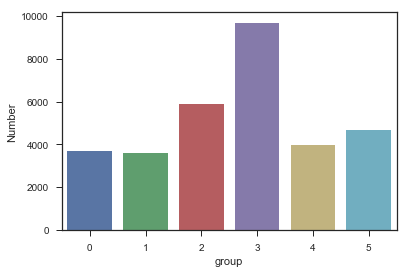

In [30]:
## Total number per each group
import matplotlib.pyplot as plt
plt.style.use(u'ggplot')
sns.set(style="ticks")
sns.barplot(x="group",y="Number",data=a)

## Conclusions

I have examined the ratings that people give to movies, and how those ratings might be biased by people's preferences for certain kinds of movies. It is clear that distinct biases exist based on one's movie preferences. To study these biases more quantitatively, I first used a simple approach that treated each genre independent of each other, but I also clearly found evidence of strong correlations (and anti-correlations) between some genres. So a more rigorous approach was taken to study user preferences which allowed for the inherent correlations between genres to be included by using PCA. 

The PCA analysis reduced the available features to just two dimensions, corresponding to the two most significant eigenmodes that contribute to the variance in the data. From these two dimensions, I selected six distinct clusters using the unsupervised learning algorithm called KMeans clustering. After checking the different ratings given by users in these six clusters, a pattern emerges that reveals some of the most fundamental divides in movie preferences. 